about timss dataset:



*   nearly 400 assessment items
*   16 different aspects in math and science
*   Students answer only a small fraction '<20%' of the available assessment  
*   80 variables about Student family, home, academic resource and behavior



**Abnormalities**
Converting basic string objects into properly sorted categories
Converting scaled responses into numerical results
Summarizing or combining variables that are redundant across datasets (e.g. test results on paper vs. electronic assessments when students only participate in one type of assessment)
Dropping variables that do not offer any insight into relationship (e.g. unanimously one value)
Renaming variables to give them more consistent and descriptive names





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import data and preprocess

In [ ]:
!pip install pyreadstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.7 MB/s eta 0:00:00


In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import re
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.metrics import confusion_matrix
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

کد کشور ها

In [ ]:
# import the country codes into a dataframe
url='https://raw.githubusercontent.com/sjhaluck/TIMSS-Data-Science/2ec6887132aa2449aca5f0eef6dc0cafbbb1b7f0/data/country_codes.csv'
country_codes = pd.read_csv(url).dropna()
# rename the columns to be consistent with TIMSS information
country_codes.rename(columns = {'ID':'IDCNTRY'}, inplace=True)
# convert IDCNTRY to integers
country_codes['IDCNTRY'] = country_codes['IDCNTRY'].astype(int)
# demonstrate country code information
country_codes


Country  IDCNTRY
0                   Australia       36
1                     Bahrain       48
2                       Chile      152
3              Chinese Taipei      158
4                      Cyprus      196
5                       Egypt      818
6                     England      926
7                     Finland      246
8                      France      250
9                     Georgia      268
10              Hong Kong SAR      344
11                    Hungary      348
12      Iran, Islamic Rep. of      364
13                    Ireland      372
14                     Israel      376
15                      Italy      380
16                      Japan      392
17                     Jordan      400
18                 Kazakhstan      398
19             Korea, Rep. of      410
20                     Kuwait      414
21                    Lebanon      422
22                  Lithuania      440
23                   Malaysia      458
24                    Morocco      504
25                New Zealand      554
26                     Norway      578
27                       Oman      512
28                   Portugal      620
29                      Qatar      634
30                    Romania      642
31         Russian Federation      643
32               Saudi Arabia      682
33                  Singapore      702
34               South Africa      710
35                     Sweden      752
36                     Turkey      792
37       United Arab Emirates      784
38              United States      840
39            Ontario, Canada     9132
40             Quebec, Canada     9133
41  Moscow City, Russian Fed.   643001
42             Abu Dhabi, UAE     7842
43                 Dubai, UAE     7841

In [ ]:
# gather the metadata (column names) for the student assessment data
meta = pyreadstat.read_sav('/content/drive/MyDrive/Data8/bsairnm7.sav', metadataonly=True)
# select a subset of the columns for analysis
stud_ach_cols = meta[0].columns[:1265]
print(stud_ach_cols)

Index(['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'MP52024',
       'MP52058A', 'MP52058B', 'MP52125', 'MP52229',
       ...
       'BSSPHY01', 'BSSPHY02', 'BSSPHY03', 'BSSPHY04', 'BSSPHY05', 'BSSREA01',
       'BSSREA02', 'BSSREA03', 'BSSREA04', 'BSSREA05'],
      dtype='object', length=1265)


یک دیتافریم میسازیم برای هر مدرسه با یک سری زیر ستون از مجموعه داده های اصلی و همین کار را برای دیتافریم های stud_ach , student , stud_teach , math_teach , sci_teach  انجام میدهیم

In [ ]:
# identify the file containing all of the code interpretations
file_name = '/content/drive/MyDrive/Codebooks/T19_G8_Codebook.xlsx'
# store all codes into respectively named _codes dataframes
school_codes = pd.read_excel(file_name, sheet_name='BCGM7').set_index('Variable').iloc[:,:1]
stud_ach_codes = pd.read_excel(file_name, sheet_name='BSAM7').set_index('Variable').iloc[:,:1]
student_codes = pd.read_excel(file_name, sheet_name='BSGM7').set_index('Variable').iloc[:,:1]
stud_teach_codes = pd.read_excel(file_name, sheet_name='BSTM7').set_index('Variable').iloc[:,:1]
math_teach_codes = pd.read_excel(file_name, sheet_name='BTMM7').set_index('Variable').iloc[:,:1]
sci_teach_codes = pd.read_excel(file_name, sheet_name='BTSM7').set_index('Variable').iloc[:,:1]

In [ ]:
# read each dataframe from its respective CSV file
school = pd.read_csv('/content/drive/MyDrive/TIMSS/Kuwait/school.csv')
stud_ach = pd.read_csv('/content/drive/MyDrive/TIMSS/Kuwait/stud_ach.csv')
student = pd.read_csv('/content/drive/MyDrive/TIMSS/Kuwait/student.csv')
stud_teach = pd.read_csv('/content/drive/MyDrive/TIMSS/Kuwait/stud_teach.csv')
math_teach = pd.read_csv('/content/drive/MyDrive/TIMSS/Kuwait/math_teach.csv')
sci_teach = pd.read_csv('/content/drive/MyDrive/TIMSS/Kuwait/sci_teach.csv')

**Explore Data**
Explore the structure and values of the data

In [ ]:
stud_ach.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BNRGCAL1  \
0    414.0  Booklet 13    5001.0  500101.0  50010101.0       No   
1    414.0  Booklet 14    5001.0  500101.0  50010102.0      Yes   
2    414.0  Booklet 02    5001.0  500101.0  50010104.0      Yes   
3    414.0  Booklet 03    5001.0  500101.0  50010105.0       No   
4    414.0  Booklet 04    5001.0  500101.0  50010106.0      Yes   

                                    BNRGCAL2  IDPOP     IDGRADER  IDGRADE  \
0                                        NaN  Pop 2  Upper Grade  Grade 8   
1   very little (for fewer than 5 questions)  Pop 2  Upper Grade  Grade 8   
2  somewhat (for between 5 and 10 questions)  Pop 2  Upper Grade  Grade 8   
3                                 not at all  Pop 2  Upper Grade  Grade 8   
4                                 not at all  Pop 2  Upper Grade  Grade 8   

  ITLANG_SA          LCID_SA   ITSEX  BSDAGE             ITADMINI  \
0    Arabic  Arabic (Kuwait)  Female   13.83  Teacher from School   
1    Arabic  Arabic (Kuwait)  Female   13.42  Teacher from School   
2    Arabic  Arabic (Kuwait)  Female   13.42  Teacher from School   
3    Arabic  Arabic (Kuwait)  Female   13.17  Teacher from School   
4    Arabic  Arabic (Kuwait)  Female   13.83  Teacher from School   

                                            ILRELIAB  MP52024_val  \
0  Students Booklet not used for Reliability Scoring          NaN   
1  Students Booklet not used for Reliability Scoring          0.0   
2  Students Booklet not used for Reliability Scoring          NaN   
3  Students Booklet was used for Reliability Scoring          NaN   
4  Students Booklet not used for Reliability Scoring          NaN   

   MP52058_val  MP52125_val  MP52229_val  MP52063_val  MP52072_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          0.0          0.0          1.0          0.0          0.0   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP52146_val  MP52092_val  MP52046_val  MP52083_val  MP52082_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          0.0          0.0          1.0          0.0          1.0   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP52161_val  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          0.0          0.0          NaN          NaN          NaN   
2          NaN          NaN          0.0          0.0          0.0   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72190_val  MP72068_val  MP72076_val  MP72056_val  MP72098_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          1.0          1.0          0.0          0.0          0.0   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72103_val  MP72121_val  MP72180_val  MP72198_val  MP72227_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          1.0          0.0          0.0          1.0          0.0   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72170_val  MP72209_val  MP62005_val  MP62139_val  MP62164_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN         

# else

In [ ]:
common_columns=student.columns & stud_ach.columns
print(common_columns)

Index(['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDPOP',
       'ITLANG_SA', 'LCID_SA', 'ITSEX', 'BSDAGE'],
      dtype='object')


<ipython-input-9-1f7f630156e5>:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  common_columns=student.columns & stud_ach.columns


In [ ]:
# Join the dataframes on idstud
allfeatures= stud_ach.merge(student, on='IDSTUD')
allfeatures = allfeatures.drop(allfeatures.filter(regex='_y$').columns, axis=1)
allfeatures.columns=allfeatures.columns.str.replace('_x','')

In [ ]:
allfeatures.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BNRGCAL1  \
0    414.0  Booklet 13    5001.0  500101.0  50010101.0       No   
1    414.0  Booklet 14    5001.0  500101.0  50010102.0      Yes   
2    414.0  Booklet 02    5001.0  500101.0  50010104.0      Yes   
3    414.0  Booklet 03    5001.0  500101.0  50010105.0       No   
4    414.0  Booklet 04    5001.0  500101.0  50010106.0      Yes   

                                    BNRGCAL2  IDPOP     IDGRADER  IDGRADE  \
0                                        NaN  Pop 2  Upper Grade  Grade 8   
1   very little (for fewer than 5 questions)  Pop 2  Upper Grade  Grade 8   
2  somewhat (for between 5 and 10 questions)  Pop 2  Upper Grade  Grade 8   
3                                 not at all  Pop 2  Upper Grade  Grade 8   
4                                 not at all  Pop 2  Upper Grade  Grade 8   

  ITLANG_SA          LCID_SA   ITSEX  BSDAGE             ITADMINI  \
0    Arabic  Arabic (Kuwait)  Female   13.83  Teacher from School   
1    Arabic  Arabic (Kuwait)  Female   13.42  Teacher from School   
2    Arabic  Arabic (Kuwait)  Female   13.42  Teacher from School   
3    Arabic  Arabic (Kuwait)  Female   13.17  Teacher from School   
4    Arabic  Arabic (Kuwait)  Female   13.83  Teacher from School   

                                            ILRELIAB  MP52024_val  \
0  Students Booklet not used for Reliability Scoring          NaN   
1  Students Booklet not used for Reliability Scoring          0.0   
2  Students Booklet not used for Reliability Scoring          NaN   
3  Students Booklet was used for Reliability Scoring          NaN   
4  Students Booklet not used for Reliability Scoring          NaN   

   MP52058_val  MP52125_val  MP52229_val  MP52063_val  MP52072_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          0.0          0.0          1.0          0.0          0.0   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP52146_val  MP52092_val  MP52046_val  MP52083_val  MP52082_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          0.0          0.0          1.0          0.0          1.0   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP52161_val  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          0.0          0.0          NaN          NaN          NaN   
2          NaN          NaN          0.0          0.0          0.0   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72190_val  MP72068_val  MP72076_val  MP72056_val  MP72098_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          1.0          1.0          0.0          0.0          0.0   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72103_val  MP72121_val  MP72180_val  MP72198_val  MP72227_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          1.0          0.0          0.0          1.0          0.0   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72170_val  MP72209_val  MP62005_val  MP62139_val  MP62164_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN         

In [ ]:
allfeatures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4574 entries, 0 to 4573
Columns: 527 entries, IDCNTRY to BSDGEDUP
dtypes: float64(475), object(52)
memory usage: 18.4+ MB


In [ ]:
# explore the school dataframe
school.head()

IDCNTRY  IDSCHOOL  IDPOP ITLANG_C            LCID_C   BCBGDAS   BCBGEAS  \
0    414.0    5001.0  Pop 2   Arabic   Arabic (Kuwait)  14.02858  11.06274   
1    414.0    5002.0  Pop 2   Arabic   Arabic (Kuwait)   6.02711  10.46161   
2    414.0    5003.0  Pop 2   Arabic   Arabic (Kuwait)  11.19421  10.15969   
3    414.0    5004.0  Pop 2   Arabic   Arabic (Kuwait)  10.80136   6.24903   
4    414.0    5005.0  Pop 2  English  English (Kuwait)  10.43939  11.35999   

    BCBGMRS   BCBGSRS                      BCDGDAS          BCDGEAS  \
0  12.92960  14.57241          Hardly Any Problems    High Emphasis   
1  12.29366  12.05633  Moderate to Severe Problems    High Emphasis   
2  10.08629  10.17656          Hardly Any Problems    High Emphasis   
3   9.73618   9.80545          Hardly Any Problems  Medium Emphasis   
4   8.44578   8.44672               Minor Problems    High Emphasis   

        BCDGMRS       BCDGSRS                                       BCDGSBC  \
0  Not Affected  Not Affected                                 More Affluent   
1  Not Affected  Not Affected                            More Disadvantaged   
2      Affected      Affected  Neither More Affluent nor More Disadvantaged   
3      Affected      Affected                            More Disadvantaged   
4      Affected      Affected  Neither More Affluent nor More Disadvantaged   

   BCDGTIHY  
0    761.25  
1   1113.00  
2       NaN  
3       NaN  
4   1098.00

In [ ]:
num_schools=school['IDSCHOOL'].nunique()
print(f"The 'idschool' column in the 'school' dataframe has {num_schools} unique values.")

The 'idschool' column in the 'school' dataframe has 171 unique values.


In [ ]:
# list all participating countries (excluding benchmarking countries - codes >= 1000)
country_codes.set_index('IDCNTRY').loc[list(filter(lambda x: x<1000,list(school['IDCNTRY'].astype(int).unique()))),'Country']

IDCNTRY
414    Kuwait
Name: Country, dtype: object

In [ ]:
# make a list to drop all columns that are empty or only contain one unqiue value
school_drop_new = list(school.columns[school.isna().all()])+list(school.columns[school.nunique()==1])
# display summary information for school dataframe
school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IDCNTRY   171 non-null    float64
 1   IDSCHOOL  171 non-null    float64
 2   IDPOP     171 non-null    object 
 3   ITLANG_C  170 non-null    object 
 4   LCID_C    170 non-null    object 
 5   BCBGDAS   170 non-null    float64
 6   BCBGEAS   170 non-null    float64
 7   BCBGMRS   170 non-null    float64
 8   BCBGSRS   170 non-null    float64
 9   BCDGDAS   170 non-null    object 
 10  BCDGEAS   170 non-null    object 
 11  BCDGMRS   170 non-null    object 
 12  BCDGSRS   170 non-null    object 
 13  BCDGSBC   133 non-null    object 
 14  BCDGTIHY  141 non-null    float64
dtypes: float64(7), object(8)
memory usage: 20.2+ KB


In [ ]:
# display descriptive statistics for school dataframe
school.describe()

IDCNTRY     IDSCHOOL     BCBGDAS    BCBGEAS     BCBGMRS     BCBGSRS  \
count    171.0   171.000000  170.000000  170.00000  170.000000  170.000000   
mean     414.0  5086.988304    9.242698   10.23985    8.965273    8.985884   
std        0.0    50.209677    2.174274    1.89808    2.129120    2.222242   
min      414.0  5001.000000    4.100070    5.37607    4.234860    4.076240   
25%      414.0  5043.500000    7.698488    9.26475    7.871450    7.663790   
50%      414.0  5087.000000    9.512790   10.15969    8.956180    8.869125   
75%      414.0  5130.500000   10.801360   11.65536   10.026720   10.176560   
max      414.0  5173.000000   14.028580   16.36222   14.255960   14.572410   

          BCDGTIHY  
count   141.000000  
mean    977.300827  
std     248.904300  
min     567.000000  
25%     813.750000  
50%     933.333330  
75%    1050.000000  
max    2025.000000

In [ ]:
# display context/label information for the school variables
school_codes.loc[school.columns,:]

Label
IDCNTRY                    Country ID - Numeric ISO Code
IDSCHOOL                                       School ID
IDPOP                                      Population ID
ITLANG_C                Language of School Questionnaire
LCID_C                 Locale ID of School Questionnaire
BCBGDAS            School Discipline Problems-Prncpl/SCL
BCBGEAS           School Emph on Acad Success-Prncpl/SCL
BCBGMRS         Instr Aff by Mat Res Shortage-Prncpl/SCL
BCBGSRS         Instr Aff by Sci Res Shortage-Prncpl/SCL
BCDGDAS            School Discipline Problems-Prncpl/IDX
BCDGEAS           School Emph on Acad Success-Prncpl/IDX
BCDGMRS         Instr Aff by Mat Res Shortage-Prncpl/IDX
BCDGSRS         Instr Aff by Sci Res Shortage-Prncpl/IDX
BCDGSBC   School Composition by Socioeconomic Background
BCDGTIHY              Total Instructional Hours per Year

In [ ]:
# examine the columns containing "BC" more closely for better understanding
school.sample(5).loc[:,[col for col in school.columns if "BC" in col]]

BCBGDAS   BCBGEAS   BCBGMRS   BCBGSRS                      BCDGDAS  \
145  10.10482  10.15969   7.38668   7.45872               Minor Problems   
102  10.80136  10.46161   8.03304   7.84903          Hardly Any Problems   
99    4.10007   9.56054   8.18097   8.17049  Moderate to Severe Problems   
36    6.27380   6.24903   9.52239   9.14554  Moderate to Severe Problems   
155   9.25300  12.86324  11.03708  11.70901               Minor Problems   

             BCDGEAS         BCDGMRS         BCDGSRS  \
145    High Emphasis  Affected A Lot  Affected A Lot   
102    High Emphasis        Affected        Affected   
99   Medium Emphasis        Affected        Affected   
36   Medium Emphasis        Affected        Affected   
155    High Emphasis    Not Affected    Not Affected   

                                          BCDGSBC  BCDGTIHY  
145  Neither More Affluent nor More Disadvantaged       NaN  
102                                 More Affluent    866.25  
99                             More Disadvantaged       NaN  
36                                  More Affluent   1470.00  
155                            More Disadvantaged    875.00

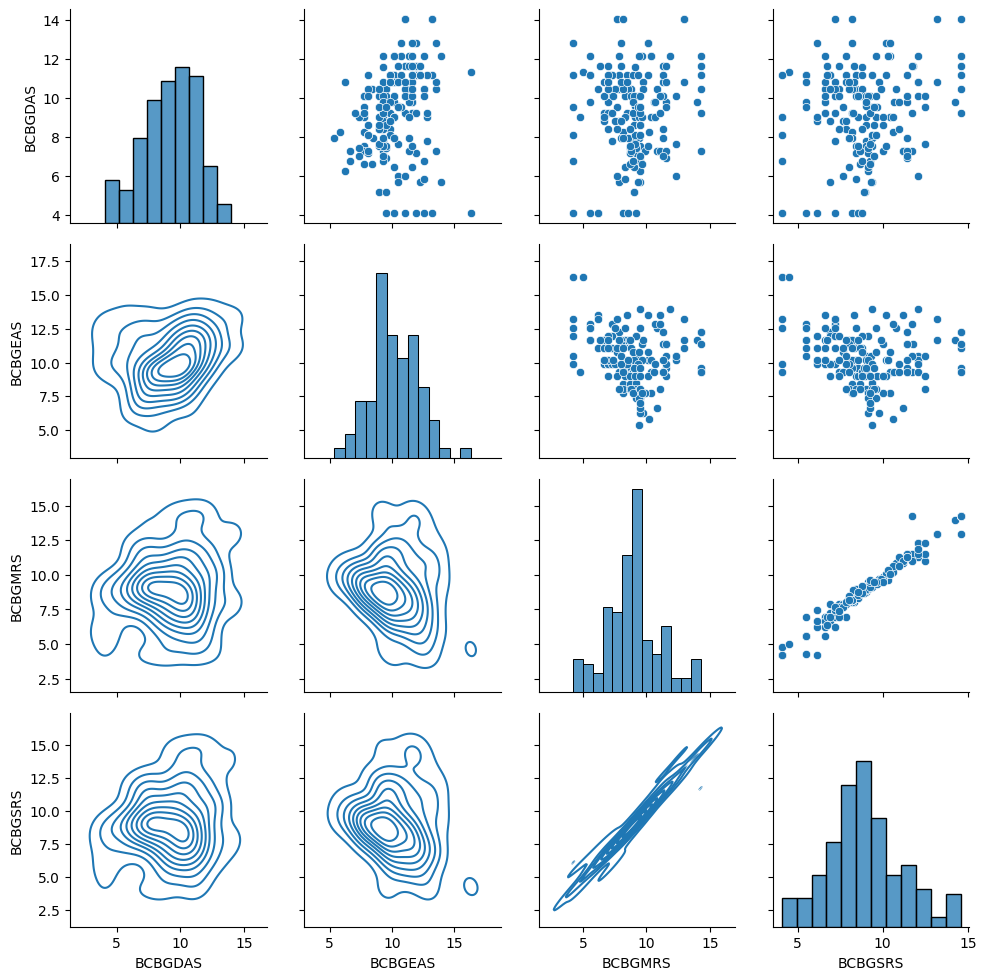

In [ ]:
# plot the relationships between discipline, academics, and shortages
g = sns.PairGrid(school.loc[:,[col for col in school.columns if 'BCBG' in col]])
# upper graphs show possible correlations
g.map_upper(sns.scatterplot)
# lower maps show concentration of relational information
g.map_lower(sns.kdeplot)
# examine distribution of scores along the diagonal
g.map_diag(sns.histplot);

In [ ]:
# investigate student assessment (stud_ach) dataframe
stud_ach.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BNRGCAL1  \
0    414.0  Booklet 13    5001.0  500101.0  50010101.0       No   
1    414.0  Booklet 14    5001.0  500101.0  50010102.0      Yes   
2    414.0  Booklet 02    5001.0  500101.0  50010104.0      Yes   
3    414.0  Booklet 03    5001.0  500101.0  50010105.0       No   
4    414.0  Booklet 04    5001.0  500101.0  50010106.0      Yes   

                                    BNRGCAL2  IDPOP     IDGRADER  IDGRADE  \
0                                        NaN  Pop 2  Upper Grade  Grade 8   
1   very little (for fewer than 5 questions)  Pop 2  Upper Grade  Grade 8   
2  somewhat (for between 5 and 10 questions)  Pop 2  Upper Grade  Grade 8   
3                                 not at all  Pop 2  Upper Grade  Grade 8   
4                                 not at all  Pop 2  Upper Grade  Grade 8   

  ITLANG_SA          LCID_SA   ITSEX  BSDAGE             ITADMINI  \
0    Arabic  Arabic (Kuwait)  Female   13.83  Teacher from School   
1    Arabic  Arabic (Kuwait)  Female   13.42  Teacher from School   
2    Arabic  Arabic (Kuwait)  Female   13.42  Teacher from School   
3    Arabic  Arabic (Kuwait)  Female   13.17  Teacher from School   
4    Arabic  Arabic (Kuwait)  Female   13.83  Teacher from School   

                                            ILRELIAB  MP52024_val  \
0  Students Booklet not used for Reliability Scoring          NaN   
1  Students Booklet not used for Reliability Scoring          0.0   
2  Students Booklet not used for Reliability Scoring          NaN   
3  Students Booklet was used for Reliability Scoring          NaN   
4  Students Booklet not used for Reliability Scoring          NaN   

   MP52058_val  MP52125_val  MP52229_val  MP52063_val  MP52072_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          0.0          0.0          1.0          0.0          0.0   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP52146_val  MP52092_val  MP52046_val  MP52083_val  MP52082_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          0.0          0.0          1.0          0.0          1.0   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP52161_val  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          0.0          0.0          NaN          NaN          NaN   
2          NaN          NaN          0.0          0.0          0.0   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72190_val  MP72068_val  MP72076_val  MP72056_val  MP72098_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          1.0          1.0          0.0          0.0          0.0   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72103_val  MP72121_val  MP72180_val  MP72198_val  MP72227_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          1.0          0.0          0.0          1.0          0.0   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72170_val  MP72209_val  MP62005_val  MP62139_val  MP62164_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN         

In [ ]:
# create a list to drop all null columns and any columns that online contain one unique entry
stud_ach_drop_new = list(stud_ach.columns[stud_ach.isna().all()])+list(stud_ach.columns[stud_ach.nunique()==1])

In [ ]:
# display descriptive statisticis for quantitative columns in the dataframe
stud_ach.describe()

IDCNTRY     IDSCHOOL        IDCLASS        IDSTUD       BSDAGE  \
count   4574.0  4574.000000    4574.000000  4.574000e+03  4570.000000   
mean     414.0  5088.303236  508833.460647  5.088336e+07    13.759037   
std        0.0    49.525508    4952.596521  4.952598e+05     0.646223   
min      414.0  5001.000000  500101.000000  5.001010e+07     9.250000   
25%      414.0  5046.000000  504602.000000  5.046023e+07    13.420000   
50%      414.0  5089.000000  508906.000000  5.089063e+07    13.670000   
75%      414.0  5132.000000  513201.000000  5.132011e+07    13.920000   
max      414.0  5173.000000  517301.000000  5.173012e+07    18.250000   

       MP52024_val  MP52058_val  MP52125_val  MP52229_val  MP52063_val  \
count   638.000000   611.000000   638.000000   618.000000   636.000000   
mean      0.294671     0.085106     0.202194     0.443366     0.273585   
std       0.456252     0.279269     0.401952     0.497185     0.446149   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP52072_val  MP52146_val  MP52092_val  MP52046_val  MP52083_val  \
count   641.000000   602.000000   631.000000   637.000000   632.000000   
mean      0.432137     0.064784     0.213946     0.237049     0.199367   
std       0.495760     0.246349     0.410415     0.425607     0.399841   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP52082_val  MP52161_val  MP52418_val  MP72007_val  MP72025_val  \
count   640.000000   631.000000   634.000000   640.000000   634.000000   
mean      0.271875     0.419968     0.064669     0.098437     0.268139   
std       0.445274     0.493945     0.246135     0.298138     0.443340   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     0.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP72017_val  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
count   570.000000   610.000000   639.000000   635.000000   579.000000   
mean      0.066667     0.367213     0.367762     0.242520     0.127807   
std       0.249663     0.482441     0.482574     0.428945     0.334163   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     1.000000     1.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP72098_val  MP72103_val  MP72121_val  MP72180_val  MP72198_val  \
count   606.000000   633.000000   618.000000   609.000000   576.000000   
mean      0.082508     0.246445     0.330097     0.274220     0.222222   
std       0.275365     0.431282     0.470629     0.446487     0.416101   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     1.000000     1.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP72227

In [ ]:
print(stud_ach_drop_new)

['MP62342_val', 'MP72038_val', 'MP62048_val', 'SP62272_val', 'SP72403_val', 'SP52221_val', 'SP72133_val', 'SP72048_val', 'SP62036_val', 'SP72906_val', 'SP72329_val', 'SP62266_val', 'malg_avg', 'malg_sd', 'mapp_avg', 'mapp_sd', 'mdat_avg', 'mdat_sd', 'mgeo_avg', 'mgeo_sd', 'mkno_avg', 'mkno_sd', 'mnum_avg', 'mnum_sd', 'mrea_avg', 'mrea_sd', 'sapp_avg', 'sapp_sd', 'sbio_avg', 'sbio_sd', 'sche_avg', 'sche_sd', 'sear_avg', 'sear_sd', 'skno_avg', 'skno_sd', 'sphy_avg', 'sphy_sd', 'srea_avg', 'srea_sd', 'IDCNTRY', 'IDPOP', 'IDGRADER', 'IDGRADE']


In [ ]:
# display the datatype for all columsn that are not averages or standard deviations of scores
stud_ach.loc[:,[col for col in stud_ach.columns if '_val' not in col and '_avg' not in col and '_sd' not in col]].dtypes

IDCNTRY      float64
IDBOOK        object
IDSCHOOL     float64
IDCLASS      float64
IDSTUD       float64
BNRGCAL1      object
BNRGCAL2      object
IDPOP         object
IDGRADER      object
IDGRADE       object
ITLANG_SA     object
LCID_SA       object
ITSEX         object
BSDAGE       float64
ITADMINI      object
ILRELIAB      object
dtype: object

In [ ]:
# display the label information for every code that is not an assessment item
stud_ach_codes.loc[[col for col in stud_ach.columns if '_val' not in col and '_avg' not in col and '_sd' not in col],:]

Label
Variable                                                  
IDCNTRY                      Country ID - Numeric ISO Code
IDBOOK                                Student Test Booklet
IDSCHOOL                                         School ID
IDCLASS                                           Class ID
IDSTUD                                          Student ID
BNRGCAL1               CALCULATOR SURVEY\USE OF CALCULATOR
BNRGCAL2   CALCULATOR SURVEY\FREQUENCY OF USING CALCULATOR
IDPOP                                        Population ID
IDGRADER                             Standardized Grade ID
IDGRADE                                           Grade ID
ITLANG_SA             Language of Student Achievement Test
LCID_SA              Locale ID of Student Achievement Test
ITSEX                                      Sex of Students
BSDAGE                                        Students Age
ITADMINI                       Test Administrator Position
ILRELIAB                         Reliability Coding Status

In [ ]:
# add additional nonrelevant information to be dropped
stud_ach_drop_new = stud_ach_drop_new+['BNRGCAL1','BNRGCAL2','ITADMINI','ILRELIAB']
stud_ach_drop_new

['MP62342_val',
 'MP72038_val',
 'MP62048_val',
 'SP62272_val',
 'SP72403_val',
 'SP52221_val',
 'SP72133_val',
 'SP72048_val',
 'SP62036_val',
 'SP72906_val',
 'SP72329_val',
 'SP62266_val',
 'malg_avg',
 'malg_sd',
 'mapp_avg',
 'mapp_sd',
 'mdat_avg',
 'mdat_sd',
 'mgeo_avg',
 'mgeo_sd',
 'mkno_avg',
 'mkno_sd',
 'mnum_avg',
 'mnum_sd',
 'mrea_avg',
 'mrea_sd',
 'sapp_avg',
 'sapp_sd',
 'sbio_avg',
 'sbio_sd',
 'sche_avg',
 'sche_sd',
 'sear_avg',
 'sear_sd',
 'skno_avg',
 'skno_sd',
 'sphy_avg',
 'sphy_sd',
 'srea_avg',
 'srea_sd',
 'IDCNTRY',
 'IDPOP',
 'IDGRADER',
 'IDGRADE',
 'BNRGCAL1',
 'BNRGCAL2',
 'ITADMINI',
 'ILRELIAB']

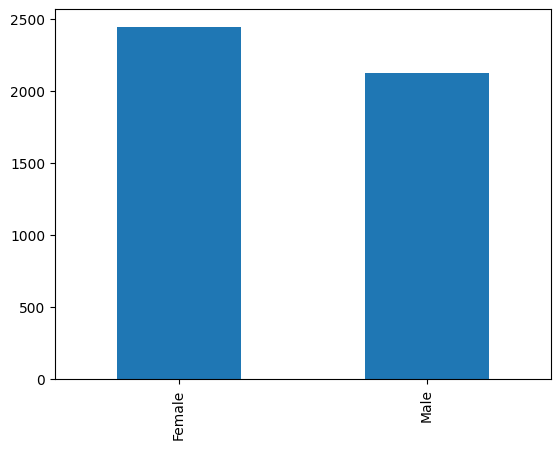

In [ ]:
# graph the different counts of gender in the dataset
stud_ach['ITSEX'].value_counts().plot(kind='bar');

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect co

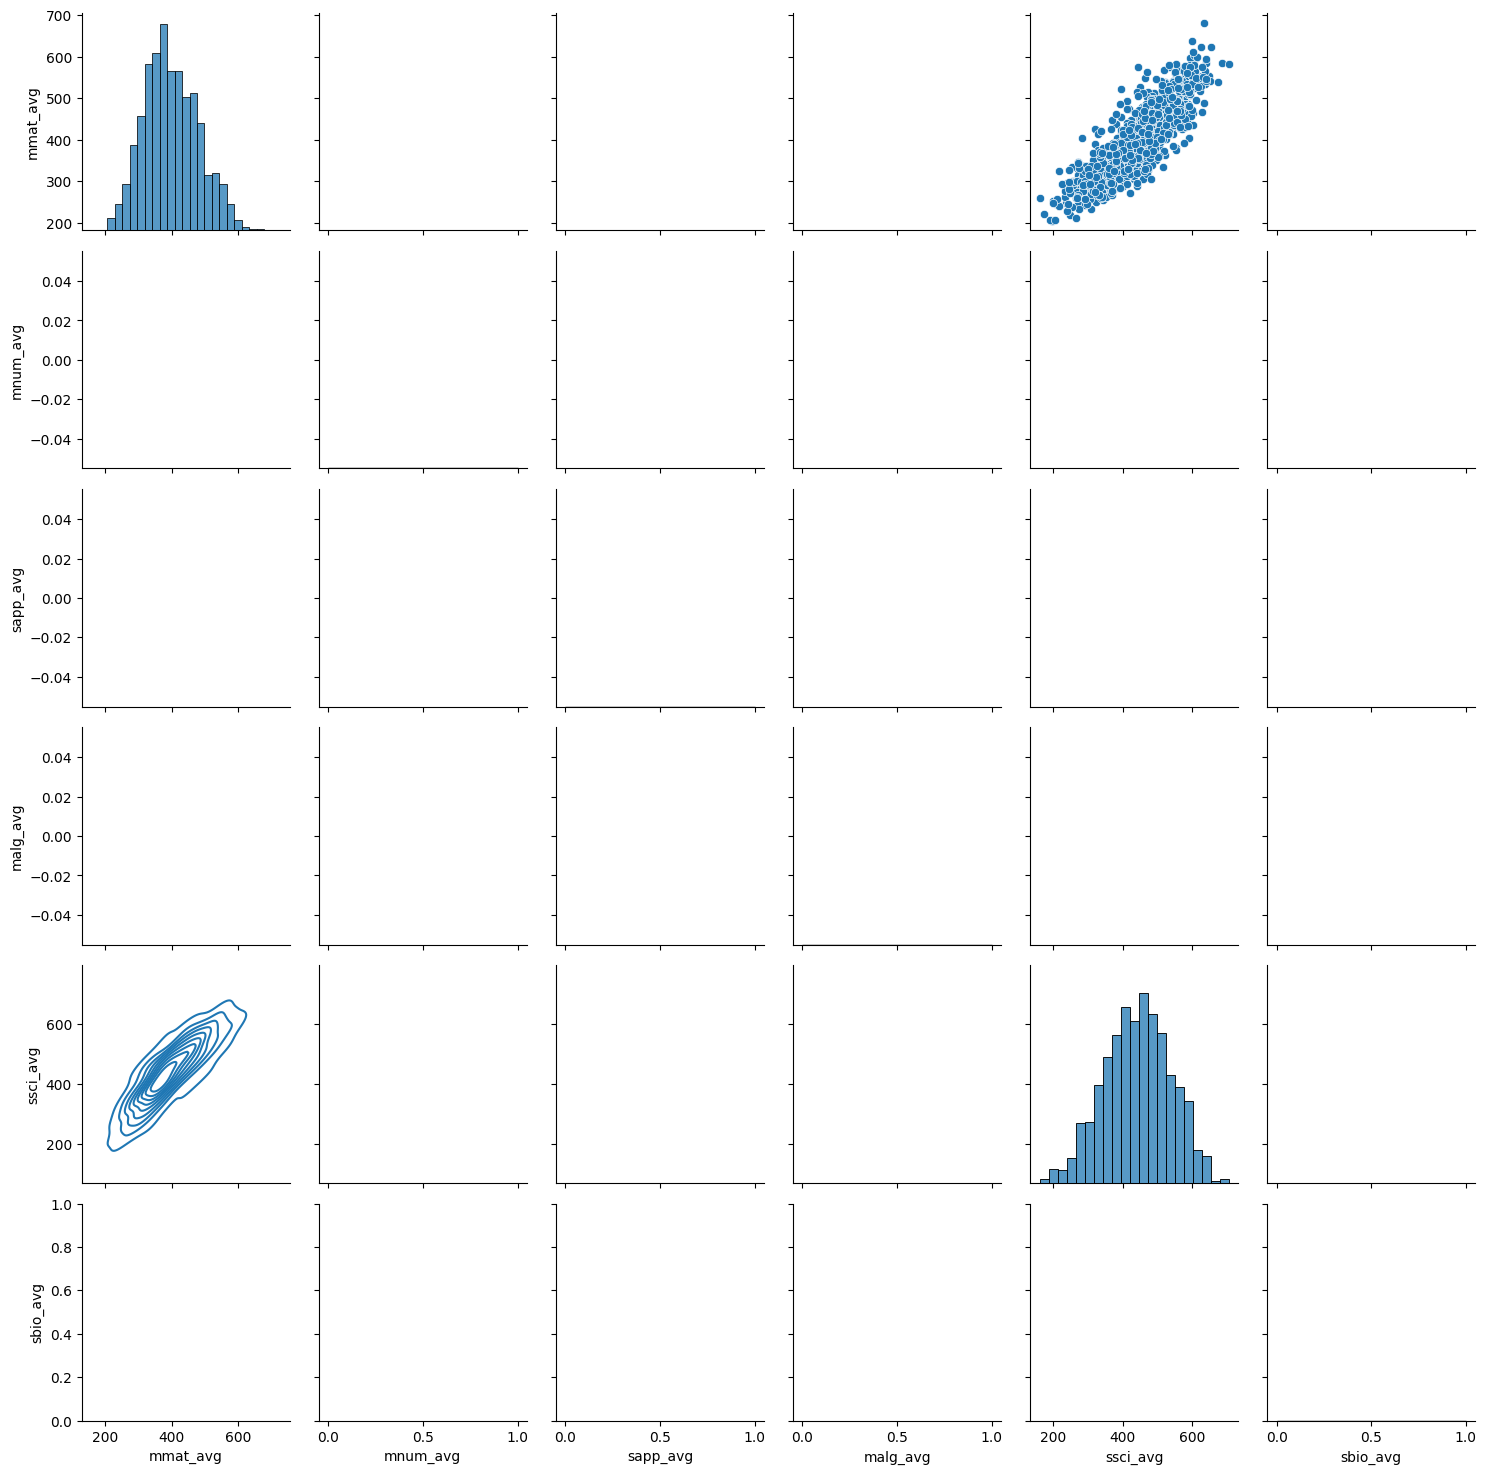

In [ ]:
# plot distributions and relationships for a random sample of 1000 students and scores in 6 random categories
g = sns.PairGrid(stud_ach.sample(1000).loc[:,random.sample([col for col in stud_ach.columns if '_avg' in col],6)])
# upper graphs show possible correlations
g.map_upper(sns.scatterplot)
# lower graphs show concentration of the correlation data
g.map_lower(sns.kdeplot)
# the diagonal graphs show the distribution of the scores in the 6 categories
g.map_diag(sns.histplot);

All mathematical understanding is closely related (strong correlation)
All science understanding is closely related (strong correlation)
The relationship between science and math has more variance - is this due to subject differences or the difference in teaching?

In [ ]:
# explore the basic info for teh student dataframe
student.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BSBG01     BSBG03  \
0    414.0  Booklet 13    5001.0  500101.0  50010101.0   Girl     Always   
1    414.0  Booklet 14    5001.0  500101.0  50010102.0   Girl  Sometimes   
2    414.0  Booklet 02    5001.0  500101.0  50010104.0   Girl     Always   
3    414.0  Booklet 03    5001.0  500101.0  50010105.0   Girl  Sometimes   
4    414.0  Booklet 04    5001.0  500101.0  50010106.0   Girl     Always   

                                              BSBG04 BSBG05A BSBG05B BSBG05C  \
0  Enough to fill three or more bookcases (more t...     Yes     Yes      No   
1                      None or very few (0–10 books)     Yes     Yes     Yes   
2             Enough to fill one shelf (11–25 books)     Yes     Yes      No   
3                      None or very few (0–10 books)      No     Yes      No   
4         Enough to fill one bookcase (26–100 books)     Yes      No      No   

  BSBG05D BSBG05E BSBG05F  BSBG05G  BSBG05H  BSBG05I  \
0     Yes      No     Yes      NaN      NaN      NaN   
1     Yes      No     Yes      NaN      NaN      NaN   
2     Yes     Yes     Yes      NaN      NaN      NaN   
3     Yes     Yes     Yes      NaN      NaN      NaN   
4     Yes     Yes      No      NaN      NaN      NaN   

                                             BSBG06A  \
0                                       I don’t know   
1     <Bachelor’s or equivalent level—ISCED Level 6>   
2  <Post-secondary, non-tertiary education—ISCED ...   
3  <Postgraduate degree: Master’s—ISCED Level 7 o...   
4  <Postgraduate degree: Master’s—ISCED Level 7 o...   

                                             BSBG06B  \
0                                       I don’t know   
1     <Bachelor’s or equivalent level—ISCED Level 6>   
2  <Post-secondary, non-tertiary education—ISCED ...   
3  <Post-secondary, non-tertiary education—ISCED ...   
4     <Bachelor’s or equivalent level—ISCED Level 6>   

                                              BSBG07 BSBG08A BSBG08B BSBG09A  \
0  Finish <Short-cycle tertiary education—ISCED L...     Yes     Yes     Yes   
1  Finish <Postgraduate degree: Master’s—ISCED Le...     Yes     Yes     Yes   
2  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
3  Finish <Postgraduate degree: Master’s—ISCED Le...     Yes     Yes     Yes   
4  Finish <Postgraduate degree: Master’s—ISCED Le...     Yes     Yes     Yes   

  BSBG09B                 BSBG10           BSBG11A           BSBG11B BSBG12A  \
0     NaN  Never or almost never  Almost every day         Sometimes     Yes   
1     NaN           Once a month         Sometimes         Sometimes      No   
2     NaN  Never or almost never  Almost every day         Every day      No   
3     NaN   Once every two weeks         Sometimes  Almost every day      No   
4     NaN  Never or almost never         Sometimes  Almost every day      No   

  BSBG12B BSBG12C BSBG12D BSBG12E BSBG12F  IDPOP ITLANG_SQ          LCID_SQ  \
0     Yes     Yes     Yes     Yes     Yes  Pop 2    Arabic  Arabic (Kuwait)   
1     Yes     Yes      No     Yes      No  Pop 2    Arabic  Arabic (Kuwait)   
2      No      No      No     Yes      No  Pop 2    Arabic  Arabic (Kuwait)   
3     Yes     Yes     Yes      No     Yes  Pop 2    Arabic  Arabic (Kuwait)   
4     Yes     Yes      No     Yes      No  Pop 2    Arabic  Arabic (Kuwait)   

  ITLANG_SA          LCID_SA   ITSEX  BSDAGE   BSBGHER         BSDGHER  \
0    Arabic  Arabic (Kuwait)  Female   13.83  12.04797  Some Resources   
1    Arabic  Arabic (Kuwait)  Female   13.42  10.23835  Some Resources   
2    Arabic  Arabic (Kuwait)  Female   13.42   9.64761  Some Resources   
3    Arabic  Arabic (Kuwait)  Female   13.17   9.64761  Some Resources   
4    Arabic  Arabic (Kuwait)  Female   13.83  10.84499  Some Resources   

    BSBGSSB                           BSDGSSB    BSBGSB  \
0  10.00496    Some Sense of School Belonging   9.28593   
1   8.46096    Some Sense of School Belonging  11.1878

In [ ]:
# create a list to drop all empty or unnecessary columns (containing only one value)
student_drop_new = list(student.columns[student.isna().all()])+list(student.columns[student.nunique()==1])

In [ ]:
# display the basic quality information for the student dataframe
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4574 entries, 0 to 4573
Data columns (total 92 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IDCNTRY    4574 non-null   float64
 1   IDBOOK     4574 non-null   object 
 2   IDSCHOOL   4574 non-null   float64
 3   IDCLASS    4574 non-null   float64
 4   IDSTUD     4574 non-null   float64
 5   BSBG01     4533 non-null   object 
 6   BSBG03     4487 non-null   object 
 7   BSBG04     4469 non-null   object 
 8   BSBG05A    4496 non-null   object 
 9   BSBG05B    4489 non-null   object 
 10  BSBG05C    4496 non-null   object 
 11  BSBG05D    4479 non-null   object 
 12  BSBG05E    4493 non-null   object 
 13  BSBG05F    4488 non-null   object 
 14  BSBG05G    0 non-null      float64
 15  BSBG05H    0 non-null      float64
 16  BSBG05I    0 non-null      float64
 17  BSBG06A    4462 non-null   object 
 18  BSBG06B    4462 non-null   object 
 19  BSBG07     4431 non-null   object 
 20  BSBG08A 

In [ ]:
# display descriptive statistics of the quantitative information of the student dataframe
student.describe()

IDCNTRY     IDSCHOOL        IDCLASS        IDSTUD  BSBG05G  BSBG05H  \
count   4574.0  4574.000000    4574.000000  4.574000e+03      0.0      0.0   
mean     414.0  5088.303236  508833.460647  5.088336e+07      NaN      NaN   
std        0.0    49.525508    4952.596521  4.952598e+05      NaN      NaN   
min      414.0  5001.000000  500101.000000  5.001010e+07      NaN      NaN   
25%      414.0  5046.000000  504602.000000  5.046023e+07      NaN      NaN   
50%      414.0  5089.000000  508906.000000  5.089063e+07      NaN      NaN   
75%      414.0  5132.000000  513201.000000  5.132011e+07      NaN      NaN   
max      414.0  5173.000000  517301.000000  5.173012e+07      NaN      NaN   

       BSBG05I       BSDAGE      BSBGHER      BSBGSSB       BSBGSB  \
count      0.0  4570.000000  4485.000000  4433.000000  4462.000000   
mean       NaN    13.759037     9.871600     9.939175     9.946776   
std        NaN     0.646223     1.377591     2.129144     2.104560   
min        NaN     9.250000     4.552080     3.924400     1.953440   
25%        NaN    13.420000     8.998770     8.460960     8.505520   
50%        NaN    13.670000    10.238350    10.004960     9.569750   
75%        NaN    13.920000    10.844990    11.622520    11.187840   
max        NaN    18.250000    13.515430    13.271990    12.937340   

           BSBGSLM      BSBGICM      BSBGDML      BSBGSCM      BSBGSVM  \
count  4455.000000  4446.000000  4420.000000  4414.000000  4403.000000   
mean      9.633178    10.066137     9.601435     9.895977     9.718051   
std       2.046959     2.054907     1.873091     1.843570     2.185439   
min       5.094840     3.695680     5.566330     3.277930     3.036820   
25%       8.374120     8.518960     8.444350     8.997360     8.346150   
50%       9.680140    10.383890     9.450610     9.672300     9.654380   
75%      10.898980    11.651150    10.674990    10.661340    11.301900   
max      13.848490    13.018850    14.673710    15.851880    13.482930   

           BSBGSLS      BSBGICS      BSBGSCS      BSBGSVS  BSBGSLB  BSDGSLB  \
count  4387.000000  4377.000000  4367.000000  4333.000000      0.0      0.0   
mean     10.524058    10.432220    10.606777    10.682956      NaN      NaN   
std       2.097090     1.953315     1.909771     1.910621      NaN      NaN   
min       3.846500     4.022730     3.249920     4.283400      NaN      NaN   
25%       9.118560     9.160630     9.122860     9.450510      NaN      NaN   
50%      10.366630    10.789690    10.130140    10.656290      NaN      NaN   
75%      12.196300    12.633860    11.828990    12.936700      NaN      NaN   
max      13.517780    12.633860    14.841820    12.936700      NaN      NaN   

       BSBGICB  BSDGICB  BSBGSCB  BSDGSCB  BSBGSLE  BSDGSLE  BSBGICE  BSDGICE  \
count      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
mean       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
std        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
min        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
25%        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
50%        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
75%        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
max        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

       BSBGSCE  BSDGSCE  BSBGSLC  BSDGSLC  BSBGICC  BSDGICC  BSBGSCC  BSDGSCC  \
count      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
mean       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
std        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
min        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
25%        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
50%        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN 

In [ ]:
# display the contextual information for each column
student_codes.loc[student.columns,:]

Label
IDCNTRY                        Country ID - Numeric ISO Code
IDBOOK                                  Student Test Booklet
IDSCHOOL                                           School ID
IDCLASS                                             Class ID
IDSTUD                                            Student ID
BSBG01                                    GEN\SEX OF STUDENT
BSBG03                GEN\OFTEN SPEAK <LANG OF TEST> AT HOME
BSBG04                      GEN\AMOUNT OF BOOKS IN YOUR HOME
BSBG05A                     GEN\HOME POSSESS\COMPUTER TABLET
BSBG05B                          GEN\HOME POSSESS\STUDY DESK
BSBG05C                            GEN\HOME POSSESS\OWN ROOM
BSBG05D                 GEN\HOME POSSESS\INTERNET CONNECTION
BSBG05E                    GEN\HOME POSSESS\OWN MOBILE PHONE
BSBG05F                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05G                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05H                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05I                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG06A        GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN A>
BSBG06B        GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN B>
BSBG07                GEN\HOW FAR IN EDU DO YOU EXPECT TO GO
BSBG08A            GEN\<PARENT/GUARDIAN A> BORN IN <COUNTRY>
BSBG08B            GEN\<PARENT/GUARDIAN B> BORN IN <COUNTRY>
BSBG09A                                GEN\BORN IN <COUNTRY>
BSBG09B            GEN\BORN IN <COUNTRY>\AGE CAME TO COUNTRY
BSBG10                GEN\ABOUT HOW OFTEN ABSENT FROM SCHOOL
BSBG11A                                  GEN\HOW OFTEN\TIRED
BSBG11B                                 GEN\HOW OFTEN\HUNGRY
BSBG12A                    GEN\INTERNET USE\ACCESS TEXTBOOKS
BSBG12B                  GEN\INTERNET USE\ACCESS ASSIGNMENTS
BSBG12C         GEN\INTERNET USE\COLLABORATE WITH CLASSMATES
BSBG12D            GEN\INTERNET USE\COMMUNICATE WITH TEACHER
BSBG12E     GEN\INTERNET USE\FIND INFO TO AID IN MATH OR SCI
BSBG12F               GEN\INTERNET USE\ACCESS LEARNING GAMES
IDPOP                                          Population ID
ITLANG_SQ          Language of Student Context Questionnaire
LCID_SQ           Locale ID of Student Context Questionnaire
ITLANG_SA               Language of Student Achievement Test
LCID_SA                Locale ID of Student Achievement Test
ITSEX                                        Sex of Students
BSDAGE                                          Students Age
BSBGHER                       Home Educational Resources/SCL
BSDGHER                       Home Educational Resources/IDX
BSBGSSB               Students Sense of School Belonging/SCL
BSDGSSB               Students Sense of School Belonging/IDX
BSBGSB                                  Student Bullying/SCL
BSDGSB                                  Student Bullying/IDX
BSBGSLM       Students Like Learning Mathematics Lessons/SCL
BSDGSLM       Students Like Learning Mathematics Lessons/IDX
BSBGICM     Instructional Clarity in Mathematics Lessons/SCL
BSDGICM     Instructional Clarity in Mathematics Lessons/IDX
BSBGDML          Disorderly Behavior during Math Lessons/SCL
BSDGDML          Disorderly Behavior during Math Lessons/IDX
BSBGSCM                 Student Confident in Mathematics/SCL
BSDGSCM                 Student Confident in Mathematics/IDX
BSBGSVM                       Students Value Mathematics/SCL
BSDGSVM                       Students Value Mathematics/IDX
BSBGSLS                   Students Like Learning Science/SCL
BSDGSLS                   Students Like Learning Science/IDX
BSBGICS         Instructional Clarity in Science Lessons/SCL
BSDGICS         Instructional Clarity in Science Lessons/IDX
BSBGSCS                     Student Confident in Science/SCL
BSDGSCS                     Student Confident in Science/IDX
BSBGSVS                           Students Value Science/SCL
BSDGSVS                           Students Value Science/IDX
BSBGSLB                   Students Like Learning Biology/SCL
BSDGSLB                   Stu

In [ ]:
# investigate some of the data that appears to have two different languages
student.query('ITLANG_SQ != ITLANG_SA and ITLANG_SQ == ITLANG_SQ')

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BSBG01  \
4237    414.0  Booklet 01    5161.0  516102.0  51610201.0    Boy   
4238    414.0  Booklet 02    5161.0  516102.0  51610202.0    Boy   
4239    414.0  Booklet 03    5161.0  516102.0  51610203.0    Boy   
4240    414.0  Booklet 04    5161.0  516102.0  51610204.0    Boy   
4241    414.0  Booklet 05    5161.0  516102.0  51610205.0    Boy   
4242    414.0  Booklet 06    5161.0  516102.0  51610206.0    Boy   
4243    414.0  Booklet 07    5161.0  516102.0  51610207.0    Boy   
4244    414.0  Booklet 08    5161.0  516102.0  51610208.0    Boy   
4245    414.0  Booklet 10    5161.0  516102.0  51610210.0    Boy   
4246    414.0  Booklet 12    5161.0  516102.0  51610212.0    Boy   
4247    414.0  Booklet 13    5161.0  516102.0  51610213.0    Boy   
4248    414.0  Booklet 14    5161.0  516102.0  51610214.0    Boy   
4249    414.0  Booklet 01    5161.0  516102.0  51610215.0    Boy   
4250    414.0  Booklet 02    5161.0  516102.0  51610216.0    Boy   
4251    414.0  Booklet 03    5161.0  516102.0  51610217.0    Boy   
4252    414.0  Booklet 04    5161.0  516102.0  51610218.0    Boy   
4253    414.0  Booklet 05    5161.0  516102.0  51610219.0    Boy   
4254    414.0  Booklet 06    5161.0  516102.0  51610220.0    Boy   
4255    414.0  Booklet 07    5161.0  516102.0  51610221.0    Boy   
4256    414.0  Booklet 08    5161.0  516102.0  51610222.0    Boy   
4257    414.0  Booklet 09    5161.0  516102.0  51610223.0    Boy   
4258    414.0  Booklet 10    5161.0  516102.0  51610224.0    Boy   
4259    414.0  Booklet 11    5161.0  516102.0  51610225.0    Boy   
4260    414.0  Booklet 12    5161.0  516102.0  51610226.0    Boy   
4261    414.0  Booklet 13    5161.0  516102.0  51610227.0    Boy   
4262    414.0  Booklet 14    5161.0  516102.0  51610228.0    Boy   
4263    414.0  Booklet 01    5161.0  516102.0  51610229.0    Boy   

             BSBG03                                             BSBG04  \
4237      Sometimes  Enough to fill three or more bookcases (more t...   
4238         Always             Enough to fill one shelf (11–25 books)   
4239      Sometimes                      None or very few (0–10 books)   
4240         Always                      None or very few (0–10 books)   
4241         Always                      None or very few (0–10 books)   
4242         Always                      None or very few (0–10 books)   
4243         Always                      None or very few (0–10 books)   
4244      Sometimes             Enough to fill one shelf (11–25 books)   
4245         Always             Enough to fill one shelf (11–25 books)   
4246  Almost always             Enough to fill one shelf (11–25 books)   
4247         Always                      None or very few (0–10 books)   
4248         Always             Enough to fill one shelf (11–25 books)   
4249         Always                      None or very few (0–10 books)   
4250         Always                      None or very few (0–10 books)   
4251         Always  Enough to fill three or more bookcases (more t...   
4252         Always             Enough to fill one shelf (11–25 books)   
4253      Sometimes                      None or very few (0–10 books)   
4254      Sometimes                      None or very few (0–10 books)   
4255         Always             Enough to fill one shelf (11–25 books)   
4256         Always                      None or very few (0–10 books)   
4257  Almost always                      None or very few (0–10 books)   
4258         Always  Enough to fill three or more bookcases (more t...   
4259         Always                      None or very few (0–10 books)   
4260  Almost always  Enough to fill three or more bookcases (more t...   
4261         Always                      None or very few (0–10 books)   
4262         Always                      None or very few (0–10 books)   
4263         Always         Enough to fill one bookcase (26–100 books)   

     BSBG05A BSBG05B BSBG05C

In [ ]:
# add additional nonrelevant data to be dropped from the dataframe
student_drop_new = student_drop_new + ['BSBG01','LCID_SQ','LCID_SA']

In [ ]:
# print(student[(student['ITSEX']=='Male') & (student['BSBG01']=='Boy')].head())
# Display all unique values of 'itsex' in the 'student' DataFrame
unique_values = student['BSBG01'].unique()
print(unique_values)


['Girl' 'Boy' nan]


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect co

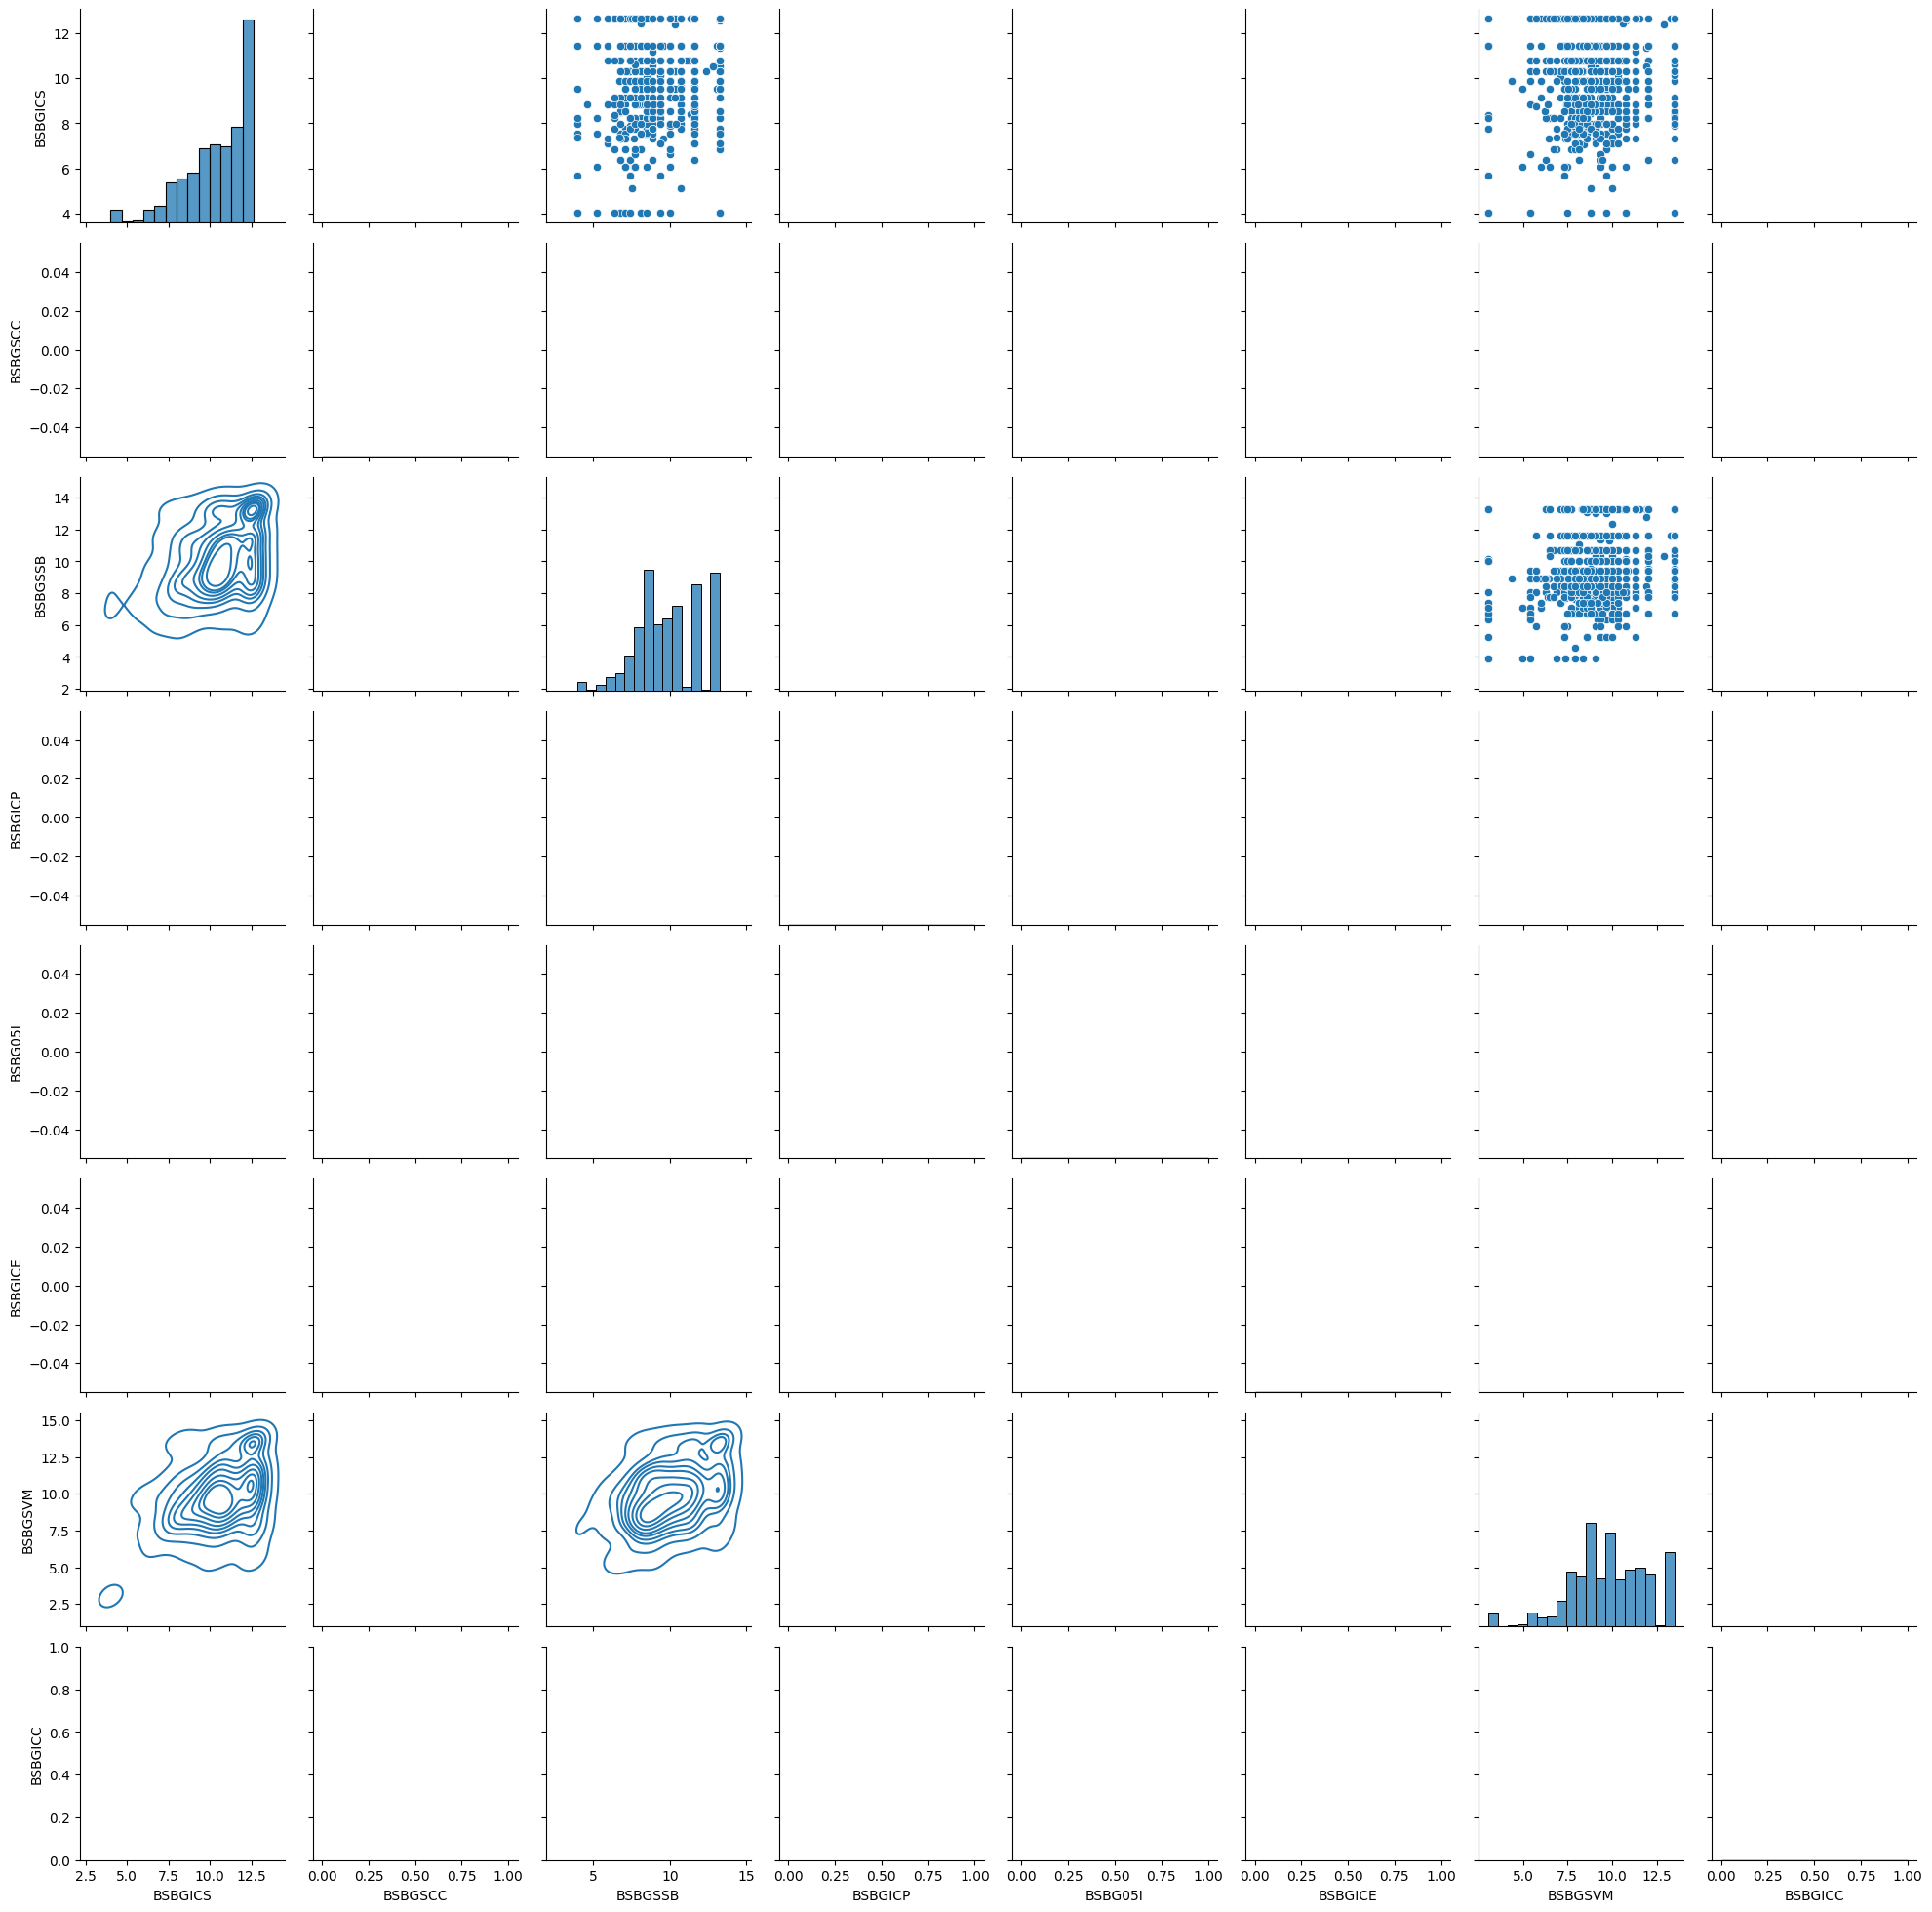

In [ ]:
# visualize the relationships between a selection of the available scores for student demographics (1000 randomly sampled students, 8 random sampled variables)
g = sns.PairGrid(student.sample(1000).loc[:,random.sample([col for col in student.columns if 'BSBG' in col and student[col].dtype == 'float64'],8)])
# upper graphs will show correlation
g.map_upper(sns.scatterplot)
# lower graphs will show data concentration
g.map_lower(sns.kdeplot)
# diagonal graphs will show the distribution of each variable
g.map_diag(sns.histplot);

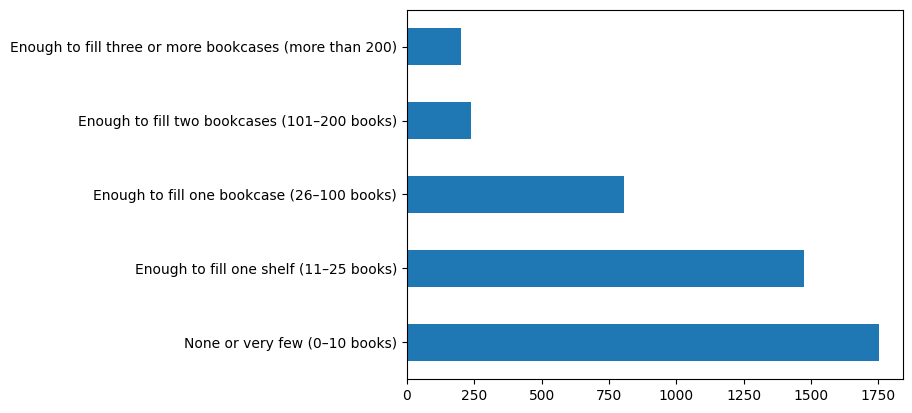

In [ ]:
# visualize the number of books at home for each student
student['BSBG04'].value_counts().plot(kind='barh');

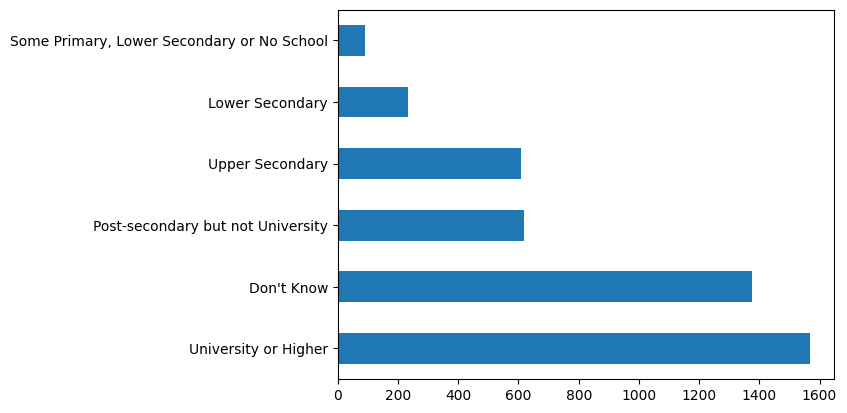

In [ ]:
# visualize the highest level of education achieved by the parents of the student
student['BSDGEDUP'].value_counts().plot(kind='barh');

student Data Preparation

In [ ]:
# explore basic structure of stud_teach dataset
stud_teach.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD    IDTEALIN   IDTEACH  \
0    414.0  Booklet 13    5001.0  500101.0  50010101.0  50010202.0  500102.0   
1    414.0  Booklet 13    5001.0  500101.0  50010101.0  50010101.0  500101.0   
2    414.0  Booklet 14    5001.0  500101.0  50010102.0  50010101.0  500101.0   
3    414.0  Booklet 14    5001.0  500101.0  50010102.0  50010202.0  500102.0   
4    414.0  Booklet 02    5001.0  500101.0  50010104.0  50010202.0  500102.0   

   IDLINK  IDPOP       IDSUBJ            ITCOURSE  NMTEACH  NSTEACH  \
0     2.0  Pop 2      Science  Integrated science      1.0      1.0   
1     1.0  Pop 2  Mathematics         Mathematics      1.0      1.0   
2     1.0  Pop 2  Mathematics         Mathematics      1.0      1.0   
3     2.0  Pop 2      Science  Integrated science      1.0      1.0   
4     2.0  Pop 2      Science  Integrated science      1.0      1.0   

     mmat_avg    ssci_avg  malg_avg  mapp_avg  mdat_avg  mgeo_avg  mkno_avg  \
0  440.622706  575.589620       NaN       NaN       NaN       NaN       NaN   
1  440.622706  575.589620       NaN       NaN       NaN       NaN       NaN   
2  429.666474  518.755814       NaN       NaN       NaN       NaN       NaN   
3  429.666474  518.755814       NaN       NaN       NaN       NaN       NaN   
4  487.450972  613.429380       NaN       NaN       NaN       NaN       NaN   

   mnum_avg  mrea_avg  sapp_avg  sbio_avg  sche_avg  sear_avg  skno_avg  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

   sphy_avg  srea_avg  
0       NaN       NaN  
1       NaN       NaN  
2       NaN       NaN  
3       NaN       NaN  
4       NaN       NaN

In [ ]:
# create a list of columns to drop because they are null or have only one value
stud_teach_drop_new = list(stud_teach.columns[stud_teach.isna().all()])+list(stud_teach.columns[stud_teach.nunique()==1])
# also drop IDBOOK column
stud_teach_drop_new = stud_teach_drop_new + ['IDBOOK']
# investigate how many unique values each variable contains
stud_teach.nunique()

IDCNTRY        1
IDBOOK        14
IDSCHOOL     171
IDCLASS      173
IDSTUD      4574
IDTEALIN     346
IDTEACH      346
IDLINK         4
IDPOP          1
IDSUBJ         2
ITCOURSE       2
NMTEACH        1
NSTEACH        1
mmat_avg    4574
ssci_avg    4574
malg_avg       0
mapp_avg       0
mdat_avg       0
mgeo_avg       0
mkno_avg       0
mnum_avg       0
mrea_avg       0
sapp_avg       0
sbio_avg       0
sche_avg       0
sear_avg       0
skno_avg       0
sphy_avg       0
srea_avg       0
dtype: int64

In [ ]:
stud_teach.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9148 entries, 0 to 9147
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IDCNTRY   9148 non-null   float64
 1   IDBOOK    9148 non-null   object 
 2   IDSCHOOL  9148 non-null   float64
 3   IDCLASS   9148 non-null   float64
 4   IDSTUD    9148 non-null   float64
 5   IDTEALIN  9148 non-null   float64
 6   IDTEACH   9148 non-null   float64
 7   IDLINK    9148 non-null   float64
 8   IDPOP     9148 non-null   object 
 9   IDSUBJ    9148 non-null   object 
 10  ITCOURSE  9148 non-null   object 
 11  NMTEACH   9148 non-null   float64
 12  NSTEACH   9148 non-null   float64
 13  mmat_avg  9148 non-null   float64
 14  ssci_avg  9148 non-null   float64
 15  malg_avg  0 non-null      float64
 16  mapp_avg  0 non-null      float64
 17  mdat_avg  0 non-null      float64
 18  mgeo_avg  0 non-null      float64
 19  mkno_avg  0 non-null      float64
 20  mnum_avg  0 non-null      floa

In [ ]:
# investigate how many unique values each variable contains
stud_teach.nunique()

IDCNTRY        1
IDBOOK        14
IDSCHOOL     171
IDCLASS      173
IDSTUD      4574
IDTEALIN     346
IDTEACH      346
IDLINK         4
IDPOP          1
IDSUBJ         2
ITCOURSE       2
NMTEACH        1
NSTEACH        1
mmat_avg    4574
ssci_avg    4574
malg_avg       0
mapp_avg       0
mdat_avg       0
mgeo_avg       0
mkno_avg       0
mnum_avg       0
mrea_avg       0
sapp_avg       0
sbio_avg       0
sche_avg       0
sear_avg       0
skno_avg       0
sphy_avg       0
srea_avg       0
dtype: int64

In [ ]:
# display summary statistics about the quantitative variables of stud_teach
stud_teach.describe()

IDCNTRY     IDSCHOOL        IDCLASS        IDSTUD      IDTEALIN  \
count   9148.0  9148.000000    9148.000000  9.148000e+03  9.148000e+03   
mean     414.0  5088.303236  508833.460647  5.088336e+07  5.088318e+07   
std        0.0    49.522801    4952.325792  4.952327e+05  4.952273e+05   
min      414.0  5001.000000  500101.000000  5.001010e+07  5.001010e+07   
25%      414.0  5046.000000  504602.000000  5.046023e+07  5.046020e+07   
50%      414.0  5089.000000  508906.000000  5.089063e+07  5.089020e+07   
75%      414.0  5132.000000  513201.000000  5.132011e+07  5.132010e+07   
max      414.0  5173.000000  517301.000000  5.173012e+07  5.173020e+07   

             IDTEACH       IDLINK  NMTEACH  NSTEACH     mmat_avg     ssci_avg  \
count    9148.000000  9148.000000   9148.0   9148.0  9148.000000  9148.000000   
mean   508831.832094     1.508526      1.0      1.0   400.599205   443.203082   
std      4952.272865     0.516730      0.0      0.0    81.124527    92.487313   
min    500101.000000     1.000000      1.0      1.0   190.378604   149.657038   
25%    504602.000000     1.000000      1.0      1.0   340.623132   378.286210   
50%    508902.000000     2.000000      1.0      1.0   394.229653   444.104882   
75%    513201.000000     2.000000      1.0      1.0   455.231638   509.996662   
max    517302.000000     4.000000      1.0      1.0   697.932298   740.608362   

       malg_avg  mapp_avg  mdat_avg  mgeo_avg  mkno_avg  mnum_avg  mrea_avg  \
count       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
mean        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
std         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
min         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
25%         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
50%         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
75%         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
max         NaN       NaN       NaN       NaN       NaN       NaN       NaN   

       sapp_avg  sbio_avg  sche_avg  sear_avg  skno_avg  sphy_avg  srea_avg  
count       0.0       0.0       0.0       0.0       0.0       0.0       0.0  
mean        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
std         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
min         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
25%         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
50%         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
75%         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
max         NaN       NaN       NaN       NaN       NaN       NaN       NaN

In [ ]:
# explore basic structure of the math_teach dataframe
math_teach.head()

IDCNTRY  IDSCHOOL    IDTEALIN   IDTEACH  IDLINK     ITCOURSE  BTBG01  \
0    414.0    5001.0  50010101.0  500101.0     1.0  Mathematics     6.0   
1    414.0    5002.0  50020101.0  500201.0     1.0  Mathematics    30.0   
2    414.0    5003.0  50030101.0  500301.0     1.0  Mathematics    20.0   
3    414.0    5004.0  50040101.0  500401.0     1.0  Mathematics    20.0   
4    414.0    5005.0  50050101.0  500501.0     1.0  Mathematics    11.0   

   BTBG02 BTBG03                                          BTBG04 BTBG05A  \
0  Female  25–29  <Bachelor’s or equivalent level—ISCED Level 6>     Yes   
1    Male  50–59  <Bachelor’s or equivalent level—ISCED Level 6>     Yes   
2  Female  40–49  <Bachelor’s or equivalent level—ISCED Level 6>     Yes   
3    Male  40–49  <Bachelor’s or equivalent level—ISCED Level 6>     Yes   
4  Female  40–49  <Bachelor’s or equivalent level—ISCED Level 6>     Yes   

  BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G BTBG05H BTBG05I    BTBG06A  \
0      No      No      No      No      No      No      No      No  Very high   
1      No      No      No      No      No      No      No      No  Very high   
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       High   
3      No     Yes      No     NaN     Yes      No     Yes      No  Very high   
4      No      No      No      No     Yes      No      No      No  Very high   

     BTBG06B    BTBG06C    BTBG06D BTBG06E BTBG06F    BTBG06G    BTBG06H  \
0  Very high       High       High    High  Medium     Medium       High   
1  Very high       High  Very high  Medium  Medium  Very high     Medium   
2       High     Medium       High  Medium  Medium     Medium     Medium   
3  Very high     Medium       High    High    High       High  Very high   
4  Very high  Very high  Very high    High    High       High       High   

  BTBG06I BTBG06J    BTBG06K    BTBG06L      BTBG07A      BTBG07B  \
0    High    High       High  Very high  Agree a lot  Agree a lot   
1    High  Medium       High  Very high  Agree a lot  Agree a lot   
2    High  Medium       High  Very high  Agree a lot  Agree a lot   
3    High    High       High  Very high  Agree a lot  Agree a lot   
4    High    High  Very high  Very high  Agree a lot  Agree a lot   

       BTBG07C         BTBG07D         BTBG07E         BTBG07F  \
0  Agree a lot     Agree a lot  Agree a little     Agree a lot   
1          NaN  Agree a little     Agree a lot     Agree a lot   
2  Agree a lot     Agree a lot     Agree a lot     Agree a lot   
3  Agree a lot  Agree a little     Agree a lot  Agree a little   
4  Agree a lot     Agree a lot     Agree a lot     Agree a lot   

          BTBG07G      BTBG07H     BTBG08A     BTBG08B     BTBG08C  \
0     Agree a lot  Agree a lot  Very often  Very often  Very often   
1     Agree a lot  Agree a lot       Often  Very often  Very often   
2     Agree a lot  Agree a lot       Often  Very often  Very often   
3  Agree a little  Agree a lot  Very often  Very often  Very often   
4     Agree a lot  Agree a lot       Often  Very often  Very often   

      BTBG08D     BTBG08E            BTBG09A            BTBG09B  \
0  Very often  Very often     Disagree a lot  Disagree a little   
1       Often  Very often     Disagree a lot        Agree a lot   
2  Very often       Often  Disagree a little     Agree a little   
3  Very often  Very often        Agree a lot        Agree a lot   
4  Very often  Very often  Disagree a little     Agree a little   

             BTBG09C            BTBG09D            BTBG09E            BTBG09F  \
0     Disagree a lot     Disagree a lot        Agree a lot  Disagree a little   
1  Disagree a little        Agree a lot        Agree a lot  Disagree a little   
2     Agree a little     Disagree a lot     Agree a little  Disagree a little   
3     Agree a little  Disagree a little  Disagree a little     Agree a little   
4     Agree a little     Agree a little     Agree a little  Disagree a little   

             BTBG09G            BT

In [ ]:
# create list of math_teach columns to drop (null or single unique value)
math_teach_drop_new = list(math_teach.columns[math_teach.isna().all()])+list(math_teach.columns[math_teach.nunique()==1])
# add a redundant language column to be dropped
math_teach_drop_new = math_teach_drop_new + ['LCID_T']
# display the summary statistics for the quantitative values
math_teach.describe()

IDCNTRY     IDSCHOOL      IDTEALIN        IDTEACH      IDLINK  \
count    173.0   173.000000  1.730000e+02     173.000000  173.000000   
mean     414.0  5086.514451  5.086525e+07  508652.462428    1.017341   
std        0.0    50.121551  5.012142e+05    5012.142138    0.169609   
min      414.0  5001.000000  5.001010e+07  500101.000000    1.000000   
25%      414.0  5043.000000  5.043010e+07  504301.000000    1.000000   
50%      414.0  5086.000000  5.086010e+07  508601.000000    1.000000   
75%      414.0  5130.000000  5.130010e+07  513001.000000    1.000000   
max      414.0  5173.000000  5.173010e+07  517301.000000    3.000000   

           BTBG01      BTBG10      BTBG11      BTBM14     BTBGEAS     BTBGLSN  \
count  168.000000  167.000000  159.000000  161.000000  168.000000  170.000000   
mean    13.886905   27.658683    3.849057  235.906832   10.616656    9.678114   
std      7.105219    6.883517    4.499210   73.606369    1.826271    1.482226   
min      1.000000   10.000000    0.000000    5.000000    6.253600    6.016470   
25%      9.000000   24.000000    0.000000  225.000000    9.447920    8.632380   
50%     12.500000   26.000000    3.000000  225.000000   10.352360    9.619100   
75%     18.250000   30.000000    6.000000  265.000000   11.851030   10.698650   
max     44.000000   50.000000   28.000000  650.000000   17.780680   15.295110   

          BTBGSOS     BTBGTJS  BTDMNUM     BTDMALG     BTDMGEO     BTDMDAT  \
count  171.000000  171.000000    171.0  170.000000  171.000000  170.000000   
mean    11.450806   11.058000    100.0   59.602241   94.541910   87.078431   
std      1.651012    0.972058      0.0   22.416847   10.358037   19.772549   
min      6.790590    7.219690    100.0   14.285710   50.000000    0.000000   
25%     10.581710   10.258740    100.0   42.857140   91.666665   83.333330   
50%     11.149320   11.745590    100.0   57.142860  100.000000  100.000000   
75%     12.564590   11.745590    100.0   71.428570  100.000000  100.000000   
max     13.870350   11.745590    100.0  100.000000  100.000000  100.000000   

       VERSION  
count    173.0  
mean       4.0  
std        0.0  
min        4.0  
25%        4.0  
50%        4.0  
75%        4.0  
max        4.0

In [ ]:
math_teach.shape

(173, 157)

In [ ]:
# display contextual information for a subset of the math_teach columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG' not in col],:]

Label
Variable                                                   
IDCNTRY                       Country ID - Numeric ISO Code
IDSCHOOL                                          School ID
IDTEALIN                                Teacher ID and Link
IDTEACH                                          Teacher ID
IDLINK                                  Teacher Link Number
ITCOURSE                         Subject Code in instrument
BTBM14                   MATH\TIME SPENT MATH INSTR MINUTES
BTBM15A               MATH\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBM15B              MATH\ASK STUDENTS\EXPLAIN HOW TO SOLVE
BTBM15C                    MATH\ASK STUDENTS\MEMORIZE RULES
BTBM15D               MATH\ASK STUDENTS\PRACTICE PROCEDURES
BTBM15E                MATH\ASK STUDENTS\APPLY WHAT LEARNED
BTBM15F               MATH\ASK STUDENTS\WORK IN WHOLE CLASS
BTBM15G              MATH\ASK STUDENTS\MIXED ABILITY GROUPS
BTBM15H               MATH\ASK STUDENTS\SAME ABILITY GROUPS
BTBM16                    MATH\PERMITTED TO USE CALCULATORS
BTBM17A       MATH\COMPUTER TABLET AVAILABILITY DURING MATH
BTBM17BA    MATH\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBM17BB        MATH\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBM17BC       MATH\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBM17CA       MATH\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBM17CB    MATH\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBM17CC   MATH\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBM17CD     MATH\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS
BTBM18AA                        MATH\TOPIC\NUMBER\COMPUTING
BTBM18AB             MATH\TOPIC\NUMBER\CONCEPT OF FRACTIONS
BTBM18AC         MATH\TOPIC\NUMBER\SOLVING PROB PROPORTIONS
BTBM18BA                     MATH\TOPIC\ALGEBRA\SIMPLIFYING
BTBM18BB                MATH\TOPIC\ALGEBRA\LINEAR EQUATIONS
BTBM18BC             MATH\TOPIC\ALGEBRA\LINEAR INEQUALITIES
BTBM18BD           MATH\TOPIC\ALGEBRA\SIMULTANEOUS EQUATION
BTBM18BE                       MATH\TOPIC\ALGEBRA\FUNCTIONS
BTBM18BF             MATH\TOPIC\ALGEBRA\PROPERTIES OF FUNCS
BTBM18BG                         MATH\TOPIC\ALGEBRA\NUMERIC
BTBM18CA           MATH\TOPIC\GEOMETRY\GEOMETRIC PROPERTIES
BTBM18CB        MATH\TOPIC\GEOMETRY\SOLVING PROB PERIMETERS
BTBM18CC       MATH\TOPIC\GEOMETRY\SOLVING PROB PYTHAGOREAN
BTBM18CD                    MATH\TOPIC\GEOMETRY\TRANSLATION
BTBM18CE              MATH\TOPIC\GEOMETRY\CONGRUENT FIGURES
BTBM18CF        MATH\TOPIC\GEOMETRY\THREE-DIMENSIONAL SHAPE
BTBM18DA      MATH\TOPIC\DATA\READING AND INTERPRETING DATA
BTBM18DB             MATH\TOPIC\DATA\IDENTIFYING PROCEDURES
BTBM18DC   MATH\TOPIC\DATA\ORGANIZING AND REPRESENTING DATA
BTBM18DD  MATH\TOPIC\DATA\CALCULATING AND INTERPRETING S...
BTBM18DE          MATH\TOPIC\DATA\PROBABILITY SIMPLE EVENTS
BTBM18DF        MATH\TOPIC\DATA\PROBABILITY COMPOUND EVENTS
BTBM19A               MATH\HOW OFTEN MATH HOMEWORK ASSIGNED
BTBM19B                         MATH\TIME SPENT ON HOMEWORK
BTBM19CA                  MATH\HOMEWORK\CORRECT ASSIGNMENTS
BTBM19CB                 MATH\HOMEWORK\CORRECT OWN HOMEWORK
BTBM19CC                     MATH\HOMEWORK\DISCUSS HOMEWORK
BTBM19CD                 MATH\HOMEWORK\MONITOR COMPLETENESS
BTBM19CE                       MATH\HOMEWORK\USE FOR GRADES
BTBM20A       MATH\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBM20B          MATH\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBM20C        MATH\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBM20D             MATH\IMPORTANCE STRATEGIES\LONGER TESTS
BTBM20E       MATH\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS
BTBM21                    MATH\TESTS ON COMPUTER OR TABLETS
BTBM22AA            MATH\PROF DEVELOPMENT PAST\MATH CONTENT
BTBM22BA          MATH\PROF DEVELOPMENT FUTURE\MATH CONTENT
BTBM22AB           MATH\PROF DEVELOPMENT PAST\MATH PEDAGOGY
BTBM22BB         MATH\PROF DEVELOPMENT FUTURE\MATH PEDAGOGY
BTBM22AC         MATH\PROF DEVELOPMENT PAST\MATH CURRICULUM
BTBM22BC       MATH\PROF DEVELOPMENT FUTURE\MATH CURRICULUM
BTBM22AD  MATH\PROF DEVELOPMENT PA

<ipython-input-50-06c7e9a7a683>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x='BTBG03', kind='count', palette='Blues', data=math_teach);
<ipython-input-50-06c7e9a7a683>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x='BTBG02', kind='count', palette='Blues', data=math_teach);


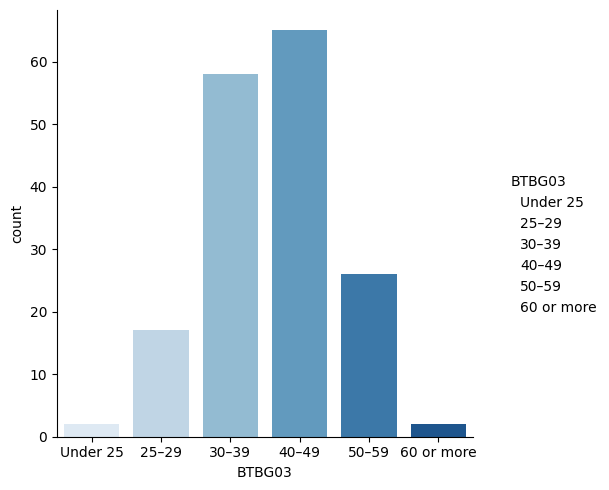

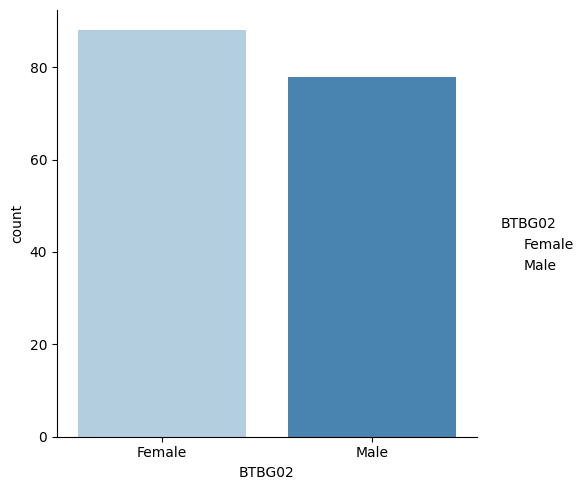

In [ ]:
# create an ordinal categorical variable for the age of the teacher
cat_type = CategoricalDtype(categories=['Under 25', '25–29', '30–39', '40–49', '50–59', '60 or more'], ordered=True)
# impute the age as the ordinal type created above
math_teach['BTBG03'] = math_teach['BTBG03'].astype(cat_type)

# graph the age distribution of math teachers in the data
sns.catplot(x='BTBG03', kind='count', palette='Blues', data=math_teach);
# graph the gender distribution of math teachers in the data
sns.catplot(x='BTBG02', kind='count', palette='Blues', data=math_teach);

sci_teach Data Preparation

In [ ]:
# explore basic structure of science teacher data
sci_teach.head()

IDCNTRY  IDSCHOOL    IDTEALIN   IDTEACH  IDLINK            ITCOURSE  \
0    414.0    5001.0  50010202.0  500102.0     2.0  Integrated science   
1    414.0    5002.0  50020202.0  500202.0     2.0  Integrated science   
2    414.0    5003.0  50030202.0  500302.0     2.0  Integrated science   
3    414.0    5004.0  50040202.0  500402.0     2.0  Integrated science   
4    414.0    5005.0  50050202.0  500502.0     2.0  Integrated science   

   BTBG01  BTBG02 BTBG03                                          BTBG04  \
0     6.0  Female  30–39  <Bachelor’s or equivalent level—ISCED Level 6>   
1    18.0    Male  40–49  <Bachelor’s or equivalent level—ISCED Level 6>   
2    18.0  Female  30–39    <Master’s or equivalent level—ISCED Level 7>   
3     5.0    Male  30–39  <Bachelor’s or equivalent level—ISCED Level 6>   
4    15.0  Female  40–49    <Master’s or equivalent level—ISCED Level 7>   

  BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G BTBG05H BTBG05I  \
0      No      No     Yes     Yes      No      No     Yes     NaN     NaN   
1      No      No     Yes     Yes      No      No      No      No      No   
2     NaN     Yes     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3      No      No      No     Yes      No      No      No      No      No   
4     Yes     Yes     Yes     Yes      No      No     Yes      No      No   

     BTBG06A    BTBG06B    BTBG06C BTBG06D BTBG06E BTBG06F    BTBG06G  \
0       High       High     Medium  Medium     Low     Low     Medium   
1  Very high  Very high       High    High  Medium  Medium       High   
2       High     Medium     Medium  Medium     Low     Low        Low   
3       High       High  Very high    High  Medium    High  Very high   
4       High       High       High    High  Medium  Medium       High   

     BTBG06H BTBG06I BTBG06J    BTBG06K    BTBG06L         BTBG07A  \
0     Medium  Medium     Low     Medium  Very high     Agree a lot   
1       High    High    High       High  Very high     Agree a lot   
2        Low  Medium  Medium     Medium     Medium  Agree a little   
3  Very high    High    High  Very high  Very high     Agree a lot   
4     Medium  Medium  Medium       High  Very high     Agree a lot   

          BTBG07B         BTBG07C         BTBG07D         BTBG07E  \
0     Agree a lot     Agree a lot  Agree a little  Agree a little   
1     Agree a lot     Agree a lot  Agree a little     Agree a lot   
2  Agree a little  Agree a little  Agree a little  Agree a little   
3     Agree a lot     Agree a lot     Agree a lot     Agree a lot   
4     Agree a lot     Agree a lot     Agree a lot     Agree a lot   

          BTBG07F         BTBG07G            BTBG07H     BTBG08A     BTBG08B  \
0  Agree a little  Agree a little  Disagree a little  Very often  Very often   
1  Agree a little     Agree a lot        Agree a lot  Very often  Very often   
2  Agree a little  Agree a little     Agree a little  Very often  Very often   
3     Agree a lot     Agree a lot        Agree a lot  Very often  Very often   
4     Agree a lot     Agree a lot     Agree a little  Very often  Very often   

      BTBG08C     BTBG08D     BTBG08E            BTBG09A            BTBG09B  \
0  Very often  Very often  Very often     Disagree a lot     Agree a little   
1  Very often  Very often  Very often  Disagree a little        Agree a lot   
2  Very often  Very often  Very often     Agree a little        Agree a lot   
3  Very often  Very often  Very often                NaN                NaN   
4  Very often  Very often  Very often  Disagree a little  Disagree a little   

             BTBG09C            BTBG09D         BTBG09E            BTBG09F  \
0     Agree a little  Disagree a little     Agree a lot     Agree a little   
1     Agree a little  Disagree a little     Agree a lot  Disagree a little   
2        Agree a lot        Agree a lot     Agree a lot     Agree a little   
3                NaN                NaN             NaN                NaN   
4  Disagree a lit

In [ ]:
# create a list of columns to drop (null or single unique value)
sci_teach_drop_new = list(sci_teach.columns[sci_teach.isna().all()])+list(sci_teach.columns[sci_teach.nunique()==1])
# add redundant languge column to be dropped
sci_teach_drop_new = sci_teach_drop_new + ['LCID_T']
# display contextual information for some of the data
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG' not in col],:].iloc[5:,:]

Label
Variable                                                   
ITCOURSE                         Subject Code in instrument
BTBS14                     SCI\TIME SPENT SCI INSTR MINUTES
BTBS15A                SCI\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBS15B                  SCI\ASK STUDENTS\OBSERVE PHENOMENA
BTBS15C             SCI\ASK STUDENTS\DEMONSTRATE EXPERIMENT
BTBS15D                   SCI\ASK STUDENTS\PLAN EXPERIMENTS
BTBS15E                SCI\ASK STUDENTS\CONDUCT EXPERIMENTS
BTBS15F                       SCI\ASK STUDENTS\PRESENT DATA
BTBS15G                     SCI\ASK STUDENTS\INTERPRET DATA
BTBS15H            SCI\ASK STUDENTS\USE EVIDENCE TO SUPPORT
BTBS15I                     SCI\ASK STUDENTS\READ TEXTBOOKS
BTBS15J                     SCI\ASK STUDENTS\MEMORIZE FACTS
BTBS15K                       SCI\ASK STUDENTS\USE FORMULAS
BTBS15L                      SCI\ASK STUDENTS\DO FIELD WORK
BTBS15M               SCI\ASK STUDENTS\MIXED ABILITY GROUPS
BTBS15N                SCI\ASK STUDENTS\SAME ABILITY GROUPS
BTBS16A         SCI\COMPUTER TABLET AVAILABILITY DURING SCI
BTBS16BA     SCI\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBS16BB         SCI\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBS16BC        SCI\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBS16CA        SCI\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBS16CB     SCI\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBS16CC    SCI\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBS16CD      SCI\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS
BTBS17AA         SCI\TOPIC\BIO\DIFFERENCES TAXONOMIC GROUPS
BTBS17AB                         SCI\TOPIC\BIO\MAJOR ORGANS
BTBS17AC             SCI\TOPIC\BIO\CELLS AND THEIR FUNCTION
BTBS17AD                         SCI\TOPIC\BIO\REPRODUCTION
BTBS17AE                    SCI\TOPIC\BIO\ROLE OF VARIATION
BTBS17AF        SCI\TOPIC\BIO\INTERDEPENDENCE OF POPULATION
BTBS17AG                         SCI\TOPIC\BIO\HUMAN HEALTH
BTBS17BA               SCI\TOPIC\CHEM\PARTICULATE STRUCTURE
BTBS17BB                      SCI\TOPIC\CHEM\PERIODIC TABLE
BTBS17BC            SCI\TOPIC\CHEM\PHY CHEM PROPERTY MATTER
BTBS17BD              SCI\TOPIC\CHEM\MIXTURES AND SOLUTIONS
BTBS17BE                     SCI\TOPIC\CHEM\ACIDS AND BASES
BTBS17BF                  SCI\TOPIC\CHEM\CHEMICAL REACTIONS
BTBS17BG                   SCI\TOPIC\CHEM\MATTER AND ENERGY
BTBS17BH                   SCI\TOPIC\CHEM\ROLE OF ELECTRONS
BTBS17CA                      SCI\TOPIC\PHY\PHYSICAL STATES
BTBS17CB                SCI\TOPIC\PHY\ENERGY TRANSFORMATION
BTBS17CC            SCI\TOPIC\PHY\BASIC PROPERTIES OF LIGHT
BTBS17CD            SCI\TOPIC\PHY\BASIC PROPERTIES OF SOUND
BTBS17CE                    SCI\TOPIC\PHY\ELECTRIC CIRCUITS
BTBS17CF                   SCI\TOPIC\PHY\PROPERTIES MAGNETS
BTBS17CG                    SCI\TOPIC\PHY\MOTION AND FORCES
BTBS17DA                   SCI\TOPIC\EARTH\EARTHS STRUCTURE
BTBS17DB                   SCI\TOPIC\EARTH\EARTHS PROCESSES
BTBS17DC                   SCI\TOPIC\EARTH\EARTHS RESOURCES
BTBS17DD              SCI\TOPIC\EARTH\EARTH IN SOLAR SYSTEM
BTBS18A                 SCI\HOW OFTEN SCI HOMEWORK ASSIGNED
BTBS18B                          SCI\TIME SPENT ON HOMEWORK
BTBS18CA                   SCI\HOMEWORK\CORRECT ASSIGNMENTS
BTBS18CB                  SCI\HOMEWORK\CORRECT OWN HOMEWORK
BTBS18CC                      SCI\HOMEWORK\DISCUSS HOMEWORK
BTBS18CD                  SCI\HOMEWORK\MONITOR COMPLETENESS
BTBS18CE                        SCI\HOMEWORK\USE FOR GRADES
BTBS19A        SCI\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBS19B           SCI\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBS19C         SCI\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBS19D              SCI\IMPORTANCE STRATEGIES\LONGER TESTS
BTBS19E        SCI\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS
BTBS20                     SCI\TESTS ON COMPUTER OR TABLETS
BTBS21AA          SCI\PROF DEVELOPMENT PAST\SCIENCE CONTENT
BTBS21BA        SCI\PROF DEVELOPMENT FUTURE\SCIENCE CONTENT
BTBS21AB         SCI\PROF DEVELOPM

<ipython-input-53-7e1f6bc8397d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x='BTBG03', kind='count', palette='Blues', data=sci_teach);
<ipython-input-53-7e1f6bc8397d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x='BTBG02', kind='count', palette='Blues', data=sci_teach);


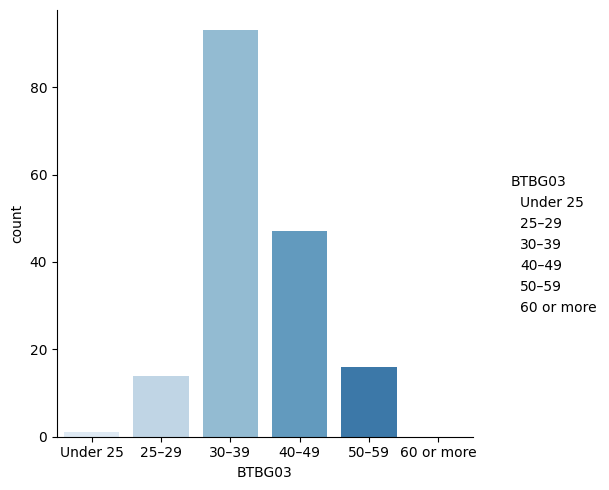

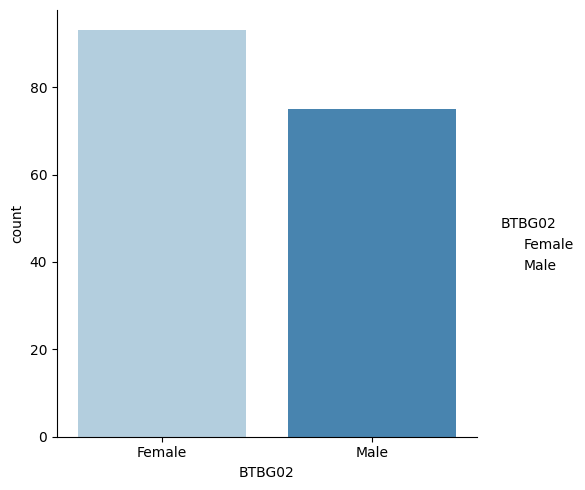

In [ ]:
# create an ordinal categorical varialge for age groups
cat_type = CategoricalDtype(categories=['Under 25', '25–29', '30–39', '40–49', '50–59', '60 or more'], ordered=True)
# apply ordinal categorical to age data
sci_teach['BTBG03'] = sci_teach['BTBG03'].astype(cat_type)

# graph the age distribution for science teachers
sns.catplot(x='BTBG03', kind='count', palette='Blues', data=sci_teach);
# graph the gender distribution for science teachers
sns.catplot(x='BTBG02', kind='count', palette='Blues', data=sci_teach);

# Data Preparation

# **stud_ach data preperation**

drop unnecessary columns

In [ ]:
# drop the null and single-value columns
stud_ach.drop(columns=stud_ach_drop_new, inplace=True)

print('LCID_SA' in stud_ach.columns)
#test
# check for no overlap between the dropped columns and the remaining columns
set(stud_ach_drop_new) & set(stud_ach.columns)

True


set()

convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers

In [ ]:
# convert each of the columns into integer type
stud_ach['IDSCHOOL'] = stud_ach['IDSCHOOL'].astype(int)
stud_ach['IDCLASS'] = stud_ach['IDCLASS'].astype(int)
stud_ach['IDSTUD'] = stud_ach['IDSTUD'].astype(int)

#test
# confirm change in datatype
stud_ach.dtypes[:10]

IDBOOK          object
IDSCHOOL         int64
IDCLASS          int64
IDSTUD           int64
ITLANG_SA       object
LCID_SA         object
ITSEX           object
BSDAGE         float64
MP52024_val    float64
MP52058_val    float64
dtype: object

trim and convert IDBOOK to integer

In [ ]:
# take only the digits from the strings and convert to integer
stud_ach['IDBOOK'] = stud_ach['IDBOOK'].apply(lambda x: x[-2:]).astype(int)

#test
# confirm change in datatype
stud_ach.dtypes[:10]

IDBOOK           int64
IDSCHOOL         int64
IDCLASS          int64
IDSTUD           int64
ITLANG_SA       object
LCID_SA         object
ITSEX           object
BSDAGE         float64
MP52024_val    float64
MP52058_val    float64
dtype: object

rename all columns to be more descriptive

In [ ]:
# create dictionary for renaming the columns
stud_ach_col_dict = {'ITLANG_SA':'language','ITSEX':'sex','BSDAGE':'age','IDBOOK':'test_book'}
# rename the columns
stud_ach.rename(columns=stud_ach_col_dict, inplace=True)

test

In [ ]:
# check all columns that are not assessment item scores, category averages or standard deviations
[col for col in stud_ach.columns if '_avg' not in col and '_val' not in col and '_sd' not in col]

['test_book',
 'IDSCHOOL',
 'IDCLASS',
 'IDSTUD',
 'language',
 'LCID_SA',
 'sex',
 'age']

**school data preperation**

Drop repetitive columns from the dataset

In [ ]:
# drop the null or single-value columns
school.drop(columns=school_drop_new,inplace=True)


#test
# verify dropped columns
set(school_drop_new) & set(school.columns)

set()

Convert  IDSCHOOL to integers

In [ ]:
school['IDSCHOOL'] = school['IDSCHOOL'].astype(int)

#test
# confirm change in datatype
school.dtypes[:5]

IDSCHOOL      int64
ITLANG_C     object
LCID_C       object
BCBGDAS     float64
BCBGEAS     float64
dtype: object

Convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals

In [ ]:
# create a list of all indices measuring school traits
school_indices = ['BCDGDAS', 'BCDGEAS', 'BCDGMRS', 'BCDGSRS', 'BCDGSBC']
# go through each of the indices
for col in school_indices:
    # print the contextual information for the index
    print(school_codes.loc[col,:])
    # print the unique values for the index
    print(school[col].unique())

Label    School Discipline Problems-Prncpl/IDX
Name: BCDGDAS, dtype: object
['Hardly Any Problems' 'Moderate to Severe Problems' 'Minor Problems' nan]
Label    School Emph on Acad Success-Prncpl/IDX
Name: BCDGEAS, dtype: object
['High Emphasis' 'Medium Emphasis' 'Very High Emphasis' nan]
Label    Instr Aff by Mat Res Shortage-Prncpl/IDX
Name: BCDGMRS, dtype: object
['Not Affected' 'Affected' 'Affected A Lot' nan]
Label    Instr Aff by Sci Res Shortage-Prncpl/IDX
Name: BCDGSRS, dtype: object
['Not Affected' 'Affected' 'Affected A Lot' nan]
Label    School Composition by Socioeconomic Background
Name: BCDGSBC, dtype: object
['More Affluent' 'More Disadvantaged'
 'Neither More Affluent nor More Disadvantaged' nan]


In [ ]:
# create an ordinal categorical variable for discipline problems
disc_prob_type = CategoricalDtype(categories=['Hardly Any Problems','Minor Problems','Moderate to Severe Problems'], ordered=True)
# create new column with ordinal type
school['disc_prob'] = school['BCDGDAS'].astype(disc_prob_type)
# create an ordinal categorical variable for academic emphasis
acad_emph_type = CategoricalDtype(categories=['Medium Emphasis', 'High Emphasis', 'Very High Emphasis'], ordered=True)
# create new column with ordinal type
school['acad_emph'] = school['BCDGEAS'].astype(acad_emph_type)
# create an ordinal categorical variable for affect of shortages
shortage_affect_type = CategoricalDtype(categories=['Not Affected', 'Affected', 'Affected A Lot'], ordered=True)
# create new columns with ordinal type
school['math_shortage'] = school['BCDGMRS'].astype(shortage_affect_type)
school['sci_shortage'] = school['BCDGSRS'].astype(shortage_affect_type)
# create an ordinal categorical variable for socioeconomic background
school_socio_type = CategoricalDtype(categories=['More Disadvantaged', 'Neither More Affluent nor More Disadvantaged', 'More Affluent'], ordered=True)
# create new column with ordinal type
school['socio_background'] = school['BCDGSBC'].astype(school_socio_type)
# drop the previous columns, leaving the ordinal columns
school.drop(columns=school_indices, inplace=True)

#test
# confirm datatypes
school.dtypes

IDSCHOOL               int64
ITLANG_C              object
LCID_C                object
BCBGDAS              float64
BCBGEAS              float64
BCBGMRS              float64
BCBGSRS              float64
BCDGTIHY             float64
disc_prob           category
acad_emph           category
math_shortage       category
sci_shortage        category
socio_background    category
dtype: object

rename all columns to be more descriptive

In [ ]:
# create a dictionary for renaming columns
school_col_dict = {'BCBGDAS':'disc_prob_score','BCBGEAS':'acad_emph_score','BCBGMRS':'math_shortage_score','BCBGSRS':'sci_shortage_score','BCDGTIHY':'acad_hours','ITLANG_C':'language'}
# rename columns
school.rename(columns=school_col_dict,inplace=True)

In [ ]:
#test
# confirm rename of columns
school.columns

Index(['IDSCHOOL', 'language', 'LCID_C', 'disc_prob_score', 'acad_emph_score',
       'math_shortage_score', 'sci_shortage_score', 'acad_hours', 'disc_prob',
       'acad_emph', 'math_shortage', 'sci_shortage', 'socio_background'],
      dtype='object')

merge with student performance by school

In [ ]:
# confirm student achievement data grouped by IDSCHOOL
stud_ach.groupby(['IDSCHOOL']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]]

<ipython-input-65-82f103000a39>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stud_ach.groupby(['IDSCHOOL']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]]


mmat_avg    ssci_avg
IDSCHOOL                        
5001      392.074387  471.470946
5002      375.797201  426.388215
5003      374.808830  433.782074
5004      359.653073  392.829613
5005      447.618648  437.947037
...              ...         ...
5169      372.726066  388.578071
5170      451.507537  528.061187
5171      499.882961  546.963878
5172      315.698223  324.754114
5173      389.651369  470.596677

[171 rows x 2 columns]

In [ ]:
school.describe()

IDSCHOOL  disc_prob_score  acad_emph_score  math_shortage_score  \
count   171.000000       170.000000        170.00000           170.000000   
mean   5086.988304         9.242698         10.23985             8.965273   
std      50.209677         2.174274          1.89808             2.129120   
min    5001.000000         4.100070          5.37607             4.234860   
25%    5043.500000         7.698488          9.26475             7.871450   
50%    5087.000000         9.512790         10.15969             8.956180   
75%    5130.500000        10.801360         11.65536            10.026720   
max    5173.000000        14.028580         16.36222            14.255960   

       sci_shortage_score   acad_hours  
count          170.000000   141.000000  
mean             8.985884   977.300827  
std              2.222242   248.904300  
min              4.076240   567.000000  
25%              7.663790   813.750000  
50%              8.869125   933.333330  
75%             10.176560  1050.000000  
max             14.572410  2025.000000

In [ ]:
# confirm school data indexed by  IDSCHOOL
school.set_index(['IDSCHOOL'])

language            LCID_C  disc_prob_score  acad_emph_score  \
IDSCHOOL                                                                
5001       Arabic   Arabic (Kuwait)         14.02858         11.06274   
5002       Arabic   Arabic (Kuwait)          6.02711         10.46161   
5003       Arabic   Arabic (Kuwait)         11.19421         10.15969   
5004       Arabic   Arabic (Kuwait)         10.80136          6.24903   
5005      English  English (Kuwait)         10.43939         11.35999   
...           ...               ...              ...              ...   
5169       Arabic   Arabic (Kuwait)          6.64118          7.73586   
5170       Arabic   Arabic (Kuwait)         10.80136         11.08787   
5171       Arabic   Arabic (Kuwait)          7.53896         11.65536   
5172       Arabic   Arabic (Kuwait)          9.51279          9.56054   
5173       Arabic   Arabic (Kuwait)         12.80218         10.76309   

          math_shortage_score  sci_shortage_score  acad_hours  \
IDSCHOOL                                                        
5001                 12.92960            14.57241      761.25   
5002                 12.29366            12.05633     1113.00   
5003                 10.08629            10.17656         NaN   
5004                  9.73618             9.80545         NaN   
5005                  8.44578             8.44672     1098.00   
...                       ...                 ...         ...   
5169                  9.62794             9.25352      997.50   
5170                  6.98745             5.47004      866.25   
5171                  8.73229             8.57396      724.50   
5172                  9.52239             9.46956     1050.00   
5173                 10.08629            10.45776      880.00   

                            disc_prob        acad_emph   math_shortage  \
IDSCHOOL                                                                 
5001              Hardly Any Problems    High Emphasis    Not Affected   
5002      Moderate to Severe Problems    High Emphasis    Not Affected   
5003              Hardly Any Problems    High Emphasis        Affected   
5004              Hardly Any Problems  Medium Emphasis        Affected   
5005                   Minor Problems    High Emphasis        Affected   
...                               ...              ...             ...   
5169      Moderate to Severe Problems  Medium Emphasis        Affected   
5170              Hardly Any Problems    High Emphasis  Affected A Lot   
5171      Moderate to Severe Problems    High Emphasis        Affected   
5172                   Minor Problems  Medium Emphasis        Affected   
5173              Hardly Any Problems    High Emphasis        Affected   

            sci_shortage                              socio_background  
IDSCHOOL                                                                
5001        Not Affected                                 More Affluent  
5002        Not Affected                            More Disadvantaged  
5003            Affected  Neither More Affluent nor More Disadvantaged  
5004            Affected                            More Disadvantaged  
5005            Affected  Neither More Affluent nor More Disadvantaged  
...                  ...                                           ...  
5169            Affected                                 More Affluent  
5170      Affected A Lot  Neither More Affluent nor More Disadvantaged  
5171            Affected                                 More Affluent  
5172            Affected                                 More Affluent  
5173            Affected                            More Disadvantaged  

[171 rows x 12 columns]

In [ ]:
# combine the student achievement data to the school dataframe
school = school.set_index(['IDSCHOOL']).join(stud_ach.groupby(['IDSCHOOL']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#test
# confirm that school dataframe now has assessment columns
school.columns

<ipython-input-68-18a8e6f263b2>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  school = school.set_index(['IDSCHOOL']).join(stud_ach.groupby(['IDSCHOOL']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()


Index(['IDSCHOOL', 'language', 'LCID_C', 'disc_prob_score', 'acad_emph_score',
       'math_shortage_score', 'sci_shortage_score', 'acad_hours', 'disc_prob',
       'acad_emph', 'math_shortage', 'sci_shortage', 'socio_background',
       'mmat_avg', 'ssci_avg'],
      dtype='object')

# **student data preparation**

drop unnecessary columns

In [ ]:
student_drop_new = student_drop_new + ['LCID_SQ','ITLANG_SA','LCID_SA']
student.drop(columns=student_drop_new, inplace=True)

#test
# confirm columns dropped
set(student_drop_new) & set(student.columns)

set()

convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
trim and convert IDBOOK to integers

In [ ]:
student[['IDSCHOOL','IDCLASS','IDSTUD']] = student[['IDSCHOOL','IDCLASS','IDSTUD']].astype(int)
# take the digits from IDBOOK
student['IDBOOK'] = student['IDBOOK'].apply(lambda x: x[-2:]).astype(int)

#test
# confirm change in datatypes
student[['IDSCHOOL','IDCLASS','IDSTUD','IDBOOK']].dtypes

IDSCHOOL    int64
IDCLASS     int64
IDSTUD      int64
IDBOOK      int64
dtype: object

convert to integer and combine BSBG05* columns to home_possession column
convert to integer and combine BSBG12* columns to internet_access column

In [ ]:
# dictionary for creating the new combined columns
conv_col = {'BSBG05':'home_possession','BSBG12':'internet_access'}
# go through each set of columns
for base_col in conv_col.keys():
    # gather the list of all columns matching the prefix
    all_cols = [col for col in student.columns if base_col in col]
    # go through each matching column
    for i, single_col in enumerate(all_cols):
        # if it is is the first column
        if i == 0:
            # create the new column with 1 for Yes, 0 for No, or NaN for null
            student[conv_col[base_col]] = student[single_col].apply(lambda x: np.nan if x!=x else int(x=='Yes')).astype(float)
        # otherwise, add any subsequent values to the previous sum
        else:
            # add any subsequent values to the previous sum (1 for Yes, 0 for No, or NaN for null)
            student[conv_col[base_col]] = student[conv_col[base_col]] + student[single_col].apply(lambda x: np.nan if x!=x else int(x=='Yes')).astype(float)
    # drop all matching columns for the new combined columns
    student.drop(columns=all_cols, inplace=True)

#test
# confirm new columns
student.columns

Index(['IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'BSBG03', 'BSBG04',
       'BSBG06A', 'BSBG06B', 'BSBG07', 'BSBG08A', 'BSBG08B', 'BSBG09A',
       'BSBG09B', 'BSBG10', 'BSBG11A', 'BSBG11B', 'ITLANG_SQ', 'ITSEX',
       'BSDAGE', 'BSBGHER', 'BSDGHER', 'BSBGSSB', 'BSDGSSB', 'BSBGSB',
       'BSDGSB', 'BSBGSLM', 'BSDGSLM', 'BSBGICM', 'BSDGICM', 'BSBGDML',
       'BSDGDML', 'BSBGSCM', 'BSDGSCM', 'BSBGSVM', 'BSDGSVM', 'BSBGSLS',
       'BSDGSLS', 'BSBGICS', 'BSDGICS', 'BSBGSCS', 'BSDGSCS', 'BSBGSVS',
       'BSDGSVS', 'BSDG05S', 'BSDGEDUP', 'home_possession', 'internet_access'],
      dtype='object')

In [ ]:
# confirm datatypes
student[['home_possession','internet_access']].dtypes

home_possession    float64
internet_access    float64
dtype: object

convert to string and combine BSBG09* columns to ordered categorical age_immigration column

In [ ]:
# print the different values for each BSBG09 column
for col in [col for col in student.columns if 'BSBG09' in col]:
    print(student[col].unique())

['Yes' 'No' nan]
[nan 'Younger than 5 years old' '5 to 10 years old'
 'Older than 10 years old']


In [ ]:
def age_immigration_col(x):
    '''
    combines both immigration columns into a single values

    INPUT:
    x - (list with two values)   Yes/No for born in country
                                 Age range when immigrated in country

    OUTPUT:
    a value representing age range when immigrated ('Birth' for born in country)
    '''
    # if born in country, return 'Birth'
    if x[0] == 'Yes':
        return('Birth')
    # otherwise, return age range of immigration
    else:
        return(x[1])

In [ ]:

# use the age_immigration_col function to combine the two immigration columns
student['age_immigration'] = student[['BSBG09A','BSBG09B']].apply(age_immigration_col, axis = 1)
# delete the previous immigration columns
student.drop(columns=['BSBG09A','BSBG09B'], inplace=True)


# create ordinal categorical type for immigration age
immigration_type = CategoricalDtype(categories=['Birth','Younger than 5 years old','5 to 10 years old', 'Older than 10 years old'], ordered=True)
student['age_immigration'] = student['age_immigration'].astype(immigration_type)


#test
# confirm change in datatype
student[[col for col in student.columns if 'BSBG09' in col or 'immigration' in col]].dtypes

age_immigration    category
dtype: object

convert BSBG03, BSBG04, BSBG10, BSBG11, BSDG columns to ordered categoricals

In [ ]:
# print the context label and unique values for each column matching the column prefixes
new_cat_cols = ['BSBG03', 'BSBG04', 'BSBG10', 'BSBG11', 'BSDG']
for col_root in new_cat_cols:
    for col in student.columns:
        if col_root in col:
            print(student[col].unique())
            print(student_codes.loc[col,:])

['Always' 'Sometimes' 'Never' 'Almost always' nan]
Label    GEN\OFTEN SPEAK <LANG OF TEST> AT HOME
Name: BSBG03, dtype: object
['Enough to fill three or more bookcases (more than 200)'
 'None or very few (0–10 books)' 'Enough to fill one shelf (11–25 books)'
 'Enough to fill one bookcase (26–100 books)' nan
 'Enough to fill two bookcases (101–200 books)']
Label    GEN\AMOUNT OF BOOKS IN YOUR HOME
Name: BSBG04, dtype: object
['Never or almost never' 'Once a month' 'Once every two weeks'
 'Once a week' nan 'Once every two month']
Label    GEN\ABOUT HOW OFTEN ABSENT FROM SCHOOL
Name: BSBG10, dtype: object
['Almost every day' 'Sometimes' 'Every day' nan 'Never']
Label    GEN\HOW OFTEN\TIRED
Name: BSBG11A, dtype: object
['Sometimes' 'Every day' 'Almost every day' 'Never' nan]
Label    GEN\HOW OFTEN\HUNGRY
Name: BSBG11B, dtype: object
['Some Resources' 'Few Resources' 'Many Resources' nan]
Label    Home Educational Resources/IDX
Name: BSDGHER, dtype: object
['Some Sense of School Belonging' 

In [ ]:
# create a blank dictionary to store all of the changes to the columns summarized above
info = {}
# each entry in the dictionary contains the column prefix as the key, then a new name for the column, then the ordinal values of the categories
info['BSBG03'] = {'new_name':'acad_lang_home','ordered_cols':['Never','Sometimes','Almost always','Always']}
info['BSBG04'] = {'new_name':'books','ordered_cols':['None or very few (0–10 books)','Enough to fill one shelf (11–25 books)',
                                                     'Enough to fill one bookcase (26–100 books)','Enough to fill two bookcases (101–200 books)',
                                                     'Enough to fill three or more bookcases (more than 200)']}
info['BSBG10'] = {'new_name':'absent_freq','ordered_cols':['Never or almost never','Once every two month','Once a month','Once every two weeks','Once a week']}
info['BSBG11A'] = {'new_name':'tired_freq','ordered_cols':['Never','Sometimes','Almost every day','Every day']}
info['BSBG11B'] = {'new_name':'hungry_freq','ordered_cols':['Never','Sometimes','Almost every day','Every day']}
info['BSDGHER'] = {'new_name':'home_res','ordered_cols':['Few Resources','Some Resources','Many Resources']}
info['BSDGSSB'] = {'new_name':'belonging','ordered_cols':['Little Sense of School Belonging','Some Sense of School Belonging','High Sense of School Belonging']}
info['BSDGSB'] = {'new_name':'bullying','ordered_cols':['Never or Almost Never','About Monthly','About Weekly']}
info['BSDGSLM'] = {'new_name':'like_math','ordered_cols':['Do Not Like Learning Mathematics','Somewhat Like Learning Mathematics','Very Much Like Learning Mathematics']}
info['BSDGICM'] = {'new_name':'clear_math','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGDML'] = {'new_name':'disorder_math','ordered_cols':['Few or No Lessons','Some Lessons','Most Lessons']}
info['BSDGSCM'] = {'new_name':'confident_math','ordered_cols':['Not Confident in Mathematics','Somewhat Confident in Mathematics','Very Confident in Mathematics']}
info['BSDGSVM'] = {'new_name':'value_math','ordered_cols':['Do Not Value Mathematics','Somewhat Value Mathematics','Strongly Value Mathematics']}
info['BSDGSLS'] = {'new_name':'like_science','ordered_cols':['Do Not Like Learning Science','Somewhat Like Learning Science','Very Much Like Learning Science']}
info['BSDGICS'] = {'new_name':'clear_science','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCS'] = {'new_name':'confident_science','ordered_cols':['Not Confident in Science','Somewhat Confident in Science','Very Confident in Science']}
info['BSDGSVS'] = {'new_name':'value_science','ordered_cols':['Do Not Value Science','Somewhat Value Science','Strongly Value Science']}
info['BSDGSLB'] = {'new_name':'like_bio','ordered_cols':['Do Not Like Learning Biology','Somewhat Like Learning Biology','Very Much Like Learning Biology']}
info['BSDGICB'] = {'new_name':'clear_bio','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCB'] = {'new_name':'confident_bio','ordered_cols':['Not Confident in Biology','Somewhat Confident in Biology','Very Confident in Biology']}
info['BSDGSLE'] = {'new_name':'like_earth','ordered_cols':['Do Not Like Learning Earth Science','Somewhat Like Learning Earth Science','Very Much Like Learning Earth Science']}
info['BSDGICE'] = {'new_name':'clear_earth','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCE'] = {'new_name':'confident_earth','ordered_cols':['Not Confident in Earth Science','Somewhat Confident in Earth Science','Very Confident in Earth Science']}
info['BSDGSLC'] = {'new_name':'like_chem','ordered_cols':['Do Not Like Learning Chemistry','Somewhat Like Learning Chemistry','Very Much Like Learning Chemistry']}
info['BSDGICC'] = {'new_name':'clear_chem','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCC'] = {'new_name':'confident_chem','ordered_cols':['Not Confident in Chemistry','Somewhat Confident in Chemistry','Very Confident in Chemistry']}
info['BSDGSLP'] = {'new_name':'like_phys','ordered_cols':['Do Not Like Learning Physics','Somewhat Like Learning Physics','Very Much Like Learning Physics']}
info['BSDGICP'] = {'new_name':'clear_phys','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCP'] = {'new_name':'confident_phys','ordered_cols':['Not Confident in Physics','Somewhat Confident in Physics','Very Confident in Physics']}
info['BSDGSEC'] = {'new_name':'confident_computer','ordered_cols':['Low Self-Efficacy','Medium Self-Efficacy','High Self-Efficacy']}
info['BSDG05S'] = {'new_name':'study_support','ordered_cols':['Neither Own Room nor Internet Connection','Either Own Room or Internet Connection','Both Own Room and Internet Connection']}
info['BSDGEDUP'] = {'new_name':'','ordered_cols':['Some Primary, Lower Secondary or No School',
                                                 'Lower Secondary','Upper Secondary','Post-secondary but not University',
                                                 'University or Higher']}

In [ ]:
# go through each item in the dictionary above
for item in info.keys():
    # create the ordinal categorical type with the respective values
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # apply the new type to the column
    if item in student.columns:
      student[item] = student[item].astype(cat_type)
    # rename the column to new name
      student.rename(columns={item:info[item]['new_name']},inplace=True)

In [ ]:
# investigate the datatypes of the new columns (by sampling 10 lowercase columns)
student.loc[:,[col for col in student.columns if col.islower()]].dtypes.sample(10)

disorder_math      category
home_possession     float64
internet_access     float64
acad_lang_home     category
like_math          category
absent_freq        category
bullying           category
clear_science      category
books              category
belonging          category
dtype: object

In [ ]:
# verify the ordinal categorical of a randomly selected column
student[random.choice([col for col in student.columns if col.islower()])].unique()

array([ 4.,  5.,  3.,  6.,  1., nan,  2.,  0.])

trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)

In [ ]:
# check the context info for the column
student_codes.loc['BSBG06A']

Label    GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN A>
Name: BSBG06A, dtype: object

In [ ]:
def edu_level(val):
    '''
    translates educational level into standard ISCED Level output

    INPUT:
    val - (str) a string containing educational information, description, and ISCED Level

    OUTPUT:
    a string representing the respective ISCED Level of education
    '''
    try:
        # if the string contains a digit
        level = re.search('[0-9]',val).group(0)
        # return the respective ISCED Level
        return 'ISCED Level '+level
    except:
        # otherwise, return NaN
        return np.NaN

In [ ]:
# create three new educational columns by applying edu_level function
student['parent_edu_1'] = student['BSBG06A'].apply(edu_level)
student['parent_edu_2'] = student['BSBG06B'].apply(edu_level)
student['desired_edu'] = student['BSBG07'].apply(edu_level)
# drop the previous columns
student.drop(columns=['BSBG06A', 'BSBG06B', 'BSBG07'],inplace=True)

In [ ]:
# use the unique entries of education to create a list
edu_list = list(filter(lambda x: str(x) != 'nan',student['parent_edu_1'].unique()))
# sort the list
edu_list.sort()
# use the sorted list to create an ordinal category
edu_type = CategoricalDtype(categories=edu_list, ordered=True)
# apply the ordinal category to the three educational variables
student['parent_edu_1'] = student['parent_edu_1'].astype(edu_type)
student['parent_edu_2'] = student['parent_edu_2'].astype(edu_type)
student['desired_edu'] = student['desired_edu'].astype(edu_type)

#test
# test that all educaitonal columns are now ordinal
for col in [col for col in student.columns if '_edu' in col]:
    print(student.loc[:,col].unique())

[NaN, 'ISCED Level 6', 'ISCED Level 4', 'ISCED Level 7', 'ISCED Level 3', 'ISCED Level 2', 'ISCED Level 1', 'ISCED Level 5']
Categories (7, object): ['ISCED Level 1' < 'ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' <
                         'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']
[NaN, 'ISCED Level 6', 'ISCED Level 4', 'ISCED Level 3', 'ISCED Level 5', 'ISCED Level 1', 'ISCED Level 7', 'ISCED Level 2']
Categories (7, object): ['ISCED Level 1' < 'ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' <
                         'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']
['ISCED Level 5', 'ISCED Level 7', 'ISCED Level 6', 'ISCED Level 3', 'ISCED Level 4', 'ISCED Level 2', NaN]
Categories (7, object): ['ISCED Level 1' < 'ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' <
                         'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']


convert BSBG08* to float

In [ ]:
def immig_status(val):
    '''
    makes immigration status into binary value

    INPUT:
    val - (str)   Yes/No/NaN

    OUTPUT:
    a binary integer value representing immigration status
    '''
    if val == "Yes":
        return 1
    elif val == "No":
        return 0
    else:
        return np.nan

In [ ]:
# create an immigration status column for each parent by apply immig_status function
student['parent_immig_1'] = student['BSBG08A'].apply(immig_status)
student['parent_immig_2'] = student['BSBG08B'].apply(immig_status)
# delete previous two columns
student.drop(columns=['BSBG08A','BSBG08B'],inplace=True)

In [ ]:
# verify valid values in the immigration status
student['parent_immig_1'].unique()

array([ 1.,  0., nan])

rename all columns to be more descriptive

In [ ]:
# generate a list of columns that are not yet lowercase (have not yet been renamed)
str(list([col for col in student.columns if not col.islower()]))

"['IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'ITLANG_SQ', 'ITSEX', 'BSDAGE', 'BSBGHER', 'BSBGSSB', 'BSBGSB', 'BSBGSLM', 'BSBGICM', 'BSBGDML', 'BSBGSCM', 'BSBGSVM', 'BSBGSLS', 'BSBGICS', 'BSBGSCS', 'BSBGSVS', '']"

In [ ]:
# create a dictionary to rename columns with more descriptive names
student_col_dict = {'ITLANG_SQ':'language',
                     'ITSEX':'sex',
                     'BSDAGE':'age',
                     'IDBOOK':'test_book',
                    'BSBGHER':'home_res_score',
                    'BSBGSSB':'belonging_score',
                    'BSBGSB':'bullying_score',
                    'BSBGSLM':'like_math_score',
                    'BSBGICM':'clear_math_score',
                    'BSBGDML':'disorder_math_score',
                    'BSBGSCM':'confident_math_score',
                    'BSBGSVM':'value_math_score',
                    'BSBGSLS':'like_science_score',
                    'BSBGICS':'clear_science_score',
                    'BSBGSCS':'confident_science_score',
                    'BSBGSVS':'value_science_score',
                    'BSBGSLB':'like_bio_score',
                    'BSBGICB':'clear_bio_score',
                    'BSBGSCB':'confident_bio_score',
                    'BSBGSLE':'like_earth_score',
                    'BSBGICE':'clear_earth_score',
                    'BSBGSCE':'confident_earth_score',
                    'BSBGSLC':'like_chem_score',
                    'BSBGICC':'clear_chem_score',
                    'BSBGSCC':'confident_chem_score',
                    'BSBGSLP':'like_phys_score',
                    'BSBGICP':'clear_phys_score',
                    'BSBGSCP':'confident_phys_score',
                    'BSBGSEC':'confident_computer_score',
                    '':'parent_edu_max'}
# rename the columns
student.rename(columns=student_col_dict, inplace=True)

In [ ]:
unique_values = student['parent_edu_max'].unique()
print(unique_values)


[NaN, 'University or Higher', 'Post-secondary but not University', 'Upper Secondary', 'Lower Secondary', 'Some Primary, Lower Secondary or No School']
Categories (5, object): ['Some Primary, Lower Secondary or No School' < 'Lower Secondary' < 'Upper Secondary' <
                         'Post-secondary but not University' < 'University or Higher']


In [ ]:
# verify renamed columns
student.columns

Index(['test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'acad_lang_home', 'books',
       'absent_freq', 'tired_freq', 'hungry_freq', 'language', 'sex', 'age',
       'home_res_score', 'home_res', 'belonging_score', 'belonging',
       'bullying_score', 'bullying', 'like_math_score', 'like_math',
       'clear_math_score', 'clear_math', 'disorder_math_score',
       'disorder_math', 'confident_math_score', 'confident_math',
       'value_math_score', 'value_math', 'like_science_score', 'like_science',
       'clear_science_score', 'clear_science', 'confident_science_score',
       'confident_science', 'value_science_score', 'value_science',
       'study_support', 'parent_edu_max', 'home_possession', 'internet_access',
       'age_immigration', 'parent_edu_1', 'parent_edu_2', 'desired_edu',
       'parent_immig_1', 'parent_immig_2'],
      dtype='object')

merge with student performance

In [ ]:
# check first 8 columns in student dataframe
student.columns[:8]

Index(['test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'acad_lang_home', 'books',
       'absent_freq', 'tired_freq'],
      dtype='object')

In [ ]:
student.shape

(4574, 46)

In [ ]:
# check first 8 columns in stud_ach dataframe
stud_ach.columns[:8]

Index(['test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'language', 'LCID_SA',
       'sex', 'age'],
      dtype='object')

In [ ]:
stud_ach.shape

(4574, 397)

In [ ]:
# combine the assessment data to the student dataframe
student = student.set_index(['IDSCHOOL','IDCLASS','IDSTUD']).join(stud_ach.set_index(['IDSCHOOL','IDCLASS','IDSTUD']).loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#Test
# verify that the student dataframe now contains assessment data
student.head()

IDSCHOOL  IDCLASS    IDSTUD  test_book acad_lang_home  \
0      5001   500101  50010101         13         Always   
1      5001   500101  50010102         14      Sometimes   
2      5001   500101  50010104          2         Always   
3      5001   500101  50010105          3      Sometimes   
4      5001   500101  50010106          4         Always   

                                               books            absent_freq  \
0  Enough to fill three or more bookcases (more t...  Never or almost never   
1                      None or very few (0–10 books)           Once a month   
2             Enough to fill one shelf (11–25 books)  Never or almost never   
3                      None or very few (0–10 books)   Once every two weeks   
4         Enough to fill one bookcase (26–100 books)  Never or almost never   

         tired_freq       hungry_freq language     sex    age  home_res_score  \
0  Almost every day         Sometimes   Arabic  Female  13.83        12.04797   
1         Sometimes         Sometimes   Arabic  Female  13.42        10.23835   
2  Almost every day         Every day   Arabic  Female  13.42         9.64761   
3         Sometimes  Almost every day   Arabic  Female  13.17         9.64761   
4         Sometimes  Almost every day   Arabic  Female  13.83        10.84499   

         home_res  belonging_score                         belonging  \
0  Some Resources         10.00496    Some Sense of School Belonging   
1  Some Resources          8.46096    Some Sense of School Belonging   
2  Some Resources          7.73555  Little Sense of School Belonging   
3  Some Resources         10.00496    Some Sense of School Belonging   
4  Some Resources         10.70956    High Sense of School Belonging   

   bullying_score               bullying  like_math_score  \
0         9.28593  Never or Almost Never          9.31385   
1        11.18784  Never or Almost Never          8.76139   
2         9.28593  Never or Almost Never          7.13627   
3         9.28593  Never or Almost Never          9.24754   
4         7.34528          About Monthly          8.76139   

                          like_math  clear_math_score  \
0  Do Not Like Learning Mathematics           9.92675   
1  Do Not Like Learning Mathematics           9.52219   
2  Do Not Like Learning Mathematics           7.73983   
3  Do Not Like Learning Mathematics           9.92675   
4  Do Not Like Learning Mathematics           7.73983   

                        clear_math  disorder_math_score disorder_math  \
0  Moderate Clarity of Instruction              8.70559  Some Lessons   
1  Moderate Clarity of Instruction             10.31153  Some Lessons   
2       Low Clarity of Instruction              9.45061  Some Lessons   
3  Moderate Clarity of Instruction              9.45061  Some Lessons   
4       Low Clarity of Instruction              7.41866  Most Lessons   

   confident_math_score                     confident_math  value_math_score  \
0               9.67230  Somewhat Confident in Mathematics          10.77308   
1              11.75008  Somewhat Confident in Mathematics           9.35676   
2               9.67230  Somewhat Confident in Mathematics           8.12441   
3              10.08761  Somewhat Confident in Mathematics           9.37615   
4               5.90622       Not Confident in Mathematics           9.08085   

                   value_math  like_science_score  \
0  Strongly Value Mathematics            13.51778   
1  Somewhat Value Mathematics            12.19630   
2  Somewhat Value Mathematics            11.06414   
3  Somewhat Value Mathematics            11.06414   
4  Somewhat Value Mathematics            11.53300   

                      like_science  clear_science_score  \
0  Very Much Like Learning Science             11.43106   
1  Very Much Like Learning Science             12.63386   
2  Very Much Like Learning Science             12.63386   
3  Very Much Like Learning Science             11.43106   
4  

In [ ]:
student.shape

(4574, 48)

# Data Modeling

Regression model

In [ ]:
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4574 entries, 0 to 4573
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   IDSCHOOL                 4574 non-null   int64   
 1   IDCLASS                  4574 non-null   int64   
 2   IDSTUD                   4574 non-null   int64   
 3   test_book                4574 non-null   int64   
 4   acad_lang_home           4487 non-null   category
 5   books                    4469 non-null   category
 6   absent_freq              4457 non-null   category
 7   tired_freq               4417 non-null   category
 8   hungry_freq              4232 non-null   category
 9   language                 4533 non-null   object  
 10  sex                      4574 non-null   object  
 11  age                      4570 non-null   float64 
 12  home_res_score           4485 non-null   float64 
 13  home_res                 4485 non-null   category
 14  belongin

In [ ]:
mean_value = student['ssci_avg'].mean()
print(mean_value)


443.20308226191514


In [ ]:
mean_value = student['mmat_avg'].mean()
print(mean_value)


400.599205058592


In [ ]:
# investigate possible sources of regression inputs in the student dataset
student.columns

Index(['IDSCHOOL', 'IDCLASS', 'IDSTUD', 'test_book', 'acad_lang_home', 'books',
       'absent_freq', 'tired_freq', 'hungry_freq', 'language', 'sex', 'age',
       'home_res_score', 'home_res', 'belonging_score', 'belonging',
       'bullying_score', 'bullying', 'like_math_score', 'like_math',
       'clear_math_score', 'clear_math', 'disorder_math_score',
       'disorder_math', 'confident_math_score', 'confident_math',
       'value_math_score', 'value_math', 'like_science_score', 'like_science',
       'clear_science_score', 'clear_science', 'confident_science_score',
       'confident_science', 'value_science_score', 'value_science',
       'study_support', 'parent_edu_max', 'home_possession', 'internet_access',
       'age_immigration', 'parent_edu_1', 'parent_edu_2', 'desired_edu',
       'parent_immig_1', 'parent_immig_2', 'mmat_avg', 'ssci_avg'],
      dtype='object')

In [ ]:
student.head()

IDSCHOOL  IDCLASS    IDSTUD  test_book acad_lang_home  \
0      5001   500101  50010101         13         Always   
1      5001   500101  50010102         14      Sometimes   
2      5001   500101  50010104          2         Always   
3      5001   500101  50010105          3      Sometimes   
4      5001   500101  50010106          4         Always   

                                               books            absent_freq  \
0  Enough to fill three or more bookcases (more t...  Never or almost never   
1                      None or very few (0–10 books)           Once a month   
2             Enough to fill one shelf (11–25 books)  Never or almost never   
3                      None or very few (0–10 books)   Once every two weeks   
4         Enough to fill one bookcase (26–100 books)  Never or almost never   

         tired_freq       hungry_freq language     sex    age  home_res_score  \
0  Almost every day         Sometimes   Arabic  Female  13.83        12.04797   
1         Sometimes         Sometimes   Arabic  Female  13.42        10.23835   
2  Almost every day         Every day   Arabic  Female  13.42         9.64761   
3         Sometimes  Almost every day   Arabic  Female  13.17         9.64761   
4         Sometimes  Almost every day   Arabic  Female  13.83        10.84499   

         home_res  belonging_score                         belonging  \
0  Some Resources         10.00496    Some Sense of School Belonging   
1  Some Resources          8.46096    Some Sense of School Belonging   
2  Some Resources          7.73555  Little Sense of School Belonging   
3  Some Resources         10.00496    Some Sense of School Belonging   
4  Some Resources         10.70956    High Sense of School Belonging   

   bullying_score               bullying  like_math_score  \
0         9.28593  Never or Almost Never          9.31385   
1        11.18784  Never or Almost Never          8.76139   
2         9.28593  Never or Almost Never          7.13627   
3         9.28593  Never or Almost Never          9.24754   
4         7.34528          About Monthly          8.76139   

                          like_math  clear_math_score  \
0  Do Not Like Learning Mathematics           9.92675   
1  Do Not Like Learning Mathematics           9.52219   
2  Do Not Like Learning Mathematics           7.73983   
3  Do Not Like Learning Mathematics           9.92675   
4  Do Not Like Learning Mathematics           7.73983   

                        clear_math  disorder_math_score disorder_math  \
0  Moderate Clarity of Instruction              8.70559  Some Lessons   
1  Moderate Clarity of Instruction             10.31153  Some Lessons   
2       Low Clarity of Instruction              9.45061  Some Lessons   
3  Moderate Clarity of Instruction              9.45061  Some Lessons   
4       Low Clarity of Instruction              7.41866  Most Lessons   

   confident_math_score                     confident_math  value_math_score  \
0               9.67230  Somewhat Confident in Mathematics          10.77308   
1              11.75008  Somewhat Confident in Mathematics           9.35676   
2               9.67230  Somewhat Confident in Mathematics           8.12441   
3              10.08761  Somewhat Confident in Mathematics           9.37615   
4               5.90622       Not Confident in Mathematics           9.08085   

                   value_math  like_science_score  \
0  Strongly Value Mathematics            13.51778   
1  Somewhat Value Mathematics            12.19630   
2  Somewhat Value Mathematics            11.06414   
3  Somewhat Value Mathematics            11.06414   
4  Somewhat Value Mathematics            11.53300   

                      like_science  clear_science_score  \
0  Very Much Like Learning Science             11.43106   
1  Very Much Like Learning Science             12.63386   
2  Very Much Like Learning Science             12.63386   
3  Very Much Like Learning Science             11.43106   
4  

In [ ]:
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4574 entries, 0 to 4573
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   IDSCHOOL                 4574 non-null   int64   
 1   IDCLASS                  4574 non-null   int64   
 2   IDSTUD                   4574 non-null   int64   
 3   test_book                4574 non-null   int64   
 4   acad_lang_home           4487 non-null   category
 5   books                    4469 non-null   category
 6   absent_freq              4457 non-null   category
 7   tired_freq               4417 non-null   category
 8   hungry_freq              4232 non-null   category
 9   language                 4533 non-null   object  
 10  sex                      4574 non-null   object  
 11  age                      4570 non-null   float64 
 12  home_res_score           4485 non-null   float64 
 13  home_res                 4485 non-null   category
 14  belongin

In [ ]:
print(student.desired_edu.unique())

['ISCED Level 5', 'ISCED Level 7', 'ISCED Level 6', 'ISCED Level 3', 'ISCED Level 4', 'ISCED Level 2', NaN]
Categories (7, object): ['ISCED Level 1' < 'ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' <
                         'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']


In [ ]:
# select the subset of characteristics for the regression
student_sub_set = student[['acad_lang_home', 'absent_freq','tired_freq','sex',
                           'bullying','like_math',  'clear_math',
                           'disorder_math', 'confident_math',  'value_math',
                           'like_science',  'clear_science','confident_science',  'value_science','study_support',
                           'parent_edu_max', 'internet_access',
                           'desired_edu',
                           'parent_immig_1', 'mmat_avg', 'ssci_avg']].dropna()

In [ ]:
student_sub_set.shape

(2565, 21)

In [ ]:
student_sub_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2565 entries, 1 to 4573
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   acad_lang_home     2565 non-null   category
 1   absent_freq        2565 non-null   category
 2   tired_freq         2565 non-null   category
 3   sex                2565 non-null   object  
 4   bullying           2565 non-null   category
 5   like_math          2565 non-null   category
 6   clear_math         2565 non-null   category
 7   disorder_math      2565 non-null   category
 8   confident_math     2565 non-null   category
 9   value_math         2565 non-null   category
 10  like_science       2565 non-null   category
 11  clear_science      2565 non-null   category
 12  confident_science  2565 non-null   category
 13  value_science      2565 non-null   category
 14  study_support      2565 non-null   category
 15  parent_edu_max     2565 non-null   category
 16  intern

In [ ]:
# Get the set of columns in 'student' DataFrame
student_columns = set(student.columns)

# Get the set of columns in 'student_sub_set' DataFrame
student_sub_set_columns = set(student_sub_set.columns)

# Find the difference between the two sets
missing_columns = student_columns - student_sub_set_columns

# Print the missing columns
print(missing_columns)


{'bullying_score', 'parent_edu_1', 'confident_math_score', 'belonging_score', 'hungry_freq', 'like_math_score', 'disorder_math_score', 'belonging', 'age_immigration', 'IDSCHOOL', 'home_res_score', 'home_res', 'value_science_score', 'test_book', 'value_math_score', 'home_possession', 'age', 'IDCLASS', 'confident_science_score', 'like_science_score', 'books', 'clear_math_score', 'parent_edu_2', 'clear_science_score', 'IDSTUD', 'parent_immig_2', 'language'}


In [ ]:
# separate the inputs in the X matrix
X_stud = student_sub_set[['acad_lang_home', 'absent_freq','tired_freq','sex',
                           'bullying','like_math',  'clear_math',
                           'disorder_math', 'confident_math',  'value_math',
                           'like_science',  'clear_science','confident_science',  'value_science','study_support',
                           'parent_edu_max', 'internet_access',
                           'desired_edu',
                           'parent_immig_1']]

In [ ]:
X_stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2565 entries, 1 to 4573
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   acad_lang_home     2565 non-null   category
 1   absent_freq        2565 non-null   category
 2   tired_freq         2565 non-null   category
 3   sex                2565 non-null   object  
 4   bullying           2565 non-null   category
 5   like_math          2565 non-null   category
 6   clear_math         2565 non-null   category
 7   disorder_math      2565 non-null   category
 8   confident_math     2565 non-null   category
 9   value_math         2565 non-null   category
 10  like_science       2565 non-null   category
 11  clear_science      2565 non-null   category
 12  confident_science  2565 non-null   category
 13  value_science      2565 non-null   category
 14  study_support      2565 non-null   category
 15  parent_edu_max     2565 non-null   category
 16  intern

In [ ]:
# create the X matrix with dummy numerical variables for string objects
X_stud = pd.get_dummies(data=X_stud, drop_first=True)
X_stud.head()

internet_access  parent_immig_1  acad_lang_home_Sometimes  \
1              3.0             1.0                         1   
2              1.0             1.0                         0   
3              4.0             1.0                         1   
4              3.0             1.0                         0   
7              4.0             0.0                         1   

   acad_lang_home_Almost always  acad_lang_home_Always  \
1                             0                      0   
2                             0                      1   
3                             0                      0   
4                             0                      1   
7                             0                      0   

   absent_freq_Once every two month  absent_freq_Once a month  \
1                                 0                         1   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
7                                 0                         0   

   absent_freq_Once every two weeks  absent_freq_Once a week  \
1                                 0                        0   
2                                 0                        0   
3                                 1                        0   
4                                 0                        0   
7                                 0                        0   

   tired_freq_Sometimes  tired_freq_Almost every day  tired_freq_Every day  \
1                     1                            0                     0   
2                     0                            1                     0   
3                     1                            0                     0   
4                     1                            0                     0   
7                     1                            0                     0   

   sex_Male  bullying_About Monthly  bullying_About Weekly  \
1         0                       0                      0   
2         0                       0                      0   
3         0                       0                      0   
4         0                       1                      0   
7         0                       0                      0   

   like_math_Somewhat Like Learning Mathematics  \
1                                             0   
2                                             0   
3                                             0   
4                                             0   
7                                             0   

   like_math_Very Much Like Learning Mathematics  \
1                                              0   
2                                              0   
3                                              0   
4                                              0   
7                                              0   

   clear_math_Moderate Clarity of Instruction  \
1                                           1   
2                                           0   
3                                           1   
4                                           0   
7                                           0   

   clear_math_High Clarity of Instruction  disorder_math_Some Lessons  \
1                                       0                           1   
2                                       0                           1   
3                                       0                           1   
4                                       0                           0   
7                                       0                           1   

   disorder_math_Most Lessons  \
1                           0   
2                           0   
3                           0   
4                           1   
7                           0   

   confident_math_Somewhat Confident in Mathematics  \
1                                          

In [ ]:
# create the output matrix for the math scores
Y_stud_math = student_sub_set['mmat_avg']
# create the output matrix for the science scores
Y_stud_sci = student_sub_set['ssci_avg']

In [ ]:
# split the input and output matrices into training and testing sets
X_train_stud_math, X_test_stud_math, y_train_stud_math, y_test_stud_math = train_test_split(X_stud, Y_stud_math, test_size=0.1)
X_train_stud_sci, X_test_stud_sci, y_train_stud_sci, y_test_stud_sci = train_test_split(X_stud, Y_stud_sci, test_size=0.1)

# print out the sizes of the respective sets for comparison
print(X_train_stud_math.shape)
print(X_test_stud_math.shape)
print(y_train_stud_sci.shape)
print(y_test_stud_sci.shape)

(2308, 45)
(257, 45)
(2308,)
(257,)


Evaluate Student Score Regression Models

# classification (multi class)

create a new binary variable based on the scores. if the score is higher than the average , label it as 'good' and if it's lower thant the average label it as 'bad'

In [ ]:
mean_value_math=y_train_stud_math.mean()
mean_value_sci=y_train_stud_sci.mean()

y_train_stud_math_classification_bi = [0 if x < mean_value_math else 1 for x in y_train_stud_math]
y_test_stud_math_classification_bi = [0 if x < mean_value_math else 1 for x in y_test_stud_math]

y_train_stud_sci_classification_bi = [0 if x < mean_value_sci else 1 for x in y_train_stud_sci]
y_test_stud_sci_classification_bi = [0 if x < mean_value_sci else 1 for x in y_test_stud_sci]

In [ ]:
def label_data(x):
    if x < 400:
        return 1
    elif 400 < x < 475:
        return 2
    elif 475 < x < 550:
        return 3
    else: # 550 < x < 625
        return 4



y_train_stud_math_classification = [label_data(x) for x in y_train_stud_math]
y_test_stud_math_classification = [label_data(x) for x in y_test_stud_math]

y_train_stud_sci_classification = [label_data(x) for x in y_train_stud_sci]
y_test_stud_sci_classification = [label_data(x) for x in y_test_stud_sci]





In [ ]:
#check if classes are balanced
from collections import Counter

# Count the number of instances in each class for math
counter_math_train = Counter(y_train_stud_math_classification)
counter_math_test = Counter(y_test_stud_math_classification)

# Count the number of instances in each class for science
counter_sci_train = Counter(y_train_stud_sci_classification)
counter_sci_test = Counter(y_test_stud_sci_classification)

# Print the results
print("Math Training Data:", counter_math_train)
print("Math Testing Data:", counter_math_test)
print("Science Training Data:", counter_sci_train)
print("Science Testing Data:", counter_sci_test)


Math Training Data: Counter({1: 1156, 2: 664, 3: 370, 4: 118})
Math Testing Data: Counter({1: 119, 2: 83, 3: 41, 4: 14})
Science Training Data: Counter({2: 688, 1: 639, 3: 611, 4: 370})
Science Testing Data: Counter({2: 80, 3: 73, 1: 70, 4: 34})


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Create a classifier object
clf = RandomForestClassifier()

Y_stud_math_dis=Y_stud_math.apply(label_data)
Y_stud_sci_dis=Y_stud_sci.apply(label_data)

# Perform cross-validation for math
scores_math = cross_val_score(clf, X_stud,Y_stud_math_dis, cv=5)
print("Math scores:", scores_math)
avg_math_scores=scores_math.mean()
print(avg_math_scores)

# Perform cross-validation for science
scores_sci = cross_val_score(clf, X_stud, Y_stud_sci_dis, cv=5)
print("Science scores:", scores_sci)
avg_sci_scores=scores_sci.mean()
print(avg_sci_scores)


Math scores: [0.54775828 0.53606238 0.50292398 0.49122807 0.52436647]
0.52046783625731
Science scores: [0.4288499  0.44249513 0.37816764 0.38986355 0.42300195]
0.4124756335282651


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a classifier object
clf = RandomForestClassifier()

# Train the classifier for math
clf.fit(X_train_stud_math, y_train_stud_math_classification)

# Predict on the test set for math
y_pred_math = clf.predict(X_test_stud_math)

# Train the classifier for science
clf.fit(X_train_stud_sci, y_train_stud_sci_classification)

# Predict on the test set for science
y_pred_sci = clf.predict(X_test_stud_sci)


In [ ]:
from sklearn.metrics import accuracy_score

# Compute accuracy for math
accuracy_math = accuracy_score(y_test_stud_math_classification, y_pred_math)
print(f"Math Accuracy: {accuracy_math}")

# Compute accuracy for science
accuracy_sci = accuracy_score(y_test_stud_sci_classification, y_pred_sci)
print(f"Science Accuracy: {accuracy_sci}")


Math Accuracy: 0.5175097276264592
Science Accuracy: 0.3968871595330739


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a classifier object
clf = DecisionTreeClassifier()

# Perform cross-validation for math
scores_math = cross_val_score(clf, X_stud,Y_stud_math_dis, cv=5)
print("Math scores:", scores_math)
avg_math_scores=scores_math.mean()
print(avg_math_scores)

# Perform cross-validation for science
scores_sci = cross_val_score(clf, X_stud, Y_stud_sci_dis, cv=5)
print("Science scores:", scores_sci)
avg_sci_scores=scores_sci.mean()
print(avg_sci_scores)

# Train the classifier for math
clf.fit(X_train_stud_math, y_train_stud_math_classification)


# Predict on the test set for math
y_pred_math = clf.predict(X_test_stud_math)

# Train the classifier for science
clf.fit(X_train_stud_sci, y_train_stud_sci_classification)

# Predict on the test set for science
y_pred_sci = clf.predict(X_test_stud_sci)


Math scores: [0.40350877 0.42105263 0.39766082 0.4288499  0.44639376]
0.41949317738791414
Science scores: [0.38596491 0.34307992 0.34892788 0.33333333 0.33918129]
0.3500974658869396


In [ ]:
# Compute accuracy for math
accuracy_math = accuracy_score(y_test_stud_math_classification, y_pred_math)
print(f"Math Accuracy: {accuracy_math}")

# Compute accuracy for science
accuracy_sci = accuracy_score(y_test_stud_sci_classification, y_pred_sci)
print(f"Science Accuracy: {accuracy_sci}")


Math Accuracy: 0.4280155642023346
Science Accuracy: 0.30739299610894943


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


conf_matrix = confusion_matrix(y_test_stud_math_classification, y_pred_math)
precision = precision_score(y_test_stud_math_classification, y_pred_math, average='weighted')
recall = recall_score(y_test_stud_math_classification, y_pred_math, average='weighted')
f1 = f1_score(y_test_stud_math_classification, y_pred_math, average='weighted')

print(f"Confusion Matrix:\n {conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")





Confusion Matrix:
 [[70 32 13  4]
 [33 28 17  5]
 [13 13 11  4]
 [ 4  5  4  1]]
Precision: 0.42892513884731787
Recall: 0.4280155642023346
F1 Score: 0.4282686781366766


In [ ]:
from sklearn.neural_network import MLPClassifier

# Create a classifier object
clf = MLPClassifier()

# Train the classifier for math
clf.fit(X_train_stud_math, y_train_stud_math_classification)

# Predict on the test set for math
y_pred_math = clf.predict(X_test_stud_math)

# Train the classifier for science
clf.fit(X_train_stud_sci, y_train_stud_sci_classification)

# Predict on the test set for science
y_pred_sci = clf.predict(X_test_stud_sci)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Compute accuracy for math
accuracy_math = accuracy_score(y_test_stud_math_classification, y_pred_math)
print(f"Math Accuracy: {accuracy_math}")

# Compute accuracy for science
accuracy_sci = accuracy_score(y_test_stud_sci_classification, y_pred_sci)
print(f"Science Accuracy: {accuracy_sci}")

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


conf_matrix = confusion_matrix(y_test_stud_math_classification, y_pred_math)
precision = precision_score(y_test_stud_math_classification, y_pred_math, average='weighted')
recall = recall_score(y_test_stud_math_classification, y_pred_math, average='weighted')
f1 = f1_score(y_test_stud_math_classification, y_pred_math, average='weighted')

print(f"Confusion Matrix:\n {conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


conf_matrix = confusion_matrix(y_test_stud_sci_classification, y_pred_sci)
precision = precision_score(y_test_stud_sci_classification, y_pred_sci, average='weighted')
recall = recall_score(y_test_stud_sci_classification, y_pred_sci, average='weighted')
f1 = f1_score(y_test_stud_sci_classification, y_pred_sci, average='weighted')

print(f"Confusion Matrix:\n {conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")






Math Accuracy: 0.490272373540856
Science Accuracy: 0.377431906614786
Confusion Matrix:
 [[90 23  6  0]
 [36 28 15  4]
 [13 16  7  5]
 [ 3  6  4  1]]
Precision: 0.4576922243176023
Recall: 0.490272373540856
F1 Score: 0.47040279251910494
Confusion Matrix:
 [[38 22  9  1]
 [25 34 16  5]
 [18 31 14 10]
 [ 5 10  8 11]]
Precision: 0.3679688808344641
Recall: 0.377431906614786
F1 Score: 0.36627492527120936


# binary classification
without pruning

In [ ]:

data_sci = {
    'accuracy': {'DTNP': 0, 'DTP10': 0, 'DTP5': 0, 'DTP3': 0},
    'precision': {'DTNP': 0, 'DTP10': 0, 'DTP5': 0, 'DTP3': 0},
    'recall': {'DTNP': 0, 'DTP10': 0, 'DTP5': 0, 'DTP3': 0},
    'f1_score': {'DTNP':  0, 'DTP10':  0, 'DTP5': 0, 'DTP3': 0},
}


data_math = {
    'accuracy': {'DTNP': 0, 'DTP10': 0, 'DTP5': 0, 'DTP3': 0},
    'precision': {'DTNP': 0, 'DTP10': 0, 'DTP5': 0, 'DTP3': 0},
    'recall': {'DTNP': 0, 'DTP10': 0, 'DTP5': 0, 'DTP3': 0},
    'f1_score': {'DTNP':  0, 'DTP10':  0, 'DTP5': 0, 'DTP3': 0},
}

In [ ]:
#check if classes are balanced
from collections import Counter

# Count the number of instances in each class for math
counter_math_train = Counter(y_train_stud_math_classification_bi)
counter_math_test = Counter(y_test_stud_math_classification_bi)

# Count the number of instances in each class for science
counter_sci_train = Counter(y_train_stud_sci_classification_bi)
counter_sci_test = Counter(y_test_stud_sci_classification_bi)

# Print the results
print("Math Training Data:", counter_math_train)
print("Math Testing Data:", counter_math_test)
print("Science Training Data:", counter_sci_train)
print("Science Testing Data:", counter_sci_test)


Math Training Data: Counter({0: 1244, 1: 1064})
Math Testing Data: Counter({1: 129, 0: 128})
Science Training Data: Counter({1: 1173, 0: 1135})
Science Testing Data: Counter({0: 129, 1: 128})


Math scores: [0.63547758 0.57504873 0.55165692 0.61403509 0.60623782]
0.5964912280701754


|--- absent_freq_Once a week <= 0.50
|   |--- confident_math_Very Confident in Mathematics <= 0.50
|   |   |--- parent_immig_1 <= 0.50
|   |   |   |--- parent_edu_max_University or Higher <= 0.50
|   |   |   |   |--- parent_edu_max_Post-secondary but not University <= 0.50
|   |   |   |   |   |--- like_science_Somewhat Like Learning Science <= 0.50
|   |   |   |   |   |   |--- desired_edu_ISCED Level 4 <= 0.50
|   |   |   |   |   |   |   |--- confident_science_Very Confident in Science <= 0.50
|   |   |   |   |   |   |   |   |--- internet_access <= 5.50
|   |   |   |   |   |   |   |   |   |--- value_science_Strongly Value Science <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- clear_math_High Clarity of Instruction <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- clear_math_High Clarity of Instruction >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |  

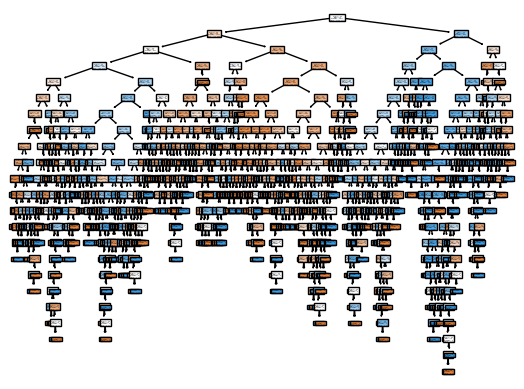

|--- confident_science_Very Confident in Science <= 0.50
|   |--- sex_Male <= 0.50
|   |   |--- absent_freq_Once a week <= 0.50
|   |   |   |--- parent_edu_max_University or Higher <= 0.50
|   |   |   |   |--- parent_edu_max_Post-secondary but not University <= 0.50
|   |   |   |   |   |--- confident_math_Very Confident in Mathematics <= 0.50
|   |   |   |   |   |   |--- desired_edu_ISCED Level 3 <= 0.50
|   |   |   |   |   |   |   |--- like_science_Somewhat Like Learning Science <= 0.50
|   |   |   |   |   |   |   |   |--- like_math_Very Much Like Learning Mathematics <= 0.50
|   |   |   |   |   |   |   |   |   |--- parent_edu_max_Upper Secondary <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- internet_access <= 1.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- internet_access >  1.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- parent_edu_max_Upper S

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import export_text


# Create a classifier object
clf = DecisionTreeClassifier()


# And feature_names is a list of your feature names
feature_names = list(X_train_stud_math.columns)

mean_value_math=Y_stud_math.mean()
mean_value_sci=Y_stud_sci.mean()

Y_stud_math_dis=Y_stud_math.apply(lambda x:0 if x<mean_value_math else 1)
Y_stud_sci_dis=Y_stud_sci.apply(lambda x:0 if x<mean_value_sci else 1)

# Perform cross-validation for math
scores_math = cross_val_score(clf, X_stud,Y_stud_math_dis, cv=5)
print("Math scores:", scores_math)
avg_math_scores=scores_math.mean()
print(avg_math_scores)

# Train the classifier for math
clf.fit(X_train_stud_math, y_train_stud_math_classification_bi)

# Plot the decision tree for math
plt.figure(figsize=(200, 150))
plot_tree(clf, filled=True,rounded=True, class_names=["Below Mean","Above Mean"], max_depth=3,feature_names=feature_names)
plt.show()
# Assuming clf is your trained Decision Tree Classifier


# Export the decision tree to a text representation
tree_rules = export_text(clf, feature_names=feature_names)

# Print the rules
print(tree_rules)
# Predict on the test set for math
y_pred_math = clf.predict(X_test_stud_math)


# Train the classifier for science
clf.fit(X_train_stud_sci, y_train_stud_sci_classification_bi)

# Plot the decision tree for science
plt.figure()
plot_tree(clf, filled=True)
plt.show()

# Assuming clf is your trained Decision Tree Classifier
# And feature_names is a list of your feature names
feature_names = list(X_train_stud_sci.columns)

# Export the decision tree to a text representation
tree_rules = export_text(clf, feature_names=feature_names)

# Print the rules
print(tree_rules)

# Predict on the test set for science
y_pred_sci = clf.predict(X_test_stud_sci)

In [ ]:
# Compute accuracy for math
accuracy_math = accuracy_score(y_test_stud_math_classification_bi, y_pred_math)
print(f"Math Accuracy: {accuracy_math}")
data_math['accuracy']['DTNP']=accuracy_math
# Compute accuracy for science
accuracy_sci = accuracy_score(y_test_stud_sci_classification_bi, y_pred_sci)
print(f"Science Accuracy: {accuracy_sci}")
data_sci['accuracy']['DTNP']=accuracy_sci

Math Accuracy: 0.5875486381322957
Science Accuracy: 0.5408560311284046


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


conf_matrix = confusion_matrix(y_test_stud_math_classification_bi, y_pred_math)
precision = precision_score(y_test_stud_math_classification_bi, y_pred_math, average='weighted')
recall = recall_score(y_test_stud_math_classification_bi, y_pred_math, average='weighted')
f1 = f1_score(y_test_stud_math_classification_bi, y_pred_math, average='weighted')

data_math['precision']['DTNP']=precision
data_math['recall']['DTNP']=recall
data_math['f1_score']['DTNP']=f1

print("math")
print(f"Confusion Matrix:\n {conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


conf_matrix = confusion_matrix(y_test_stud_sci_classification_bi, y_pred_sci)
precision = precision_score(y_test_stud_sci_classification_bi, y_pred_sci, average='weighted')
recall = recall_score(y_test_stud_sci_classification_bi, y_pred_sci, average='weighted')
f1 = f1_score(y_test_stud_sci_classification_bi, y_pred_sci, average='weighted')

data_sci['precision']['DTNP']=precision
data_sci['recall']['DTNP']=recall
data_sci['f1_score']['DTNP']=f1

print("\nscience")
print(f"Confusion Matrix:\n {conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


math
Confusion Matrix:
 [[81 47]
 [59 70]]
Precision: 0.5884693775744361
Recall: 0.5875486381322957
F1 Score: 0.5867228345319052

science
Confusion Matrix:
 [[77 52]
 [66 62]]
Precision: 0.5411500916313531
Recall: 0.5408560311284046
F1 Score: 0.539391212316679


# binary classification with pruning

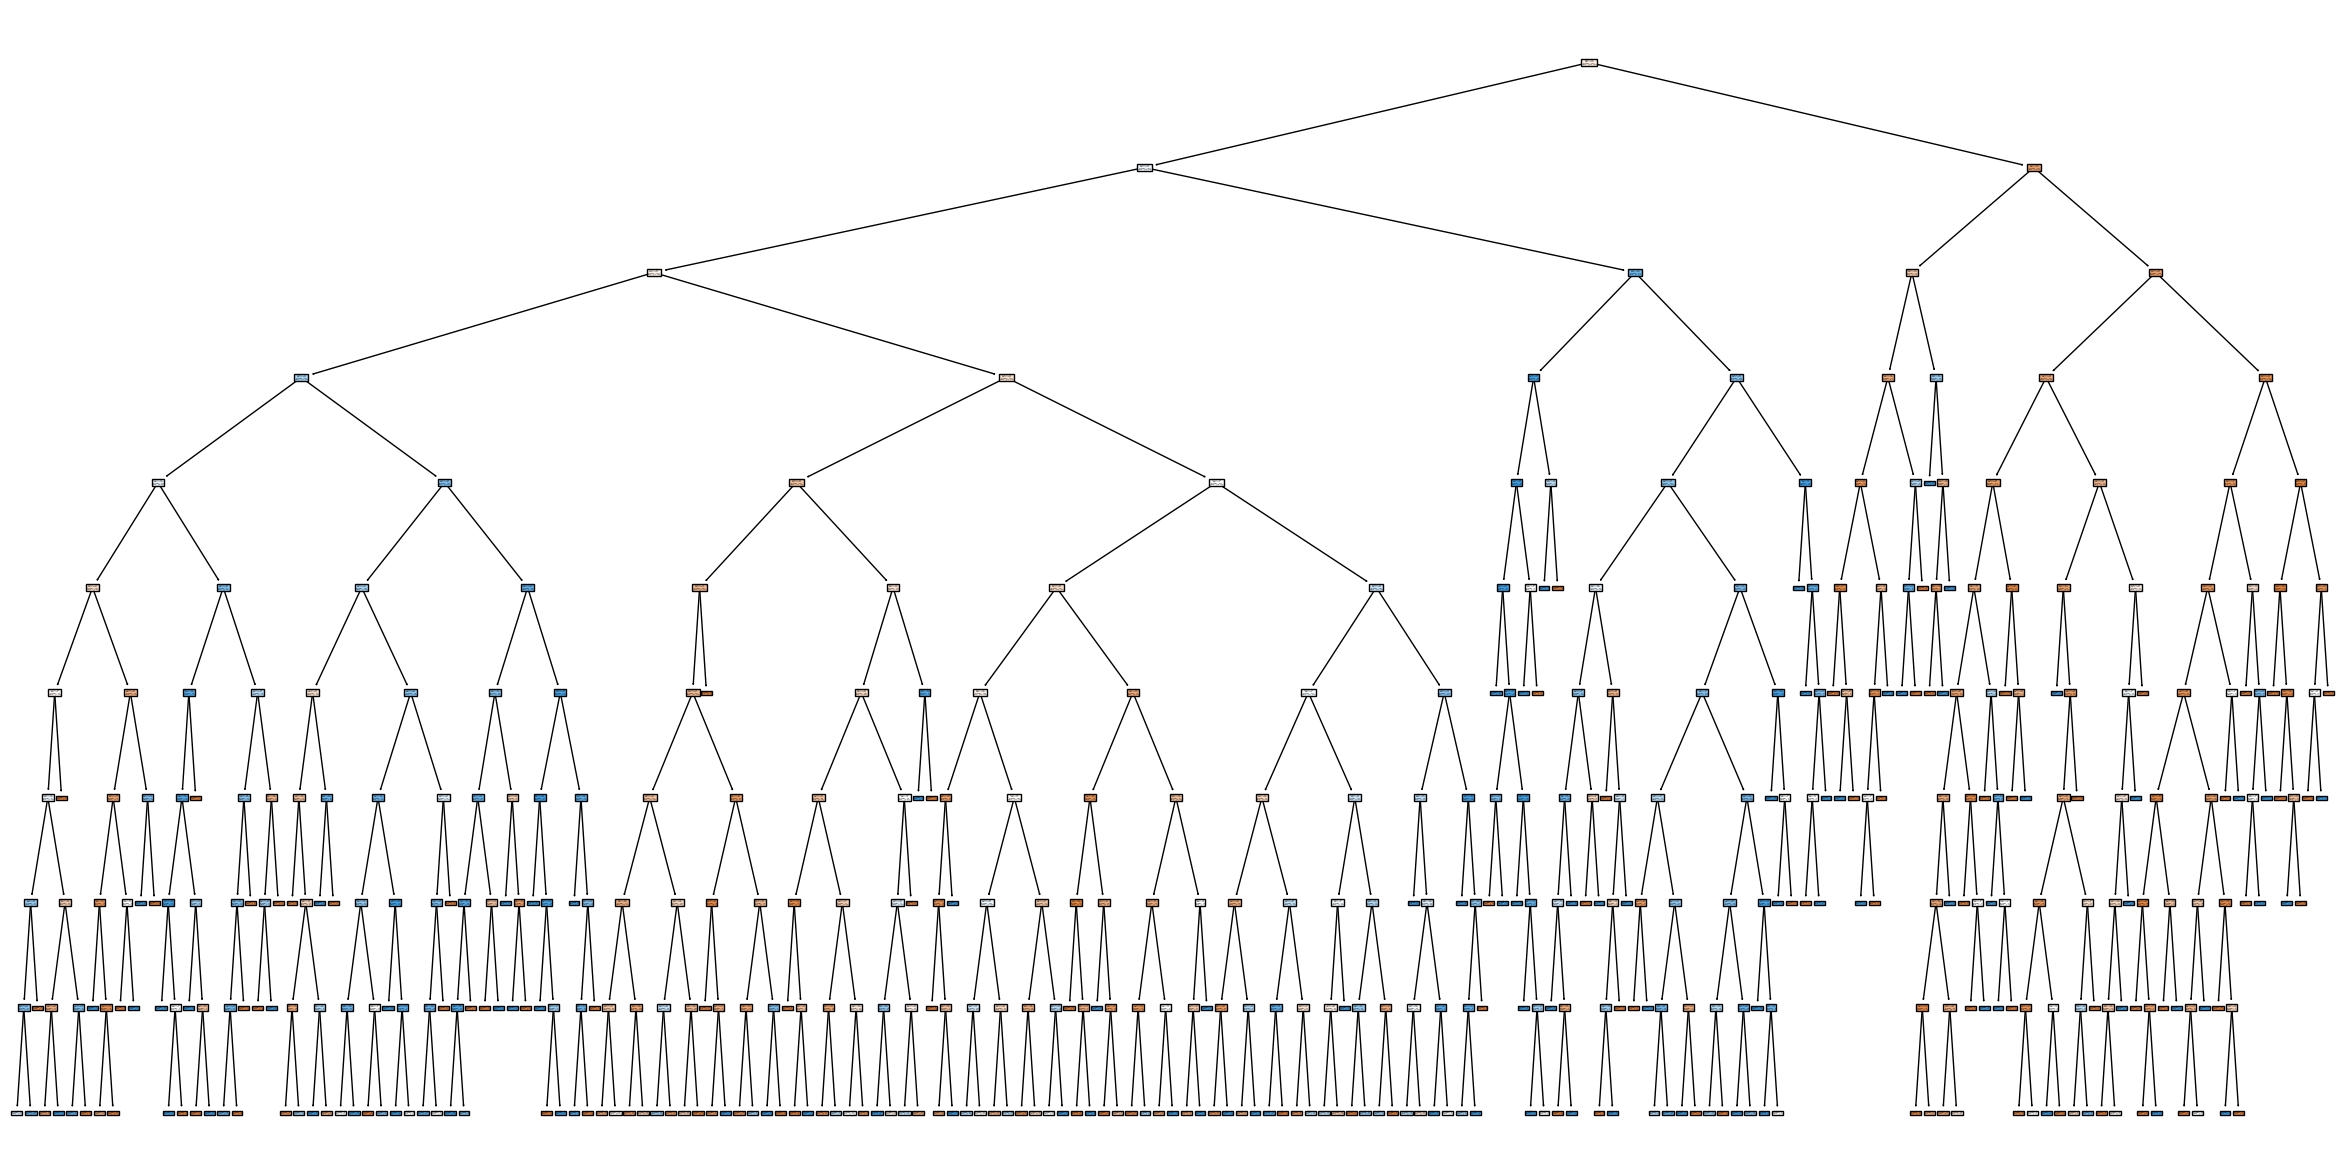

|--- absent_freq_Once a week <= 0.50
|   |--- confident_math_Very Confident in Mathematics <= 0.50
|   |   |--- parent_immig_1 <= 0.50
|   |   |   |--- parent_edu_max_University or Higher <= 0.50
|   |   |   |   |--- parent_edu_max_Post-secondary but not University <= 0.50
|   |   |   |   |   |--- like_science_Somewhat Like Learning Science <= 0.50
|   |   |   |   |   |   |--- desired_edu_ISCED Level 4 <= 0.50
|   |   |   |   |   |   |   |--- confident_science_Very Confident in Science <= 0.50
|   |   |   |   |   |   |   |   |--- internet_access <= 5.50
|   |   |   |   |   |   |   |   |   |--- value_science_Strongly Value Science <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- value_science_Strongly Value Science >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- internet_access >  5.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- confident_scienc

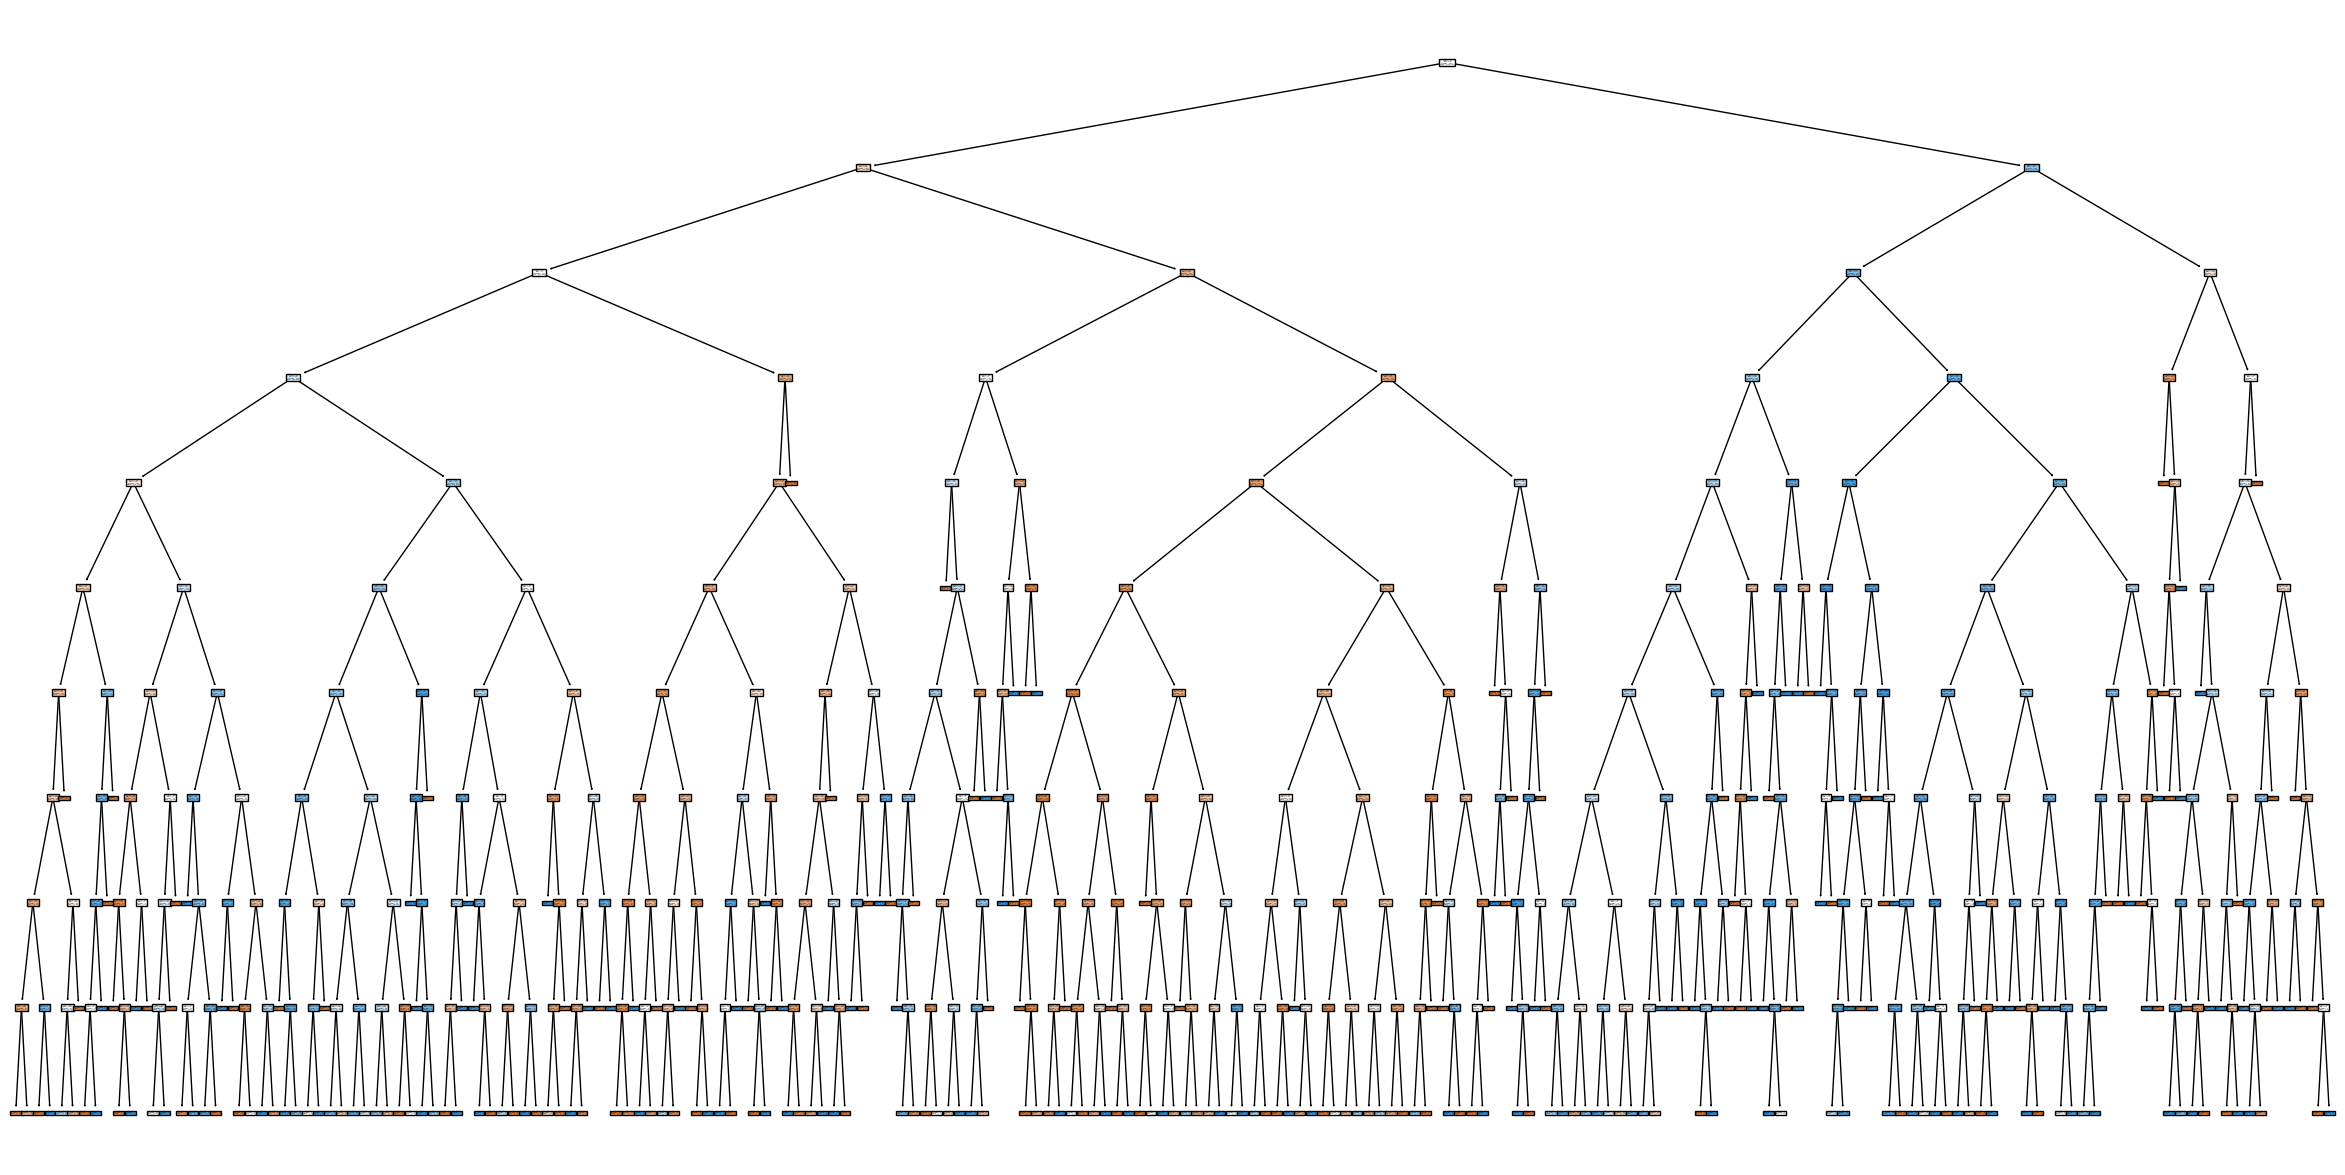

|--- confident_science_Very Confident in Science <= 0.50
|   |--- sex_Male <= 0.50
|   |   |--- absent_freq_Once a week <= 0.50
|   |   |   |--- parent_edu_max_University or Higher <= 0.50
|   |   |   |   |--- parent_edu_max_Post-secondary but not University <= 0.50
|   |   |   |   |   |--- confident_math_Very Confident in Mathematics <= 0.50
|   |   |   |   |   |   |--- desired_edu_ISCED Level 3 <= 0.50
|   |   |   |   |   |   |   |--- like_science_Somewhat Like Learning Science <= 0.50
|   |   |   |   |   |   |   |   |--- like_math_Very Much Like Learning Mathematics <= 0.50
|   |   |   |   |   |   |   |   |   |--- parent_edu_max_Upper Secondary <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- parent_edu_max_Upper Secondary >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- like_math_Very Much Like Learning Mathematics >  0.50
|   |   |   |   |   |   |   |   |   |--- value_science_St

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import export_text

# Create a classifier object with max_depth set to a specific value
clf = DecisionTreeClassifier(max_depth=10)

# Train the classifier for math
clf.fit(X_train_stud_math, y_train_stud_math_classification_bi)

# Plot the decision tree for math
plt.figure(figsize=(30, 15))
plot_tree(clf, filled=True)
plt.show()

# Assuming clf is your trained Decision Tree Classifier
# And feature_names is a list of your feature names
feature_names = list(X_train_stud_math.columns)

# Export the decision tree to a text representation
tree_rules = export_text(clf, feature_names=feature_names)

# Print the rules
print(tree_rules)

# Predict on the test set for math
y_pred_math = clf.predict(X_test_stud_math)

# Train the classifier for science
clf.fit(X_train_stud_sci, y_train_stud_sci_classification_bi)

# Plot the decision tree for science
plt.figure(figsize=(30, 15))
plot_tree(clf, filled=True)
plt.show()

# Assuming clf is your trained Decision Tree Classifier
# And feature_names is a list of your feature names
feature_names = list(X_train_stud_sci.columns)

# Export the decision tree to a text representation
tree_rules = export_text(clf, feature_names=feature_names)

# Print the rules
print(tree_rules)

# Predict on the test set for science
y_pred_sci = clf.predict(X_test_stud_sci)


In [ ]:
# Compute accuracy for math
accuracy_math = accuracy_score(y_test_stud_math_classification_bi, y_pred_math)
print(f"Math Accuracy: {accuracy_math}")

data_math['accuracy']['DTP10']=accuracy_math

# Compute accuracy for science
accuracy_sci = accuracy_score(y_test_stud_sci_classification_bi, y_pred_sci)
print(f"Science Accuracy: {accuracy_sci}")


data_sci['accuracy']['DTP10']=accuracy_sci

conf_matrix = confusion_matrix(y_test_stud_math_classification_bi, y_pred_math)
precision = precision_score(y_test_stud_math_classification_bi, y_pred_math, average='weighted')
recall = recall_score(y_test_stud_math_classification_bi, y_pred_math, average='weighted')
f1 = f1_score(y_test_stud_math_classification_bi, y_pred_math, average='weighted')

data_math['precision']['DTP10']=precision
data_math['recall']['DTP10']=recall
data_math['f1_score']['DTP10']=f1

print("math")
print(f"Confusion Matrix:\n {conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


conf_matrix = confusion_matrix(y_test_stud_sci_classification_bi, y_pred_sci)
precision = precision_score(y_test_stud_sci_classification_bi, y_pred_sci, average='weighted')
recall = recall_score(y_test_stud_sci_classification_bi, y_pred_sci, average='weighted')
f1 = f1_score(y_test_stud_sci_classification_bi, y_pred_sci, average='weighted')

data_sci['precision']['DTP10']=precision
data_sci['recall']['DTP10']=recall
data_sci['f1_score']['DTP10']=f1

print("\nscience")
print(f"Confusion Matrix:\n {conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Math Accuracy: 0.6303501945525292
Science Accuracy: 0.603112840466926
math
Confusion Matrix:
 [[90 38]
 [57 72]]
Precision: 0.6334774730550161
Recall: 0.6303501945525292
F1 Score: 0.6284267220007903

science
Confusion Matrix:
 [[80 49]
 [53 75]]
Precision: 0.6031647463078432
Recall: 0.603112840466926
F1 Score: 0.6029926153489286


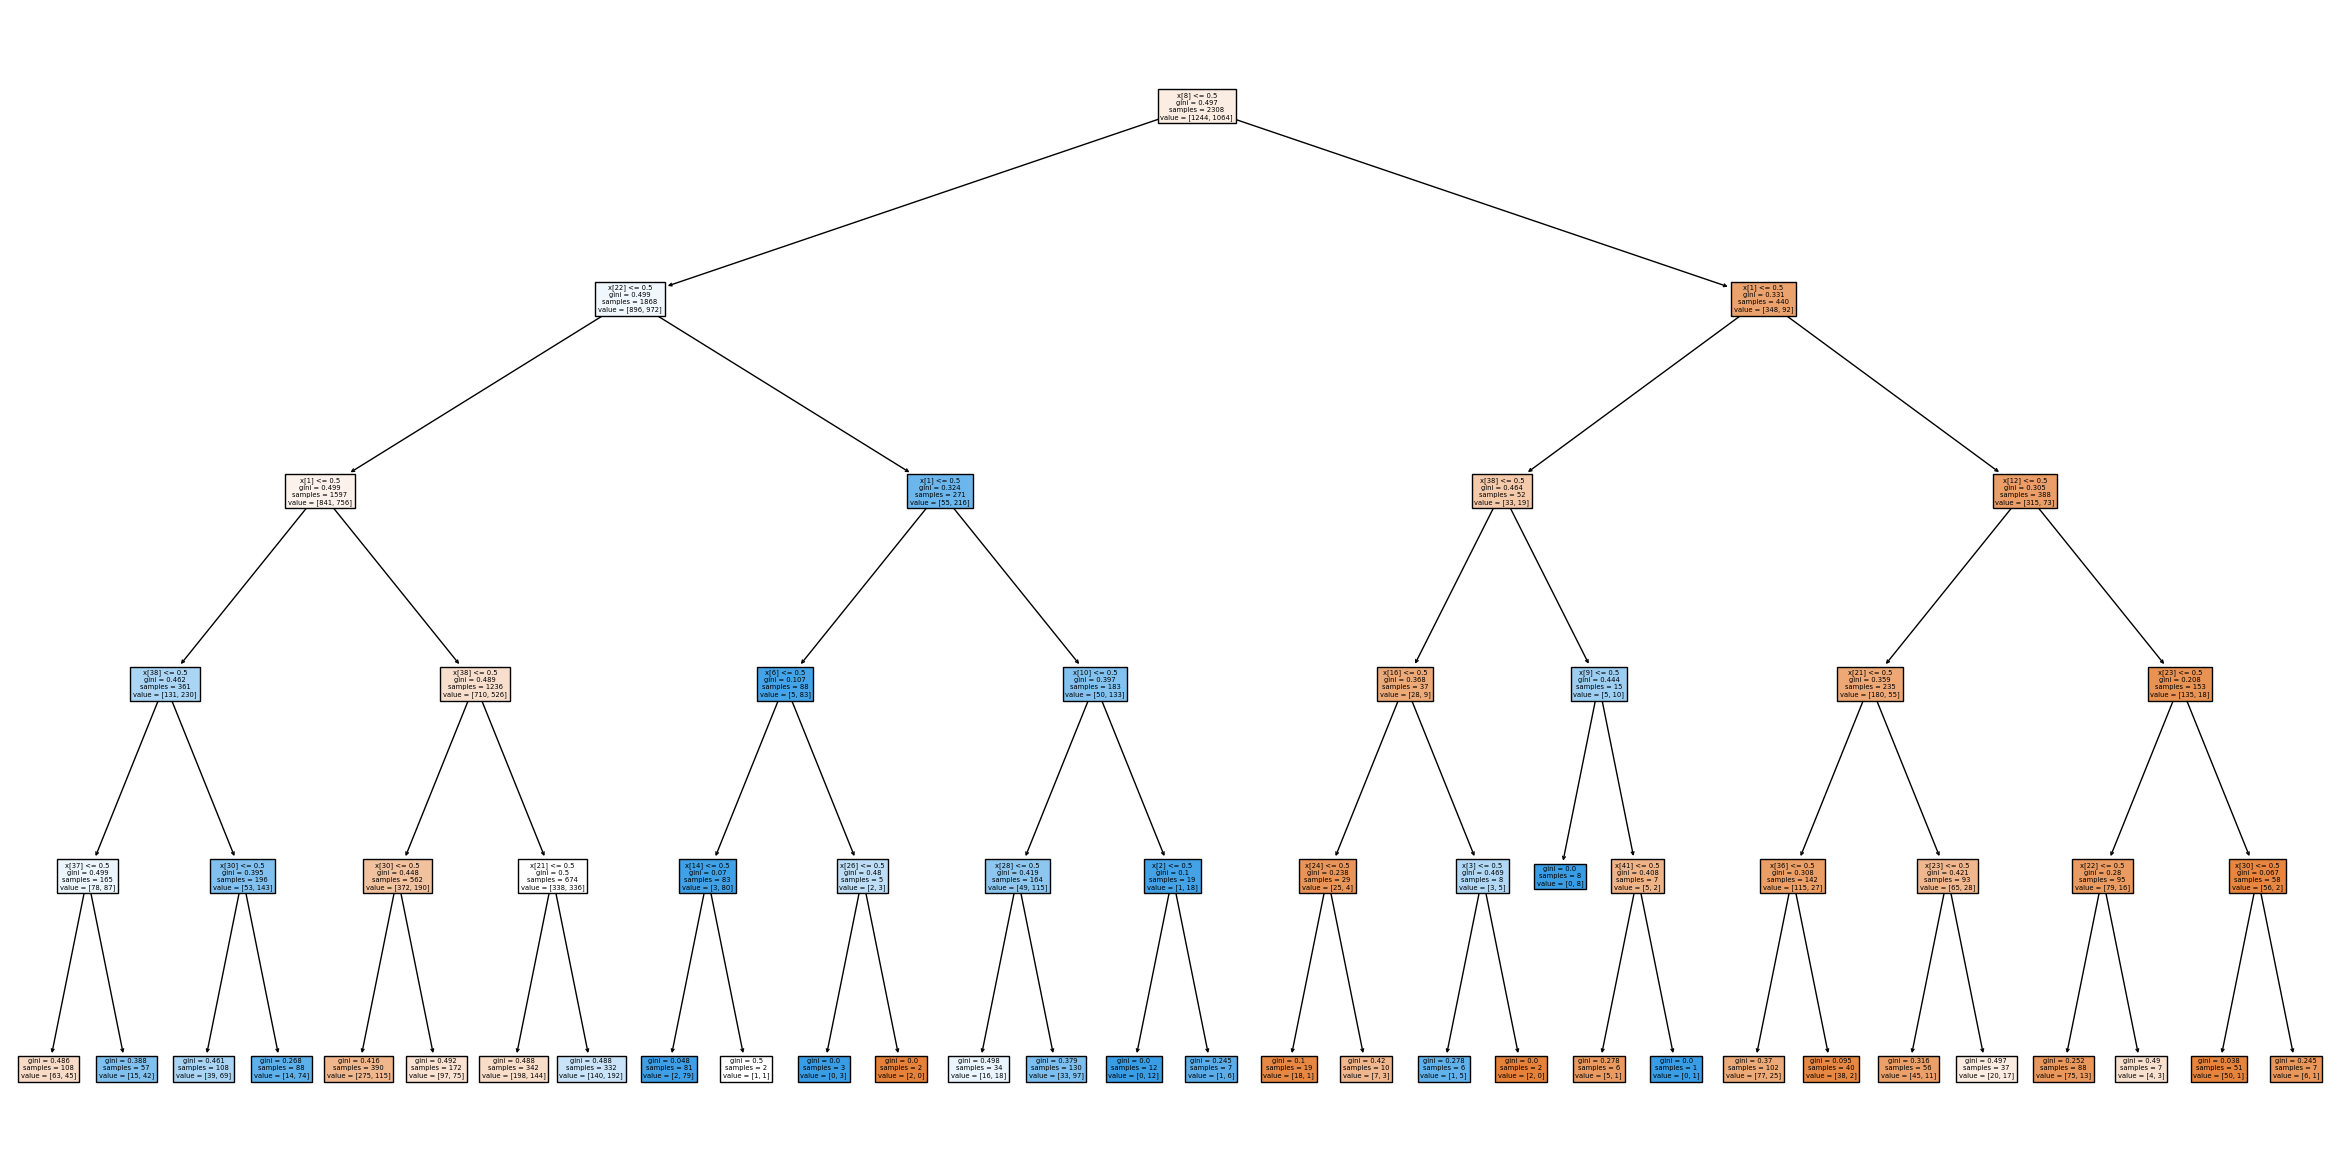

|--- absent_freq_Once a week <= 0.50
|   |--- confident_math_Very Confident in Mathematics <= 0.50
|   |   |--- parent_immig_1 <= 0.50
|   |   |   |--- parent_edu_max_University or Higher <= 0.50
|   |   |   |   |--- parent_edu_max_Post-secondary but not University <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- parent_edu_max_Post-secondary but not University >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- parent_edu_max_University or Higher >  0.50
|   |   |   |   |--- confident_science_Very Confident in Science <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- confident_science_Very Confident in Science >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- parent_immig_1 >  0.50
|   |   |   |--- parent_edu_max_University or Higher <= 0.50
|   |   |   |   |--- confident_science_Very Confident in Science <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- confident_science_Very Confident in Science >  0.50
|   |   |   |   |   |--- cla

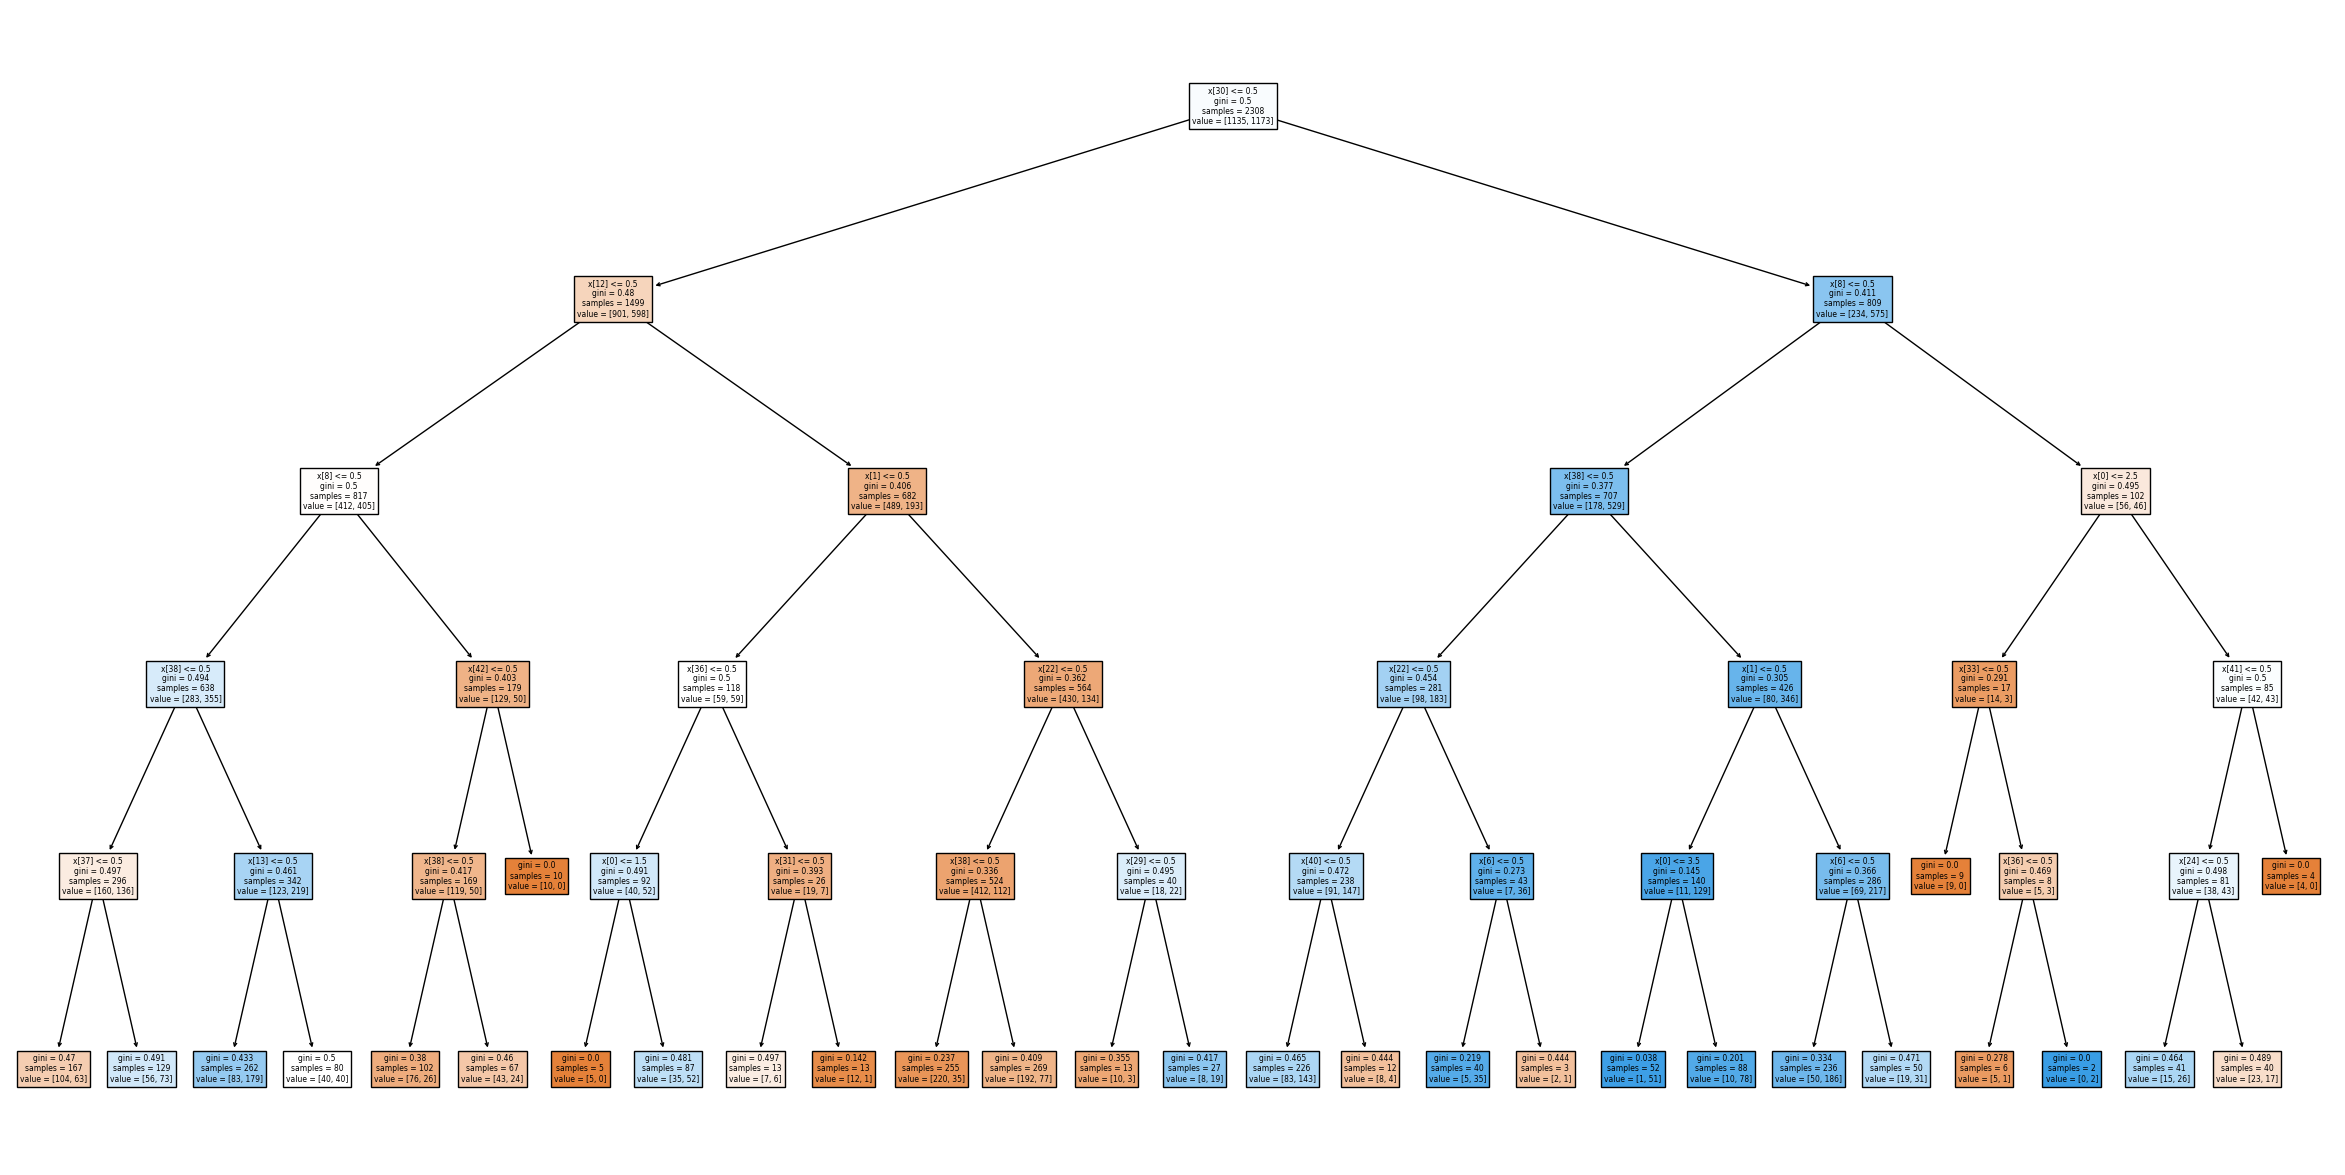

|--- confident_science_Very Confident in Science <= 0.50
|   |--- sex_Male <= 0.50
|   |   |--- absent_freq_Once a week <= 0.50
|   |   |   |--- parent_edu_max_University or Higher <= 0.50
|   |   |   |   |--- parent_edu_max_Post-secondary but not University <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- parent_edu_max_Post-secondary but not University >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- parent_edu_max_University or Higher >  0.50
|   |   |   |   |--- bullying_About Monthly <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- bullying_About Monthly >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- absent_freq_Once a week >  0.50
|   |   |   |--- desired_edu_ISCED Level 5 <= 0.50
|   |   |   |   |--- parent_edu_max_University or Higher <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- parent_edu_max_University or Higher >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- desired_edu_ISCED Level 5 >  0.50
|   |   |

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import export_text

# Create a classifier object with max_depth set to a specific value
clf = DecisionTreeClassifier(max_depth=5)

# Train the classifier for math
clf.fit(X_train_stud_math, y_train_stud_math_classification_bi)

# Plot the decision tree for math
plt.figure(figsize=(30, 15))
plot_tree(clf, filled=True)
plt.show()

# Assuming clf is your trained Decision Tree Classifier
# And feature_names is a list of your feature names
feature_names = list(X_train_stud_math.columns)

# Export the decision tree to a text representation
tree_rules = export_text(clf, feature_names=feature_names)

# Print the rules
print(tree_rules)

# Predict on the test set for math
y_pred_math = clf.predict(X_test_stud_math)

# Train the classifier for science
clf.fit(X_train_stud_sci, y_train_stud_sci_classification_bi)

# Plot the decision tree for science
plt.figure(figsize=(30, 15))
plot_tree(clf, filled=True)
plt.show()

# Assuming clf is your trained Decision Tree Classifier
# And feature_names is a list of your feature names
feature_names = list(X_train_stud_sci.columns)

# Export the decision tree to a text representation
tree_rules = export_text(clf, feature_names=feature_names)

# Print the rules
print(tree_rules)

# Predict on the test set for science
y_pred_sci = clf.predict(X_test_stud_sci)



# Compute accuracy for math
accuracy_math = accuracy_score(y_test_stud_math_classification_bi, y_pred_math)
print(f"Math Accuracy: {accuracy_math}")

data_math['accuracy']['DTP5']=accuracy_math

# Compute accuracy for science
accuracy_sci = accuracy_score(y_test_stud_sci_classification_bi, y_pred_sci)
print(f"Science Accuracy: {accuracy_sci}")

data_sci['accuracy']['DTP5']=accuracy_sci


conf_matrix = confusion_matrix(y_test_stud_math_classification_bi, y_pred_math)
precision = precision_score(y_test_stud_math_classification_bi, y_pred_math, average='weighted')
recall = recall_score(y_test_stud_math_classification_bi, y_pred_math, average='weighted')
f1 = f1_score(y_test_stud_math_classification_bi, y_pred_math, average='weighted')

data_math['precision']['DTP5']=precision
data_math['recall']['DTP5']=recall
data_math['f1_score']['DTP5']=f1

print("math")
print(f"Confusion Matrix:\n {conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


conf_matrix = confusion_matrix(y_test_stud_sci_classification_bi, y_pred_sci)
precision = precision_score(y_test_stud_sci_classification_bi, y_pred_sci, average='weighted')
recall = recall_score(y_test_stud_sci_classification_bi, y_pred_sci, average='weighted')
f1 = f1_score(y_test_stud_sci_classification_bi, y_pred_sci, average='weighted')

data_sci['precision']['DTP5']=precision
data_sci['recall']['DTP5']=recall
data_sci['f1_score']['DTP5']=f1

print("\nscience")
print(f"Confusion Matrix:\n {conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


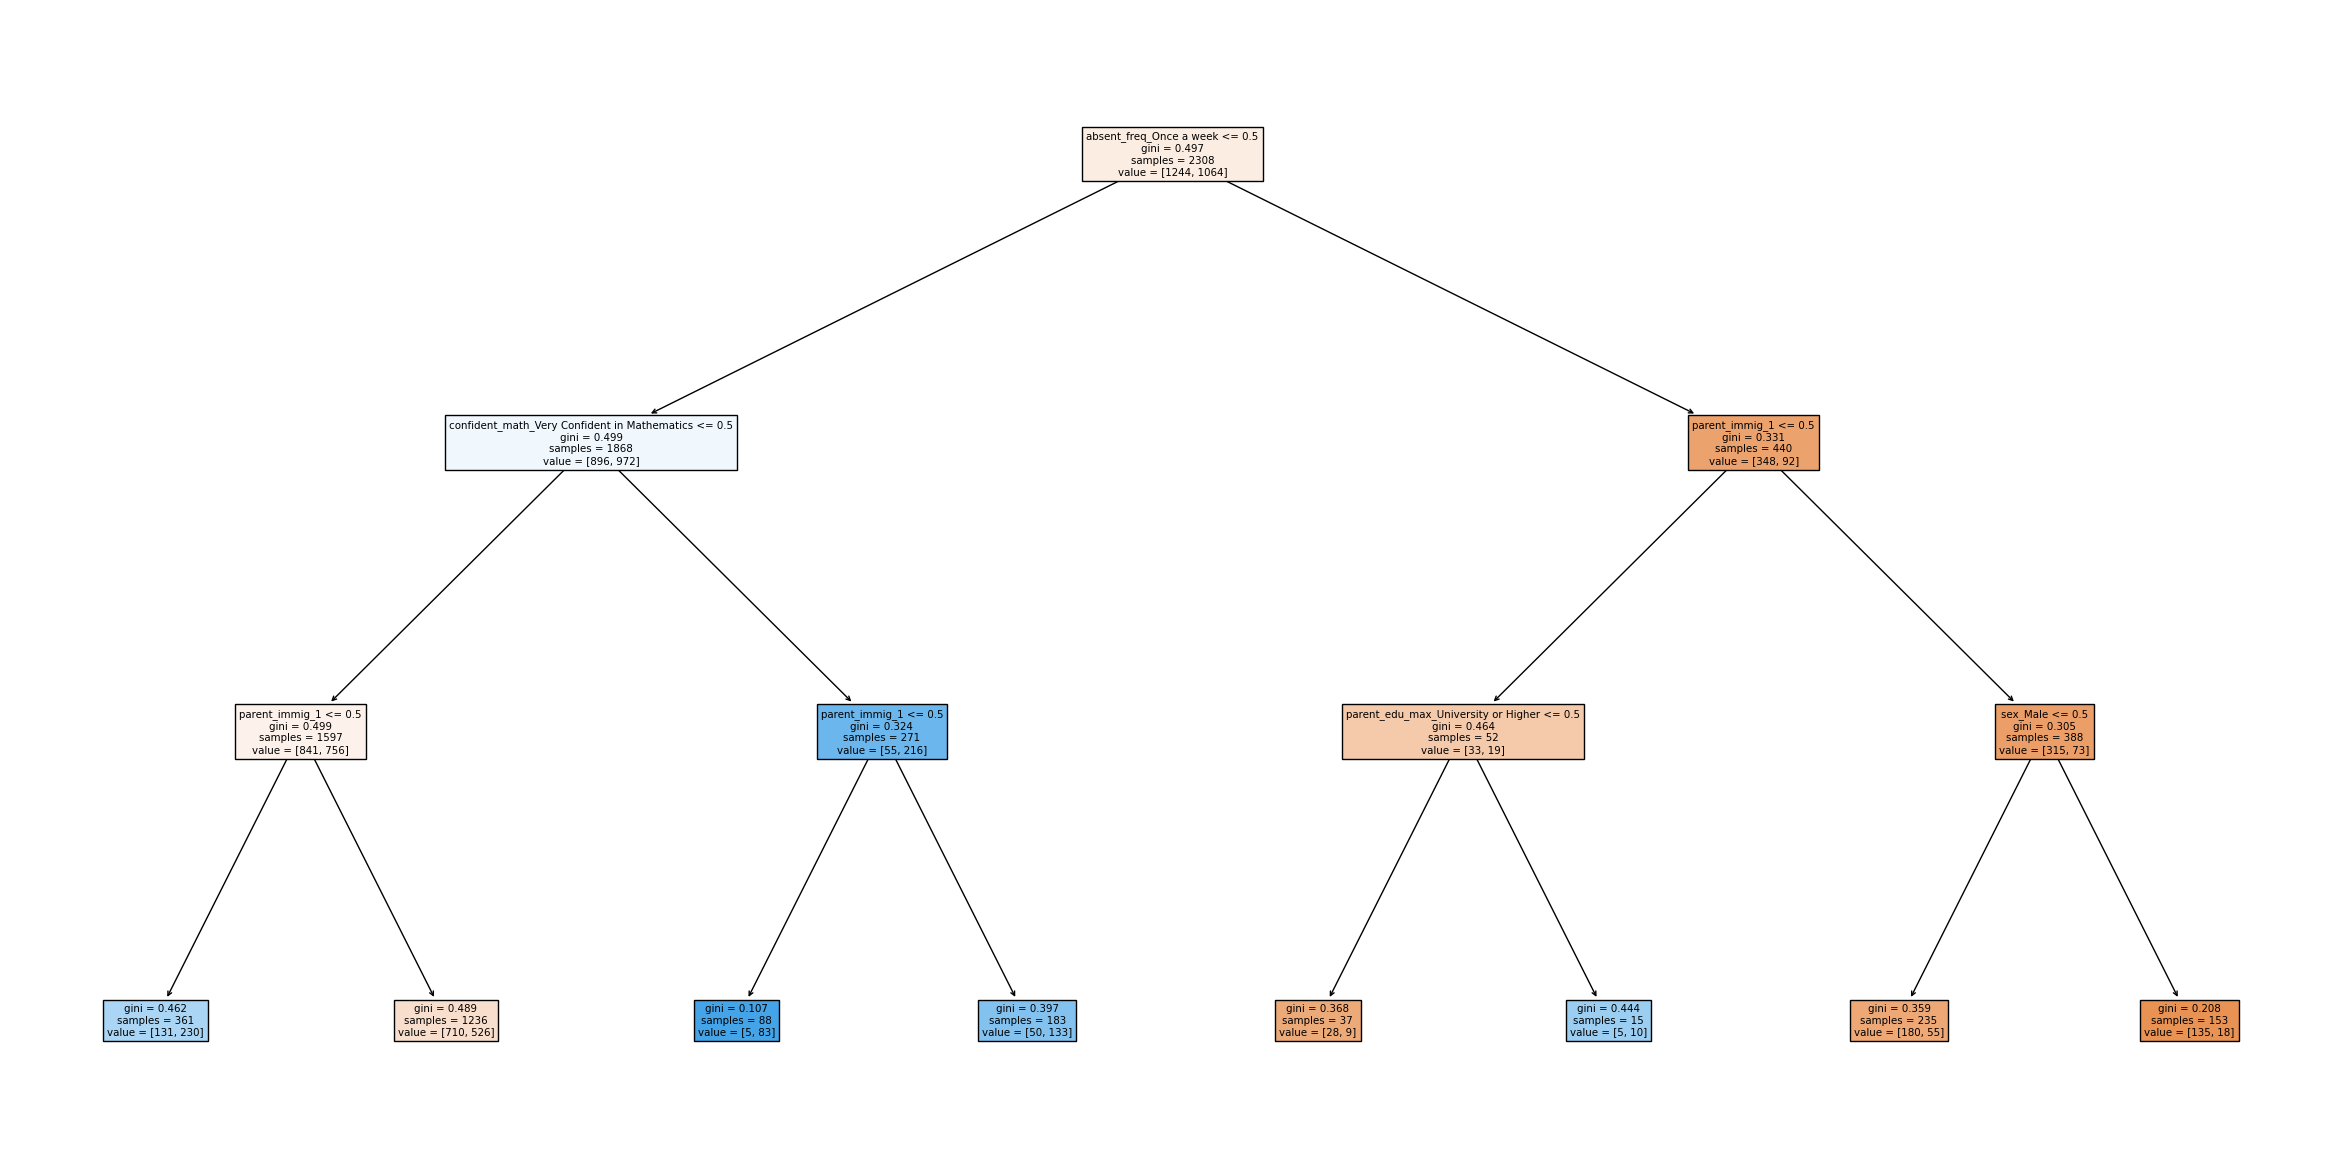

|--- absent_freq_Once a week <= 0.50
|   |--- confident_math_Very Confident in Mathematics <= 0.50
|   |   |--- parent_immig_1 <= 0.50
|   |   |   |--- class: 1
|   |   |--- parent_immig_1 >  0.50
|   |   |   |--- class: 0
|   |--- confident_math_Very Confident in Mathematics >  0.50
|   |   |--- parent_immig_1 <= 0.50
|   |   |   |--- class: 1
|   |   |--- parent_immig_1 >  0.50
|   |   |   |--- class: 1
|--- absent_freq_Once a week >  0.50
|   |--- parent_immig_1 <= 0.50
|   |   |--- parent_edu_max_University or Higher <= 0.50
|   |   |   |--- class: 0
|   |   |--- parent_edu_max_University or Higher >  0.50
|   |   |   |--- class: 1
|   |--- parent_immig_1 >  0.50
|   |   |--- sex_Male <= 0.50
|   |   |   |--- class: 0
|   |   |--- sex_Male >  0.50
|   |   |   |--- class: 0



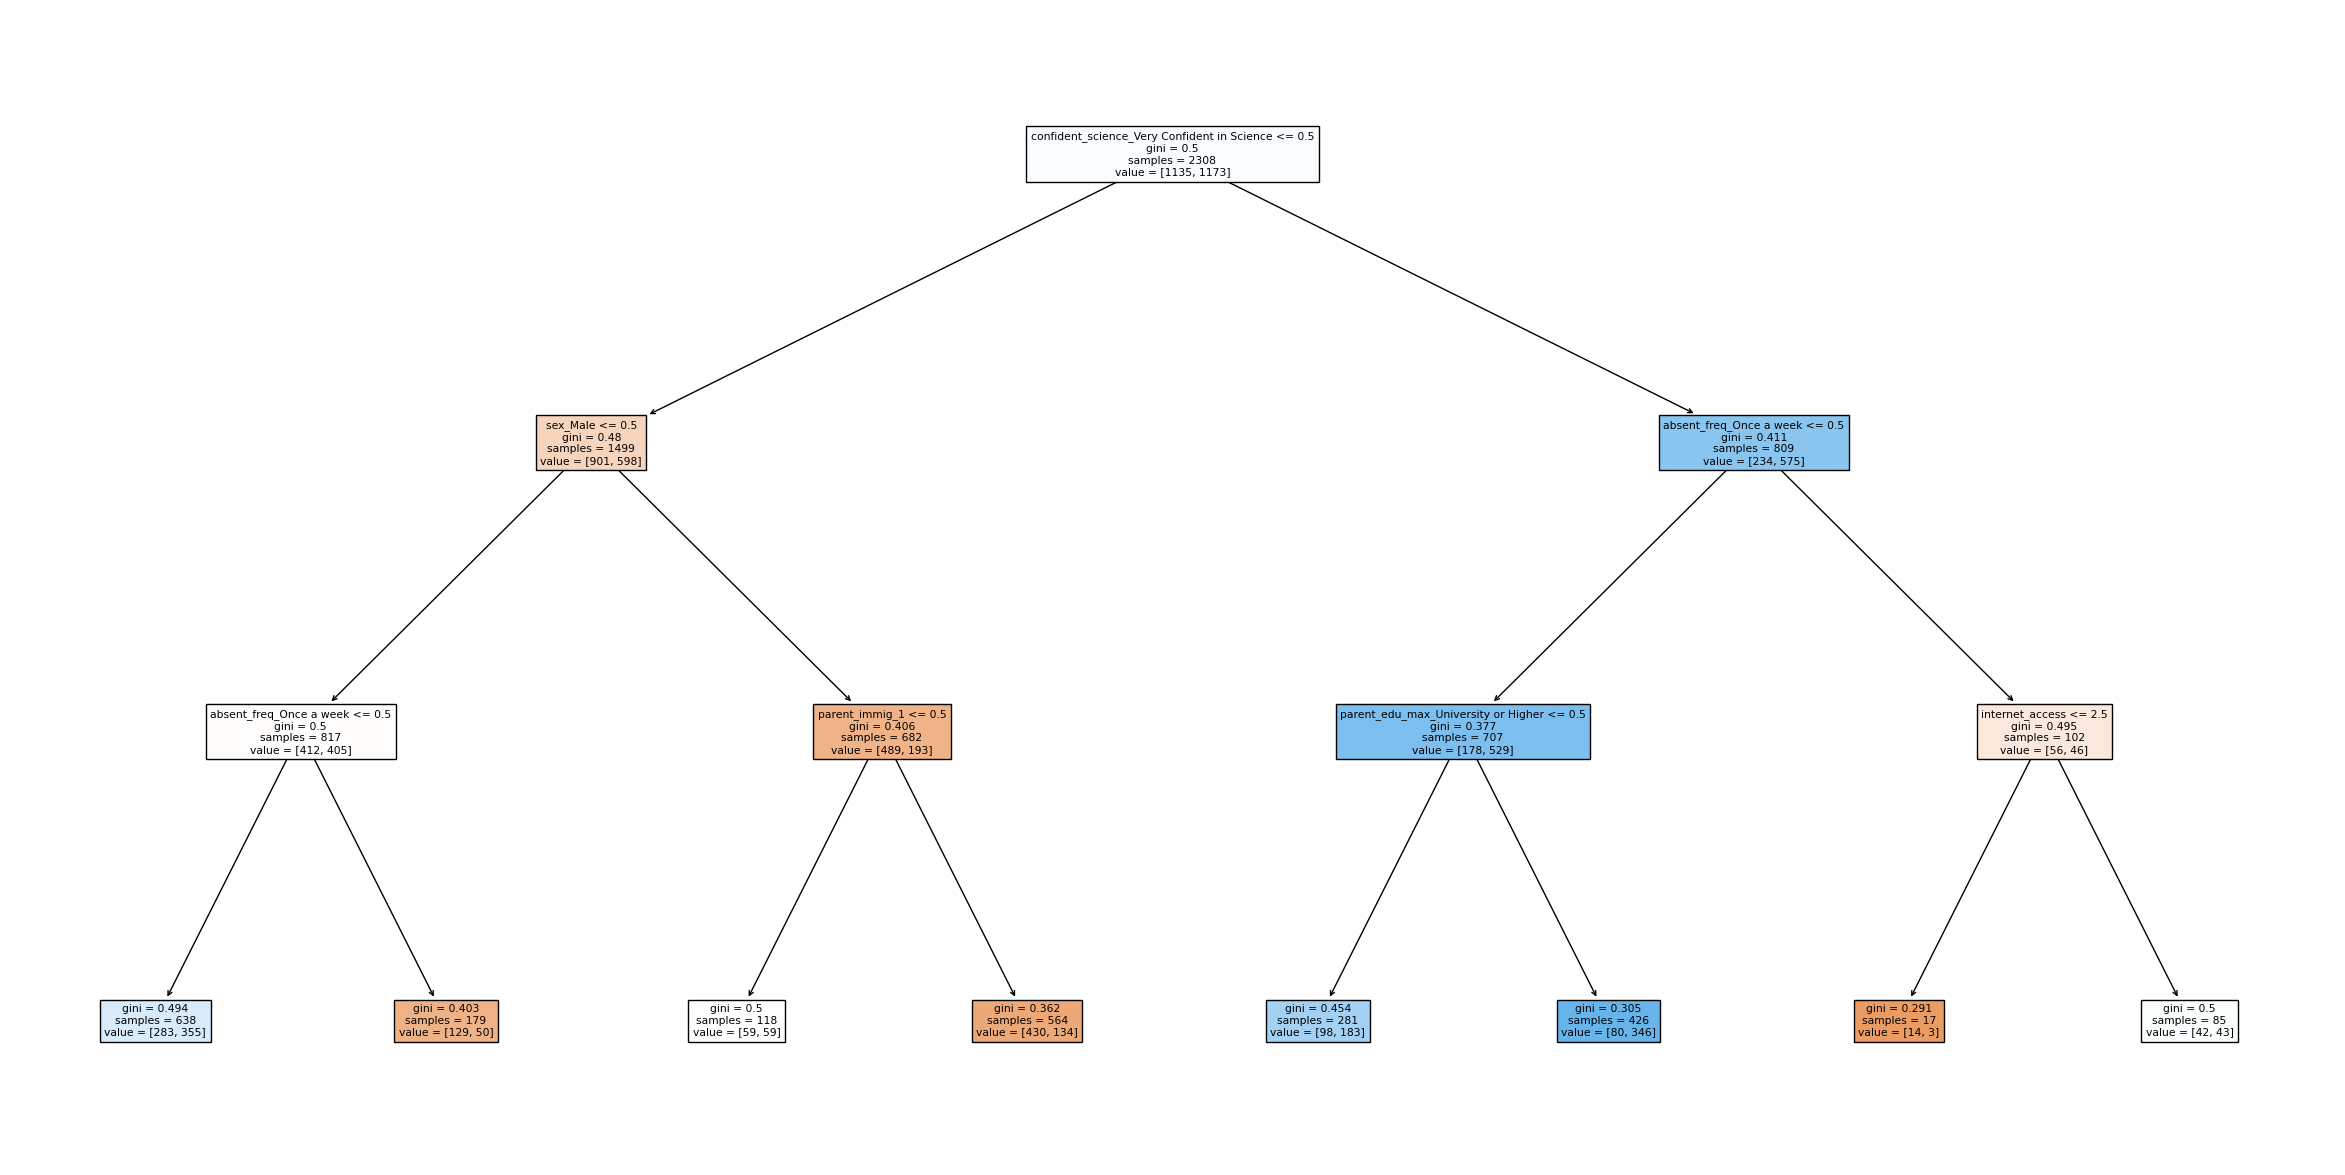

|--- confident_science_Very Confident in Science <= 0.50
|   |--- sex_Male <= 0.50
|   |   |--- absent_freq_Once a week <= 0.50
|   |   |   |--- class: 1
|   |   |--- absent_freq_Once a week >  0.50
|   |   |   |--- class: 0
|   |--- sex_Male >  0.50
|   |   |--- parent_immig_1 <= 0.50
|   |   |   |--- class: 0
|   |   |--- parent_immig_1 >  0.50
|   |   |   |--- class: 0
|--- confident_science_Very Confident in Science >  0.50
|   |--- absent_freq_Once a week <= 0.50
|   |   |--- parent_edu_max_University or Higher <= 0.50
|   |   |   |--- class: 1
|   |   |--- parent_edu_max_University or Higher >  0.50
|   |   |   |--- class: 1
|   |--- absent_freq_Once a week >  0.50
|   |   |--- internet_access <= 2.50
|   |   |   |--- class: 0
|   |   |--- internet_access >  2.50
|   |   |   |--- class: 1

Math Accuracy: 0.6964980544747081
Science Accuracy: 0.6575875486381323
math
Confusion Matrix:
 [[114  14]
 [ 64  65]]
Precision: 0.7319718622420885
Recall: 0.6964980544747081
F1 Score: 0.684815

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import export_text

# Create a classifier object with max_depth set to a specific value
clf = DecisionTreeClassifier(max_depth=3)

# Train the classifier for math
clf.fit(X_train_stud_math, y_train_stud_math_classification_bi)

# Plot the decision tree for math
plt.figure(figsize=(30, 15))
plot_tree(clf, filled=True,feature_names=feature_names)
plt.show()

# Assuming clf is your trained Decision Tree Classifier
# And feature_names is a list of your feature names
feature_names = list(X_train_stud_math.columns)

# Export the decision tree to a text representation
tree_rules = export_text(clf, feature_names=feature_names)

# Print the rules
print(tree_rules)

# Predict on the test set for math
y_pred_math = clf.predict(X_test_stud_math)

# Train the classifier for science
clf.fit(X_train_stud_sci, y_train_stud_sci_classification_bi)

# Plot the decision tree for science
plt.figure(figsize=(30, 15))
plot_tree(clf, filled=True,feature_names=feature_names)
plt.show()

# Assuming clf is your trained Decision Tree Classifier
# And feature_names is a list of your feature names
feature_names = list(X_train_stud_sci.columns)

# Export the decision tree to a text representation
tree_rules = export_text(clf, feature_names=feature_names)

# Print the rules
print(tree_rules)

# Predict on the test set for science
y_pred_sci = clf.predict(X_test_stud_sci)



# Compute accuracy for math
accuracy_math = accuracy_score(y_test_stud_math_classification_bi, y_pred_math)
print(f"Math Accuracy: {accuracy_math}")

data_math['accuracy']['DTP3']=accuracy_math

# Compute accuracy for science
accuracy_sci = accuracy_score(y_test_stud_sci_classification_bi, y_pred_sci)

data_sci['accuracy']['DTP3']=accuracy_sci

print(f"Science Accuracy: {accuracy_sci}")




conf_matrix = confusion_matrix(y_test_stud_math_classification_bi, y_pred_math)
precision = precision_score(y_test_stud_math_classification_bi, y_pred_math, average='weighted')
recall = recall_score(y_test_stud_math_classification_bi, y_pred_math, average='weighted')
f1 = f1_score(y_test_stud_math_classification_bi, y_pred_math, average='weighted')

data_math['precision']['DTP3']=precision
data_math['recall']['DTP3']=recall
data_math['f1_score']['DTP3']=f1

print("math")
print(f"Confusion Matrix:\n {conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


conf_matrix = confusion_matrix(y_test_stud_sci_classification_bi, y_pred_sci)
precision = precision_score(y_test_stud_sci_classification_bi, y_pred_sci, average='weighted')
recall = recall_score(y_test_stud_sci_classification_bi, y_pred_sci, average='weighted')
f1 = f1_score(y_test_stud_sci_classification_bi, y_pred_sci, average='weighted')
data_sci['precision']['DTP3']=precision
data_sci['recall']['DTP3']=recall
data_sci['f1_score']['DTP3']=f1

print("\nscience")
print(f"Confusion Matrix:\n {conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


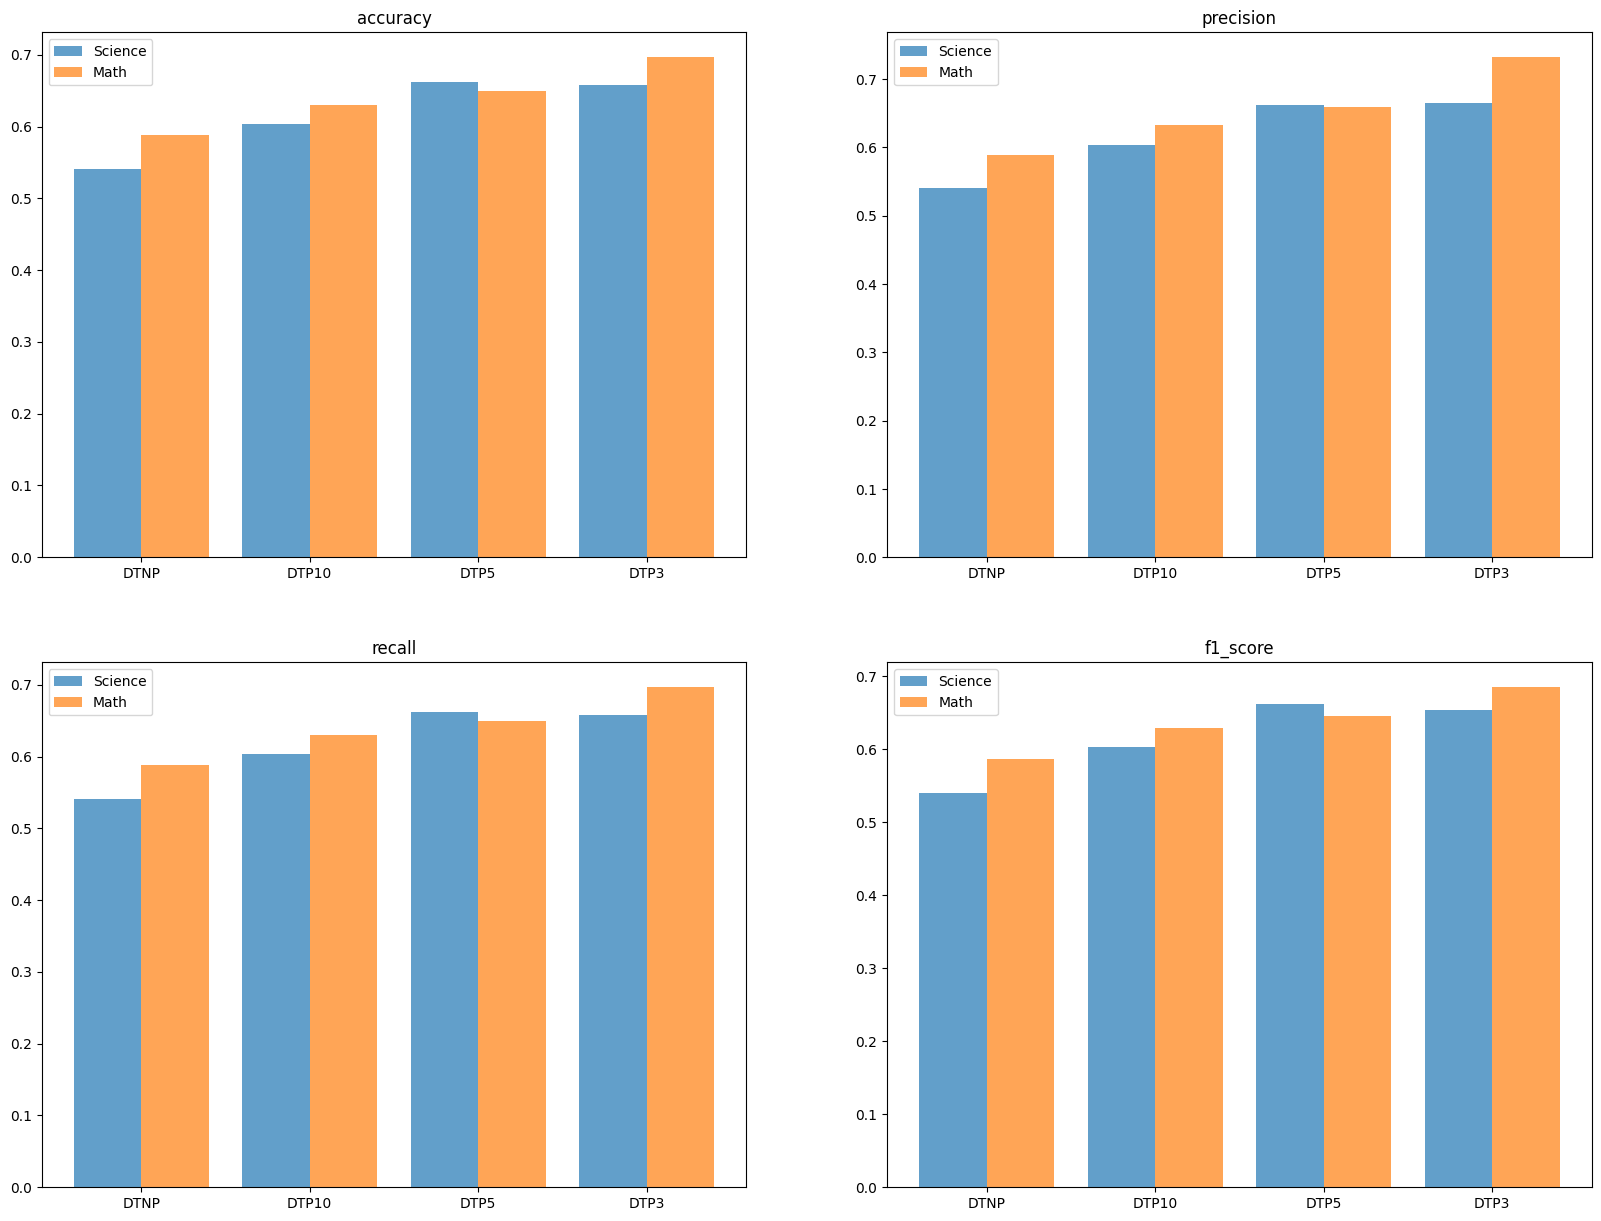

In [ ]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

# Flatten the array of axes
axs = axs.flatten()



# Plot the data
for ax, (metric_sci, scores_sci), (metric_math, scores_math) in zip(axs, data_sci.items(), data_math.items()):
    # Get the names of the decision tree algorithms and the scores
    names = list(scores_sci.keys())
    values_sci = list(scores_sci.values())
    values_math = list(scores_math.values())

    # Create the bar chart for science
    ax.bar(np.arange(len(names)) - 0.2, values_sci, 0.4, label='Science', alpha=0.7)

    # Create the bar chart for math
    ax.bar(np.arange(len(names)) + 0.2, values_math, 0.4, label='Math', alpha=0.7)

    # Set the title of the subplot
    ax.set_title(metric_sci)

    # Add a legend
    ax.legend()

    # Set the x-ticks to be the names of the decision tree algorithms
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(names)

# Display the plot
plt.show()

In [ ]:
print(data_sci)
print(data_math)

NameError: name 'data_sci' is not defined